In [48]:
import PIL.Image as Image
import imageio
import pylab as py
%matplotlib inline
import numpy as np
import csv
import warnings
from numpy.linalg import eig, inv

In [49]:
csv_file = '20180831_RHA_610_30.csv'
#threshold = 40
input_frame = 'video_frames/frame{:d}.jpg'
output_frame = '20180831_RHA_610_30_circles/frame{:d}.jpg'
test_frame = 'video_frames/frame1.jpg'
first_frame = 'video_frames/frame1.jpg'
n_frame = 3685
estimate_center = np.array([600,600])
estimate_radius = 300

In [50]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])   
        
    Source code: https://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [51]:
'''Idea from: https://stackoverflow.com/questions/45922566/ellipse-fitting-for-pupil-center'''

def find_edge_points(center, radius, img, d_theta = np.pi/180 ):
#    r = 2 * radius
    r = 500
    points = []
    
    for theta in np.arange(0, 2*np.pi, d_theta):
        end_point_x = (center[0] + r*np.cos(theta)).astype(np.int)
        end_point_y = (center[1] + r*np.sin(theta)).astype(np.int)
        end_point = np.array([end_point_x,end_point_y])
        result = createLineIterator(center, end_point, img)

        '''need to twiddle more to find a better way to find the edge points'''
#        diff = []
#        sum_lum = []
#        for i in range(1,len(result)):
#            diff.append(result[i][2] - result[i-1][2])
#        for i in range(len(diff)):    
#            sum_lum.append(sum(diff[:i]))
        #print(sum_lum)
#        for i in range(2,len(sum_lum)):
#            if sum_lum[i] > 3 * sum_lum[i-1] and sum_lum[i-1] > 3 * sum_lum[i-2] and sum_lum[i-1] > 0:
#                points.append((result[i][0],result[i][1]))
#                break

        edge_detected = False
        glare_detected = False
        
        for i in range(len(result)):
            
            if result[i][2] == 255:
                edge_detected = True
                
            if edge_detected:
                for j in range(i,len(result)-i):
                    if result[j][2] == 0:
                        glare_detected = True
                        break
            if edge_detected and not glare_detected:
                points.append((result[i][0],result[i][1]))
                break
    return points

'''http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html'''

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [52]:
def image_thresholding(img,threshold):
    threshold_pupil = threshold  
#    idx1 = img[:,:] > threshold_pupil
#    idx2 = img[:,:] < threshold_pupil
    idx1 =  threshold_pupil < img[:,:] 
    idx2 = img[:,:] < threshold_pupil 
#    idx3 = img[:,:] > 1.5*threshold_pupil
    img[idx1] = 255
    img[idx2] = 0
#    img[idx3] = 0
    return img
    
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def get_binary_image_mat(filename,threshold):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    img = image_thresholding(img,threshold)
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)
    
def add_circle(img_mat,center,radius,luminance=255):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-0.5, 0, 0.5]: # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat.transpose()[x,y] = luminance
    return


def add_ellipse(img_mat,center,a,b,phi,luminance=255):
    c = np.sqrt(a*a-b*b)
    e = c/a
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-1, -0.5, 0, 0.5, 1]: # give width to the circle for viewing
            #r = a*(1-e*e)/(1+e*np.cos(rad))
            #x = int(center[0] + c + r * np.cos(rad))
            #y = int(center[1] + r * np.sin(rad))
            x = int(center[0] + (a+width)*np.cos(rad)*np.cos(phi) - (b+width)*np.sin(rad)*np.sin(phi))
            y = int(center[1] + (a+width)*np.cos(rad)*np.sin(phi) + (b+width)*np.sin(rad)*np.cos(phi))
            img_mat.transpose()[x,y] = luminance
    return

def save_image(img, center, radius, a, b, phi, file_name, lum = 255):
    show_circle_img = img.copy()
    add_circle(show_circle_img,center,radius,lum)
    #add_ellipse(show_circle_img,center,a,b,phi,lum)
    imageio.imwrite(file_name, show_circle_img.transpose())
    return

def export_to_csv(radius_data):
    with open (csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile, lineterminator = '\n', delimiter=' ')
        for num in radius_data:
            writer.writerow([num])
    return

def isNaN(num):
    return num != num


[[  56.   61.   65. ...,   95.   98.  101.]
 [  62.   63.   66. ...,  103.  103.  103.]
 [  67.   67.   69. ...,  105.  105.  104.]
 ..., 
 [  59.   58.   61. ...,   89.   91.   93.]
 [  59.   59.   61. ...,  101.   97.   94.]
 [  60.   59.   61. ...,   94.   94.   97.]]
53.0086288452


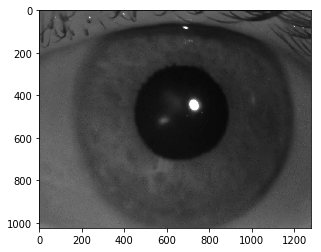

In [53]:

#testing on one image
test_frame ='video_frames/frame221.jpg'
img = get_image_mat(test_frame)
show_image(img)
print(img)
print(img.mean(axis=0).mean())


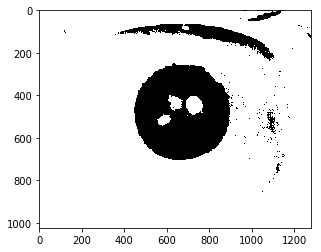

In [54]:
threshold = img.mean(axis=0).mean()*0.62
img = get_binary_image_mat(test_frame,threshold)
show_image(img)

485.104221568
center =  [ 485.10422157  675.56358016]
angle of rotation =  0.535754322396
axes =  [ 219.16965613  227.53256039]
area =  156665.674495
radius =  223.311963445


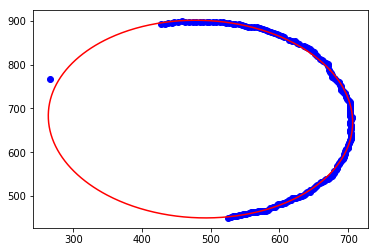

In [55]:
test_estimate_center = np.array([550,630])
test_estimate_radius = 230

test_estimate_a = test_estimate_radius
test_estimate_b = test_estimate_radius

points = find_edge_points(test_estimate_center,test_estimate_radius,img)
a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]
py.scatter(x,y, color="blue")



eye = fitEllipse(x,y)
center = ellipse_center(eye)

if isinstance(center[0], complex):
    center = test_estimate_center
    r = test_estimate_radius
    a = test_estimate_a
    b = test_estimate_b  
    
else:
    phi = ellipse_angle_of_rotation2(eye)
    axes = ellipse_axis_length(eye)
    a, b = axes
    area = np.pi*a*b
    r = np.sqrt(a*b)


print(center[0])
print ("center = ",  center)
print ("angle of rotation = ",  phi)
print ("axes = ", axes)
print ("area = ", area)
print ("radius = ", r)



R = np.arange(0,2*np.pi, 0.01)
xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
py.plot(xx,yy, color = 'red')


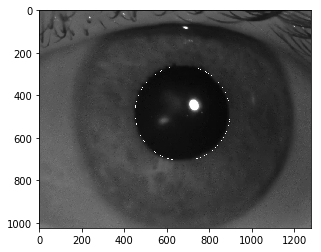

In [56]:
show_circle_img = get_image_mat(test_frame)
add_circle(show_circle_img,center,r,255)
#add_ellipse(show_circle_img,center,a,b,255)
show_image(show_circle_img)

In [111]:

radius_data = []


estimate_center = np.array([550,630])


estimate_radius = 230

estimate_a = test_estimate_radius
estimate_b = test_estimate_radius


for i in range(1,n_frame+1):

    if (i > 415) and (i < 489):
        estimate_center = np.array([550,730])
    elif (i > 490) and (i < 607):
        estimate_center = np.array([550,630])
    elif (i > 608) and (i < 1448):
        estimate_center = np.array([600,700])
    elif (i > 1447) and (i < 1557):
        estimate_center = np.array([410,600])
    elif (i > 1556) and (i < 2101):
        estimate_center = np.array([470,620])
    elif (i > 2100) and ( i < 2275):
        estimate_center = np.array([500,630])
    elif (i > 2274) and (i < 2541):
        estimate_center = np.array([500,700])
    elif (i > 2540) and (i < 2595):
        estimate_center = np.array([400,600])
    elif( i > 2594) and (i< 2872):
        estimate_center = np.array([500,600])
    elif (i> 2871) and (i < 3191):
        estimate_center = np.array([400,600])
    elif (i> 3190) and (i < 3309):
        estimate_center = np.array([450,600])
    elif (i > 3308):
        estimate_center = np.array([400,550])



    original_img = get_image_mat(input_frame.format(i))
    threshold = original_img.mean(axis=0).mean()
    
    print("FRAME", i)
    print("Prev thres:", threshold)


    
    
    
    if (i > 528) and (i < 590):
        threshold *= 0.76
    elif (i >609) and (i < 1184):
        threshold *= 0.52
    elif (i > 2000) and (i < 2539):
        threshold *=0.55
    elif (i > 2540) and (i< 2595):
        threshold *= 0.65
    elif (i> 2594) and (i < 2873):
        threshold *= 0.4
    elif (i> 2872) and (i< 2974):
        threshold *=0.45
        
    elif (i > 2973):
        threshold *= 0.6
    else:
        threshold *= 0.62

            
    
    print("New thres:", threshold)
    
#    print(threshold)
    
    img = get_binary_image_mat(input_frame.format(i),threshold)
    
    points = find_edge_points(estimate_center,estimate_radius,img)

    if (len(points)>1):
        print(len(points))
        a_points = np.array(points)
        x = a_points[:, 0]
        y = a_points[:, 1]
        eye = fitEllipse(x,y)
        center = ellipse_center(eye)
        if isinstance(center[0], complex):
            center = estimate_center
            r = estimate_radius
            a = estimate_a
            b = estimate_b        
        else:
            phi = ellipse_angle_of_rotation2(eye)
            axes = ellipse_axis_length(eye)
            a, b = axes
            area = np.pi*a*b
            r = np.sqrt(a*b)
        

    #x-------------------------------------------------------------
    # In the case of blinking, bad detection, or complex
    # 451 - 464: Detection did not work with any threshold - returned an IndexError
    use_previous_frame = [419,420,421,422,498,499, 593, 594, 595, 596, 597,
                         610,611,612,613,614,
                         621,622,623,624,625,626,
                         656,657,658,
                         684,685,686,687,
                         711,712,713,714,715,716,717,718,719,720,721,722,
                         728,729,730,731,732,733,734,735,736,737,
                         751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,
                          771,772,773,774,775,776,777,778,779,780,781,782,783,784,
                         1277,1278, 1552, 1553, 1554,1555, 1556,
                         1650,1651,1652,1653,1654,1655, 1659, 1727,1728,1729,1730,1731,1732,1733,1734,
                         1735,1736,1737,1738,1739,1740,1741, 1760,
                         1786,1787,1788,1881,1882, 2576, 2577, 2578, 2579, 2580,2581,2582,2583,2584,2603,2604,2605,2619,2626,
                          2872,2953,2969,2971,3185,3344,3345,3346,3423,3424,3425,3426,3427,3428,3471,3472,3473]


    if (i in use_previous_frame) or (len(points)==0) or isNaN(r) or isNaN(center[0]):
        if i in use_previous_frame:
            print(i,"In use_previous_Frame")
        if len(points)==0:
            print(i,"Points empty")
        if isNaN(r):
            print(i,"isNaN(r) True")
        if isNaN(center[0]):
            print(i,"IsNaN(center[0]) True")
            

            
        r = prev_radius
        center = prev_center
        a = prev_a
        b = prev_b
        threshold = prev_threshold


    else:
        print(i, "Else statement")
        prev_radius = r
        prev_center = center
        prev_a = a
        prev_b = b
        prev_threshold = threshold
    

    radius_data.append(r)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        save_image(original_img,center,r,a,b,phi,output_frame.format(i)) 
        
export_to_csv(radius_data)

FRAME 1
Prev thres: 51.6113105774
New thres: 31.999012558


220
1 Else statement
FRAME 2
Prev thres: 51.6113105774
New thres: 31.999012558


220
2 Else statement
FRAME 3
Prev thres: 51.611227417
New thres: 31.9989609985


216
3 Else statement
FRAME 4
Prev thres: 51.4395378113
New thres: 31.892513443


220
4 Else statement
FRAME 5
Prev thres: 51.7772499084
New thres: 32.1018949432


226
5 Else statement
FRAME 6
Prev thres: 51.4630348206
New thres: 31.9070815887


222
6 Else statement
FRAME 7
Prev thres: 51.5609458923
New thres: 31.9677864532


202
7 Else statement
FRAME 8
Prev thres: 51.4783447266
New thres: 31.9165737305


218
8 Else statement
FRAME 9
Prev thres: 51.114377594
New thres: 31.6909141083


211
9 Else statement
FRAME 10
Prev thres: 51.027545929
New thres: 31.637078476


230
10 Else statement
FRAME 11
Prev thres: 51.2735069275
New thres: 31.789574295


223
11 Else statement
FRAME 12
Prev thres: 51.0582481384
New thres: 31.6561138458


221
12 Else statement
FRAME 13
Prev thres: 51.0815895081
New thres: 31.670585495


227
13 Else statement
FRAME 14
Prev thres: 50.9609832764
New thres: 31.5958096313


226
14 Else statement
FRAME 15
Prev thres: 50.9907028198
New thres: 31.6142357483


230
15 Else statement
FRAME 16
Prev thres: 51.0505157471
New thres: 31.6513197632


204
16 Else statement
FRAME 17
Prev thres: 51.2361068726
New thres: 31.766386261


193
17 Else statement
FRAME 18
Prev thres: 51.3000137329
New thres: 31.8060085144


214
18 Else statement
FRAME 19
Prev thres: 51.0621559143
New thres: 31.6585366669


203
19 Else statement
FRAME 20
Prev thres: 50.7066368103
New thres: 31.4381148224


230
20 Else statement
FRAME 21
Prev thres: 51.0112190247
New thres: 31.6269557953


223
21 Else statement
FRAME 22
Prev thres: 51.1058364868
New thres: 31.6856186218


217
22 Else statement
FRAME 23
Prev thres: 51.4860290527
New thres: 31.9213380127


213
23 Else statement
FRAME 24
Prev thres: 50.9347610474
New thres: 31.5795518494


207
24 Else statement
FRAME 25
Prev thres: 51.0545562744
New thres: 31.6538248901


232
25 Else statement
FRAME 26
Prev thres: 51.0353897095
New thres: 31.6419416199


227
26 Else statement
FRAME 27
Prev thres: 51.2819152832
New thres: 31.7947874756


219
27 Else statement
FRAME 28
Prev thres: 52.3755119324
New thres: 32.4728173981


208
28 Else statement
FRAME 29
Prev thres: 51.9328201294
New thres: 32.1983484802


200
29 Else statement
FRAME 30
Prev thres: 51.5973342896
New thres: 31.9903472595


220
30 Else statement
FRAME 31
Prev thres: 51.9433273315
New thres: 32.2048629456


193
31 Else statement
FRAME 32
Prev thres: 52.0837982178
New thres: 32.291954895


201
32 Else statement
FRAME 33
Prev thres: 52.174798584
New thres: 32.3483751221


207
33 Else statement
FRAME 34
Prev thres: 52.6717315674
New thres: 32.6564735718


203
34 Else statement
FRAME 35
Prev thres: 52.4497261047
New thres: 32.5188301849


216
35 Else statement
FRAME 36
Prev thres: 52.6970916748
New thres: 32.6721968384


207
36 Else statement
FRAME 37
Prev thres: 52.7599723816
New thres: 32.7111828766


211
37 Else statement
FRAME

 38
Prev thres: 52.6259384155
New thres: 32.6280818176
196
38 Else statement
FRAME 39
Prev thres: 52.7930900574
New thres: 32.7317158356


198
39 Else statement
FRAME 40
Prev thres: 53.1408103943
New thres: 32.9473024445


220
40 Else statement
FRAME 41
Prev thres: 53.3458145142
New thres: 33.0744049988


209
41 Else statement
FRAME 42
Prev thres: 53.0338745117
New thres: 32.8810021973


207
42 Else statement
FRAME 43
Prev thres: 53.0737220764
New thres: 32.9057076874


204
43 Else statement
FRAME 44
Prev thres: 52.9100921631
New thres: 32.8042571411


201
44 Else statement
FRAME 45
Prev thres: 52.9645370483
New thres: 32.83801297


213
45 Else statement
FRAME 46
Prev thres: 53.1612075806
New thres: 32.9599487


196
46 Else statement
FRAME

 47
Prev thres: 53.1044288635
New thres: 32.9247458954
198
47 Else statement
FRAME 48
Prev thres: 53.1109848022
New thres: 32.9288105774


201
48 Else statement
FRAME 49
Prev thres: 52.9621505737
New thres: 32.8365333557


195
49 Else statement
FRAME 50
Prev thres: 52.6190666199
New thres: 32.6238213043


212
50 Else statement
FRAME 51
Prev thres: 52.8144538879
New thres: 32.7449614105


180
51 Else statement
FRAME 52
Prev thres: 52.393031311
New thres: 32.4836794128


191
52 Else statement
FRAME 53
Prev thres: 52.4390464783
New thres: 32.5122088165


201
53 Else statement
FRAME 54
Prev thres: 52.679901123
New thres: 32.6615386963


195
54 Else statement
FRAME 55
Prev thres: 52.6184822083
New thres: 32.6234589691


212
55 Else statement
FRAME 56
Prev thres: 52.4845222473
New thres: 32.5404037933


204
56 Else statement
FRAME 57
Prev thres: 52.5931671143
New thres: 32.6077636108


206
57 Else statement
FRAME 58
Prev thres: 52.4911979675
New thres: 32.5445427399


204
58 Else statement
FRAME 59
Prev thres: 52.4685287476
New thres: 32.5304878235


196
59 Else statement
FRAME 60
Prev thres: 53.2035797119
New thres: 32.9862194214


210
60 Else statement
FRAME 61
Prev thres: 52.9470993042
New thres: 32.8272015686


198
61 Else statement
FRAME 62
Prev thres: 52.7855628967
New thres: 32.727048996


193
62 Else statement
FRAME 63
Prev thres: 52.7916748047
New thres: 32.7308383789


195
63 Else statement
FRAME 64
Prev thres: 52.6239204407
New thres: 

32.6268306732
190
64 Else statement
FRAME 65
Prev thres: 52.8661933899
New thres: 32.7770399017


201
65 Else statement
FRAME 66
Prev thres: 52.9695381165
New thres: 32.8411136322


192
66 Else statement
FRAME 67
Prev thres: 52.8600723267
New thres: 32.7732448425


191
67 Else statement
FRAME 68
Prev thres: 52.6657814026
New thres: 32.6527844696


199
68 Else statement
FRAME 69
Prev thres: 52.1929969788
New thres: 32.3596581268


194
69 Else statement
FRAME 70
Prev thres: 51.8974494934
New thres: 32.1764186859


213
70 Else statement
FRAME 71
Prev thres: 52.1062202454
New thres: 32.3058565521


202
71 Else statement
FRAME 72
Prev thres: 52.0459030151
New thres: 32.2684598694


208
72 Else statement
FRAME 73
Prev thres: 52.0060600281
New thres: 32.2437572174


202
73 Else statement
FRAME 74
Prev thres: 51.9994194031
New thres: 32.2396400299


202
74 Else statement
FRAME 75
Prev thres: 52.2804290771
New thres: 32.4138660278


220
75 Else statement
FRAME 76
Prev thres: 52.1417671204
New thres: 32.3278956146


209
76 Else statement
FRAME 77
Prev thres: 51.9157836914
New thres: 32.1877858887


216
77 Else statement
FRAME 78
Prev thres: 51.9675559998
New thres: 32.2198847198


216
78 Else statement
FRAME 79
Prev thres: 51.8175331116
New thres: 32.1268705292


209
79 Else statement
FRAME 80
Prev thres: 51.7916618347
New thres: 32.1108303375


223
80 Else statement
FRAME 81
Prev thres: 51.9342018127
New thres: 32.1992051239


220
81 Else statement
FRAME 82
Prev thres: 51.9541542053
New thres: 32.2115756073


215
82 Else statement
FRAME 83
Prev thres: 52.1297080994
New thres: 32.3204190216


221
83 Else statement
FRAME 84
Prev thres: 52.3203994751
New thres: 32.4386476746


191
84 Else statement
FRAME 85
Prev thres: 52.8309242249
New thres: 32.7551730194


210
85 Else statement
FRAME 86
Prev thres: 52.7396583557
New thres: 32.6985881805


194
86 Else statement
FRAME 87
Prev thres: 52.6308395386
New thres: 32.6311205139


191
87 Else statement
FRAME 88
Prev thres: 52.7402183533
New thres: 32.698935379


202
88 Else statement
FRAME 89
Prev thres: 52.5245155334
New thres: 32.5651996307


203
89 Else statement
FRAME 90
Prev thres: 52.0801116943
New thres: 32.2896692505


218
90 Else statement
FRAME 91
Prev thres: 52.3941925049
New thres: 32.484399353


199
91 Else statement
FRAME 92
Prev thres: 52.3582214355
New thres: 32.46209729


188
92 Else statement
FRAME 93
Prev thres: 52.3538818359
New thres: 32.4594067383


192
93 Else statement
FRAME 94
Prev thres: 52.2748809814
New thres: 32.4104262085


191
94 Else statement
FRAME 95
Prev thres: 52.300756073
New thres: 32.4264687653


216
95 Else statement
FRAME 96
Prev thres: 52.4089630127
New thres: 32.4935570679


200
96 Else statement
FRAME 97
Prev thres: 52.2860786438
New thres: 32.4173687592


199
97 Else statement
FRAME 98
Prev thres: 52.3155754089
New thres: 32.4356567535


204
98 Else statement
FRAME 99
Prev thres: 52.2726150513
New thres: 32.4090213318


209
99 Else statement
FRAME 100
Prev thres: 52.3016227722
New thres: 32.4270061188


217
100 Else statement
FRAME 101
Prev thres: 52.3386665344
New thres: 32.4499732513


207
101 Else statement
FRAME 102
Prev thres: 52.280670929
New thres: 32.414015976


204
102 Else statement
FRAME 103
Prev thres: 52.3128044128
New thres: 32.433938736


208
103 Else statement
FRAME 104
Prev thres: 52.1169532776
New thres: 32.3125110321


203
104 Else statement
FRAME 105
Prev thres: 51.920349884
New thres: 32.1906169281


221
105 Else statement
FRAME 106
Prev thres: 52.334979248
New thres: 32.4476871338


203
106 Else statement
FRAME

 107
Prev thres: 52.362322998
New thres: 32.4646402588
201
107 Else statement
FRAME 108
Prev thres: 52.2891738892
New thres: 32.4192878113


207
108 Else statement
FRAME 109
Prev thres: 52.3980911255
New thres: 32.4868164978


201
109 Else statement
FRAME 110
Prev thres: 51.8885231018
New thres: 32.1708843231


223
110 Else statement
FRAME 111
Prev thres: 52.3565818787
New thres: 32.4610807648


209
111 Else statement
FRAME 112
Prev thres: 52.3910263062
New thres: 32.4824363098


209
112 Else statement
FRAME 113
Prev thres: 52.3073997498
New thres: 32.4305878448


209
113 Else statement
FRAME 114
Prev thres: 52.2459609985
New thres: 32.3924958191


184
114 Else statement
FRAME 115
Prev thres: 52.0848175049
New thres: 32.292586853


220
115 Else statement
FRAME 116
Prev thres: 52.4088356018
New thres: 32.4934780731


207
116 Else statement
FRAME 117
Prev thres: 52.2634910583
New thres: 32.4033644562


205
117 Else statement
FRAME 118
Prev thres: 52.3586524963
New thres: 32.4623645477


204
118 Else statement
FRAME 119
Prev thres: 52.2755065918
New thres: 32.4108140869


203
119 Else statement
FRAME 120
Prev thres: 51.9749061584
New thres: 32.2244418182


224
120 Else statement
FRAME 121
Prev thres: 52.1891120911
New thres: 32.3572494965


204
121 Else statement
FRAME 122
Prev thres: 52.0915641785
New thres: 32.2967697906


197
122 Else statement
FRAME 123
Prev thres: 52.1963600159
New thres: 32.3617432098


207
123 Else statement
FRAME 124
Prev thres: 52.0913726807
New thres: 32.296651062


201
124 Else statement
FRAME 125
Prev thres: 52.0924919128
New thres: 32.297344986


221
125 Else statement
FRAME 126
Prev thres: 52.2302055359
New thres: 32.3827274323


207
126 Else statement
FRAME 127
Prev thres: 52.2079872131
New thres: 32.3689520721


207
127 Else statement
FRAME

 128
Prev thres: 52.2219184875
New thres: 32.3775894623
204
128 Else statement
FRAME 129
Prev thres: 52.3102485657
New thres: 32.4323541107


211
129 Else statement
FRAME 130
Prev thres: 52.5913101196
New thres: 32.6066122742


226
130 Else statement
FRAME 131
Prev thres: 52.601360321
New thres: 32.612843399


198
131 Else statement
FRAME 132
Prev thres: 52.4905784607
New thres: 32.5441586456


205
132 Else statement
FRAME 133
Prev thres: 52.6834510803
New thres: 32.6637396698


203
133 Else statement
FRAME

 134
Prev thres: 52.5469329834
New thres: 32.5790984497
208
134 Else statement
FRAME 135
Prev thres: 52.6142753601
New thres: 32.6208507233


222
135 Else statement
FRAME 136
Prev thres: 52.6407157898
New thres: 32.6372437897


208
136 Else statement
FRAME 137
Prev thres: 52.5135375977
New thres: 32.5583933105


210
137 Else statement
FRAME 138
Prev thres: 52.6770698547
New thres: 32.6597833099


209
138 Else statement
FRAME 139
Prev thres: 53.3141319275
New thres: 33.054761795


178
139 Else statement
FRAME 140
Prev thres: 53.2697105408
New thres: 33.0272205353


210
140 Else statement
FRAME 141
Prev thres: 53.3964950562
New thres: 33.1058269348


192
141 Else statement
FRAME 142
Prev thres: 53.3698051453
New thres: 33.0892791901


185
142 Else statement
FRAME 143
Prev thres: 53.3448028564
New thres: 33.073777771


180
143 Else statement
FRAME 144
Prev thres: 53.5369880676
New thres: 33.1929326019


173
144 Else statement
FRAME 145
Prev thres: 53.0342895508
New thres: 32.8812595215


197
145 Else statement
FRAME 146
Prev thres: 53.4949180603
New thres: 33.1668491974


178
146 Else statement
FRAME 147
Prev thres: 53.4781471252
New thres: 33.1564512177


179
147 Else statement
FRAME 148
Prev thres: 53.3413795471
New thres: 33.0716553192


191
148 Else statement
FRAME 149
Prev thres: 53.3861381531


New thres: 33.0994056549
176
149 Else statement
FRAME 150
Prev thres: 53.2699623108
New thres: 33.0273766327


206
150 Else statement
FRAME 151
Prev thres: 53.4902076721
New thres: 33.1639287567


191
151 Else statement
FRAME 152
Prev thres: 53.2962593079
New thres: 33.0436807709


181
152 Else statement
FRAME

 153
Prev thres: 53.3564842224
New thres: 33.0810202179
185
153 Else statement
FRAME 154
Prev thres: 53.2078720093
New thres: 32.9888806458


169
154 Else statement
FRAME 155
Prev thres: 53.2742469788
New thres: 33.0300331268


197
155 Else statement
FRAME

 156
Prev thres: 53.5165786743
New thres: 33.1802787781
188
156 Else statement
FRAME 157
Prev thres: 53.4103630066
New thres: 33.1144250641


179
157 Else statement
FRAME 158
Prev thres: 53.4942382813
New thres: 33.1664277344


185
158 Else statement
FRAME 159
Prev thres: 53.4594573975
New thres: 33.1448635864


159
159 Else statement
FRAME 160
Prev thres: 53.1203697205
New thres: 32.9346292267


192
160 Else statement
FRAME 161
Prev thres: 53.4387664795
New thres: 33.1320352173


181
161 Else statement
FRAME 162
Prev thres: 53.4306083679
New thres: 33.1269771881


183
162 Else statement
FRAME 163
Prev thres: 53.3823936462
New thres: 33.0970840607


182
163 Else statement
FRAME 164
Prev thres: 53.3968063354
New thres: 33.106019928


166
164 Else statement
FRAME 165
Prev thres: 53.4609527588
New thres: 33.1457907104


200
165 Else statement
FRAME 166
Prev thres: 53.6549713135
New thres: 33.2660822144


177
166 Else statement
FRAME 167
Prev thres: 53.5866500854
New thres: 33.223723053


176
167 Else statement
FRAME 168
Prev thres: 52.8014198303
New thres: 32.7368802948


196
168 Else statement
FRAME 169
Prev thres: 52.8306877136
New thres: 32.7550263824


174
169 Else statement
FRAME 170
Prev thres: 52.7867759705
New thres: 32.7278011017


218
170 Else statement
FRAME 171
Prev thres: 52.766947937
New thres: 32.7155077209


189
171 Else statement
FRAME 172
Prev thres: 52.9504714966
New thres: 32.8292923279


192
172 Else statement
FRAME 173
Prev thres: 53.0927490234
New thres: 32.9175043945


184
173 Else statement
FRAME

 174
Prev thres: 53.2323402405
New thres: 33.0040509491
149
174 Else statement
FRAME 175
Prev thres: 52.7489936829
New thres: 32.7043760834


227
175 Else statement
FRAME 176
Prev thres: 53.2190887451
New thres: 32.995835022


181
176 Else statement
FRAME 177
Prev thres: 53.0453681946
New thres: 32.8881282806


202
177 Else statement
FRAME 178
Prev thres: 53.2575637817
New thres: 33.0196895447


186
178 Else statement
FRAME 179
Prev thres: 53.163508606
New thres: 32.9613753357


147
179 Else statement
FRAME 180
Prev thres: 52.9533370972
New thres: 32.8310690002


231
180 Else statement
FRAME 181
Prev thres: 53.181476593
New thres: 32.9725154877


203
181 Else statement
FRAME 182
Prev thres: 53.2539260864
New thres: 

33.0174341736
189
182 Else statement
FRAME 183
Prev thres: 53.4750572205
New thres: 33.1545354767


179
183 Else statement
FRAME 184
Prev thres: 53.5001594543
New thres: 33.1700988617


134
184 Else statement
FRAME 185
Prev thres: 53.3177619934
New thres: 33.0570124359


231
185 Else statement
FRAME 186
Prev thres: 53.4159881592
New thres: 33.1179126587


188
186 Else statement
FRAME 187
Prev thres: 53.5719444275
New thres: 33.214605545


167
187 Else statement
FRAME 188
Prev thres: 53.8135536194
New thres: 33.364403244


184
188 Else statement
FRAME

 189
Prev thres: 53.4677627563
New thres: 33.1500129089
151
189 Else statement
FRAME 190
Prev thres: 53.2873252869
New thres: 33.0381416779


224
190 Else statement
FRAME 191
Prev thres: 53.6355766296
New thres: 33.2540575104


189
191 Else statement
FRAME 192
Prev thres: 53.4044250488
New thres: 33.1107435303


203
192 Else statement
FRAME 193
Prev thres: 53.582119751
New thres: 33.2209142456


189
193 Else statement
FRAME 194
Prev thres: 53.1854316711
New thres: 32.9749676361


162
194 Else statement
FRAME

 195
Prev thres: 53.1528396606
New thres: 32.9547605896
208
195 Else statement
FRAME 196
Prev thres: 53.3628265381
New thres: 33.0849524536


193
196 Else statement
FRAME 197
Prev thres: 53.5000282288
New thres: 33.1700175018


200
197 Else statement
FRAME 198
Prev thres: 53.3100738525
New thres: 33.0522457886


194
198 Else statement
FRAME 199
Prev thres: 53.5120445251
New thres: 33.1774676056


195
199 Else statement
FRAME 200
Prev thres: 53.3102493286
New thres: 33.0523545837


224
200 Else statement
FRAME 201
Prev thres: 53.442515564
New thres: 33.1343596497


202
201 Else statement
FRAME 202
Prev thres: 53.1366989136
New thres: 32.9447533264


205
202 Else statement
FRAME 203
Prev thres: 53.0247055054
New thres: 32.8753174133


205
203 Else statement
FRAME 204
Prev thres: 52.783380127
New thres: 32.7256956787


200
204 Else statement
FRAME 205
Prev thres: 53.0592948914
New thres: 32.8967628326


222
205 Else statement
FRAME 206
Prev thres: 53.3066207886
New thres: 33.0501048889


208
206 Else statement
FRAME 207
Prev thres: 53.1616638184
New thres: 32.9602315674


207
207 Else statement
FRAME 208
Prev thres: 53.0979797363
New thres: 32.9207474365


208
208 Else statement
FRAME

 209
Prev thres: 53.0388442993
New thres: 32.8840834656
200
209 Else statement
FRAME 210
Prev thres: 52.6203918457
New thres: 32.6246429443


212
210 Else statement
FRAME 211
Prev thres: 53.1508361816
New thres: 32.9535184326


205
211 Else statement
FRAME 212
Prev thres: 52.6515869141
New thres: 32.6439838867


206
212 Else statement
FRAME 213
Prev thres: 52.9765037537
New thres: 32.8454323273


206
213 Else statement
FRAME 214
Prev thres: 52.9667236328
New thres: 32.8393686523


198
214 Else statement
FRAME 215
Prev thres: 52.6178359985
New thres: 32.6230583191


215
215 Else statement
FRAME 216
Prev thres: 52.9259910583
New thres: 32.8141144562


213
216 Else statement
FRAME 217
Prev thres: 52.8152740479
New thres: 32.7454699097


209
217 Else statement
FRAME 218
Prev thres: 52.981186676
New thres: 32.8483357391


213
218 Else statement
FRAME 219
Prev thres: 52.9402053833
New thres: 32.8229273376


213
219 Else statement
FRAME 220
Prev thres: 53.130115509
New thres: 32.9406716156


219
220 Else statement
FRAME 221
Prev thres: 53.0086288452
New thres: 32.865349884


208
221 Else statement
FRAME 222
Prev thres: 53.0856590271
New thres: 32.9131085968


203
222 Else statement
FRAME 223
Prev thres: 53.2412902832
New thres: 33.0095999756


206
223 Else statement
FRAME

 224
Prev thres: 52.9408050537
New thres: 32.8232991333
211
224 Else statement
FRAME 225
Prev thres: 52.6252983093
New thres: 32.6276849518


225
225 Else statement
FRAME 226
Prev thres: 53.0640640259
New thres: 32.899719696


205
226 Else statement
FRAME 227
Prev thres: 52.996635437
New thres: 32.8579139709


210
227 Else statement
FRAME 228
Prev thres: 53.0461395264
New thres: 32.8886065063


206
228 Else statement
FRAME 229
Prev thres: 52.7202697754
New thres: 32.6865672607


205
229 Else statement
FRAME 230
Prev thres: 52.7632339478
New thres: 32.7132050476


226
230 Else statement
FRAME 231
Prev thres: 53.025668335
New thres: 32.8759143677


228
231 Else statement
FRAME 232
Prev thres: 52.8183792114
New thres: 32.7473951111


225
232 Else statement
FRAME 233
Prev thres: 52.7956924438
New thres: 32.7333293152


212
233 Else statement
FRAME 234
Prev thres: 52.7534057617
New thres: 32.7071115723


207
234 Else statement
FRAME 235
Prev thres: 52.7839416504
New thres: 32.7260438232


230
235 Else statement
FRAME 236
Prev thres: 52.888054657
New thres: 32.7905938873


216
236 Else statement
FRAME 237
Prev thres: 52.8028518677
New thres: 32.737768158


212
237 Else statement
FRAME 238
Prev thres: 52.8940910339
New thres: 32.794336441


220
238 Else statement
FRAME 239
Prev thres: 52.7516464233
New thres: 32.7060207825


224
239 Else statement
FRAME 240
Prev thres: 52.7187431335
New thres: 32.6856207428


235
240 Else statement
FRAME 241
Prev thres: 53.0730911255
New thres: 32.9053164978


223
241 Else statement
FRAME 242
Prev thres: 52.8809570312
New thres: 32.7861933594


222
242 Else statement
FRAME 243
Prev thres: 52.949471283
New thres: 32.8286721954


225
243 Else statement
FRAME 244
Prev thres: 52.836366272
New thres: 32.7585470886


222
244 Else statement
FRAME 245
Prev thres: 52.4015449524
New thres: 32.4889578705


238
245 Else statement
FRAME 246
Prev thres: 52.7217430115
New thres: 32.6874806671


229
246 Else statement
FRAME 247
Prev thres: 52.5539199829
New thres: 32.5834303894


229
247 Else statement
FRAME 248
Prev thres: 52.4744308472
New thres: 32.5341471252


232
248 Else statement
FRAME 249
Prev thres: 52.4415557861
New thres: 32.5137645874


233
249 Else statement
FRAME 250
Prev thres: 52.203225708
New thres: 32.365999939


243
250 Else statement
FRAME 251
Prev thres: 52.7539382935
New thres: 32.7074417419


227
251 Else statement
FRAME 252
Prev thres: 52.5548187256
New thres: 32.5839876099


228
252 Else statement
FRAME 253
Prev thres: 52.6967262268
New thres: 32.6719702606


232
253 Else statement
FRAME 254
Prev thres: 52.6150047302
New thres: 32.6213029327


228
254 Else statement
FRAME 255
Prev thres: 52.24401474
New thres: 32.3912891388


241
255 Else statement
FRAME 256
Prev thres: 52.3900917053
New thres: 32.4818568573


236
256 Else statement
FRAME 257
Prev thres: 52.6203361511
New thres: 32.6246084137


231
257 Else statement
FRAME 

258
Prev thres: 52.5382743835
New thres: 32.5737301178
233
258 Else statement
FRAME 259
Prev thres: 52.5036758423
New thres: 32.5522790222


228
259 Else statement
FRAME 260
Prev thres: 52.1334449768
New thres: 32.3227358856


242
260 Else statement
FRAME 261
Prev thres: 52.1956809998
New thres: 32.3613222198


235
261 Else statement
FRAME 262
Prev thres: 52.1358016968
New thres: 32.324197052


233
262 Else statement
FRAME 263
Prev thres: 52.2346969604
New thres: 32.3855121155


236
263 Else statement
FRAME 264
Prev thres: 52.6739181519
New thres: 32.6578292542


220
264 Else statement
FRAME 265
Prev thres: 52.795513916
New thres: 32.7332186279


224
265 Else statement
FRAME 266
Prev thres: 53.3647712708
New thres: 33.0861581879


224
266 Else statement
FRAME 267
Prev thres: 53.1020347595
New thres: 32.9232615509


224
267 Else statement
FRAME 268
Prev thres: 53.2305412292
New thres: 33.0029355621


228
268 Else statement
FRAME 269
Prev thres: 53.0307647705
New thres: 32.8790741577


225
269 Else statement
FRAME 270
Prev thres: 52.650403595
New thres: 32.6432502289


226
270 Else statement
FRAME 271
Prev thres: 52.6663841248
New thres: 32.6531581573


224
271 Else statement
FRAME 272
Prev thres: 52.7670188904
New thres: 32.715551712


223
272 Else statement
FRAME 273
Prev thres: 52.6760696411
New thres: 32.6591631775


225
273 Else statement
FRAME

 274
Prev thres: 52.7049163818
New thres: 32.6770481567
227
274 Else statement
FRAME 275
Prev thres: 53.0148902893
New thres: 32.8692319794


229
275 Else statement
FRAME 276
Prev thres: 52.9455001831
New thres: 32.8262101135


223
276 Else statement
FRAME 277
Prev thres: 52.8380493164
New thres: 32.7595905762


223
277 Else statement
FRAME 278
Prev thres: 52.8378952026
New thres: 32.7594950256


223
278 Else statement
FRAME

 279
Prev thres: 52.8200836182
New thres: 32.7484518433
220
279 Else statement
FRAME 280
Prev thres: 52.3270378113
New thres: 32.442763443


222
280 Else statement
FRAME 281
Prev thres: 52.7852905273
New thres: 32.726880127


220
281 Else statement
FRAME 282
Prev thres: 52.6551132202
New thres: 32.6461701965


224
282 Else statement
FRAME 283
Prev thres: 52.6493377686
New thres: 32.6425894165


221
283 Else statement
FRAME 284
Prev thres: 52.7748001099
New thres: 

32.7203760681
217
284 Else statement
FRAME 285
Prev thres: 52.3534507751
New thres: 32.4591394806


222
285 Else statement
FRAME 286
Prev thres: 52.8009651184
New thres: 32.7365983734


220
286 Else statement
FRAME 287
Prev thres: 52.6791847229
New thres: 32.6610945282


224
287 Else statement
FRAME 288
Prev thres: 52.2922286987
New thres: 32.4211817932


226
288 Else statement
FRAME 289
Prev thres: 52.6547233582
New thres: 32.6459284821


221
289 Else statement
FRAME 290
Prev thres: 52.1580741882
New thres: 32.3380059967


230
290 Else statement
FRAME 291
Prev thres: 52.5173080444
New thres: 32.5607309875


223
291 Else statement
FRAME 292
Prev thres: 52.5454528809
New thres: 32.5781807861


216
292 Else statement
FRAME 293
Prev thres: 52.4259246826
New thres: 32.5040733032


222
293 Else statement
FRAME 294
Prev thres: 52.3672218323
New thres: 32.467677536


218
294 Else statement
FRAME 295
Prev thres: 51.9665214539
New thres: 32.2192433014


228
295 Else statement
FRAME 296
Prev thres: 52.255909729
New thres: 32.398664032


223
296 Else statement
FRAME 297
Prev thres: 52.207485199
New thres: 32.3686408234


225
297 Else statement
FRAME 298
Prev thres: 52.3122909546
New thres: 32.4336203918


218
298 Else statement
FRAME

 299
Prev thres: 52.2779762268
New thres: 32.4123452606
216
299 Else statement
FRAME 300
Prev thres: 51.9118293762
New thres: 32.1853342133


226
300 Else statement
FRAME 301
Prev thres: 52.3336364746
New thres: 32.4468546143


222
301 Else statement
FRAME 302
Prev thres: 52.2309394836
New thres: 32.3831824799


220
302 Else statement
FRAME 303
Prev thres: 52.317074585
New thres: 32.4365862427


225
303 Else statement
FRAME 304
Prev thres: 52.148664093
New thres: 32.3321717377


220
304 Else statement
FRAME 305
Prev thres: 52.6363975525
New thres: 32.6345664825


230
305 Else statement
FRAME 306
Prev thres: 52.2310508728
New thres: 32.3832515411


226
306 Else statement
FRAME 307
Prev thres: 52.4224357605
New thres: 32.5019101715


225
307 Else statement
FRAME 308
Prev thres: 52.2987976074
New thres: 32.4252545166


224
308 Else statement
FRAME 309
Prev thres: 52.2845336914
New thres: 32.4164108887


229
309 Else statement
FRAME 310
Prev thres: 52.4352607727
New thres: 32.5098616791


237
310 Else statement
FRAME 311
Prev thres: 52.3840209961
New thres: 32.4780930176


235
311 Else statement
FRAME 312
Prev thres: 52.3669792175
New thres: 32.4675271149


235
312 Else statement
FRAME 313
Prev thres: 52.371206665
New thres: 32.4701481323


237
313 Else statement
FRAME 314
Prev thres: 52.2954116821
New thres: 32.4231552429


232
314 Else statement
FRAME 315
Prev thres: 52.3426818848
New thres: 32.4524627686


238
315 Else statement
FRAME 316
Prev thres: 52.4813591003
New thres: 32.5384426422


229
316 Else statement
FRAME 317
Prev thres: 52.2574676514
New thres: 32.3996299438


229
317 Else statement
FRAME 318
Prev thres: 52.5775909424
New thres: 32.5981063843


230
318 Else statement
FRAME 319
Prev thres: 52.6234268188
New thres: 32.6265246277


231
319 Else statement
FRAME 320
Prev thres: 52.5272888184
New thres: 32.5669190674


242
320 Else statement
FRAME 321
Prev thres: 52.8469192505
New thres: 32.7650899353


238
321 Else statement
FRAME 322
Prev thres: 52.7997375488
New thres: 32.7358372803


236
322 Else statement
FRAME 323
Prev thres: 52.8980369568
New thres: 32.7967829132


234
323 Else statement
FRAME 324
Prev thres: 52.8434028625
New thres: 32.7629097748


237
324 Else statement
FRAME 325
Prev thres: 52.8412963867
New thres: 32.7616037598


248
325 Else statement
FRAME 326
Prev thres: 53.0103302002
New thres: 32.8664047241


242
326 Else statement
FRAME 327
Prev thres: 52.862461853
New thres: 32.7747263489


238
327 Else statement
FRAME 328
Prev thres: 52.8725036621
New thres: 32.7809522705


230
328 Else statement
FRAME 329
Prev thres: 52.5614326477
New thres: 32.5880882416


234
329 Else statement
FRAME 330
Prev thres: 52.4611129761
New thres: 32.5258900452


239
330 Else statement
FRAME 331
Prev thres: 52.579788208
New thres: 32.599468689


241
331 Else statement
FRAME 332
Prev thres: 52.3975204468
New thres: 32.486462677


234
332 Else statement
FRAME

 333
Prev thres: 52.604875946
New thres: 32.6150230865
233
333 Else statement
FRAME 334
Prev thres: 52.3607429504
New thres: 32.4636606293


225
334 Else statement
FRAME 335
Prev thres: 52.3050453186
New thres: 32.4291280975


246
335 Else statement
FRAME 336
Prev thres: 52.5967544556
New thres: 32.6099877625


241
336 Else statement
FRAME 337
Prev thres: 52.6136802673
New thres: 32.6204817657


233
337 Else statement
FRAME 338
Prev thres: 52.6263656616
New thres: 32.6283467102


232
338 Else statement
FRAME 339
Prev thres: 52.4748657227
New thres: 32.534416748


232
339 Else statement
FRAME 340
Prev thres: 52.5504486084
New thres: 32.5812781372


243
340 Else statement
FRAME 341
Prev thres: 52.4677818298


New thres: 32.5300247345
239
341 Else statement
FRAME 342
Prev thres: 52.4107452393
New thres: 32.4946620483


236
342 Else statement
FRAME 343
Prev thres: 52.7340805054
New thres: 32.6951299133


243
343 Else statement
FRAME 344
Prev thres: 52.5843940735
New thres: 32.6023243256


237
344 Else statement
FRAME 345
Prev thres: 52.8106803894
New thres: 32.7426218414


245
345 Else statement
FRAME 346
Prev thres: 52.6029029846
New thres: 32.6137998505


243
346 Else statement
FRAME 347
Prev thres: 52.7357940674
New thres: 32.6961923218


242
347 Else statement
FRAME 348
Prev thres: 52.2865135193
New thres: 32.417638382


244
348 Else statement
FRAME 349
Prev thres: 51.7357154846
New thres: 32.0761436005


244
349 Else statement
FRAME 350
Prev thres: 54.4292350769
New thres: 33.7461257477


264
350 Else statement
FRAME 351
Prev thres: 58.2532836914
New thres: 36.1170358887


218
351 Else statement
FRAME 352
Prev thres: 56.4554199219
New thres: 35.0023603516


256
352 Else statement
FRAME 353
Prev thres: 54.1816001892
New thres: 33.5925921173


250
353 Else statement
FRAME 354
Prev thres: 53.1321044922
New thres: 32.9419047852


232
354 Else statement
FRAME 355
Prev thres: 52.9481246948
New thres: 32.8278373108


234
355 Else statement
FRAME 356
Prev thres: 52.9157859802
New thres: 32.8077873077


213
356 Else statement
FRAME 357
Prev thres: 52.8178825378
New thres: 32.7470871735


213
357 Else statement
FRAME 358
Prev thres: 52.4650169373
New thres: 32.5283105011


217
358 Else statement
FRAME 359
Prev thres: 52.3199241638
New thres: 32.4383529816


213
359 Else statement
FRAME 360
Prev thres: 52.7316123962
New thres: 32.6935996857


228
360 Else statement
FRAME 361
Prev thres: 52.4209060669
New thres: 32.5009617615


223
361 Else statement
FRAME 362
Prev thres: 52.5567459106
New thres: 32.5851824646


223
362 Else statement
FRAME 363
Prev thres: 52.562625885
New thres: 32.5888280487


219
363 Else statement
FRAME 364
Prev thres: 52.2629981995
New thres: 32.4030588837


216
364 Else statement
FRAME 365
Prev thres: 52.4391357422
New thres: 32.5122641602


232
365 Else statement
FRAME 366
Prev thres: 52.4264770508
New thres: 32.5044157715


226
366 Else statement
FRAME

 367
Prev thres: 52.601071167
New thres: 32.6126641235
224
367 Else statement
FRAME 368
Prev thres: 52.5541145325
New thres: 32.5835510101


220
368 Else statement
FRAME 369
Prev thres: 52.4706535339
New thres: 32.531805191


217
369 Else statement
FRAME 370
Prev thres: 52.4542549133
New thres: 32.5216380463


233
370 Else statement
FRAME 371
Prev thres: 52.4430961609
New thres: 32.5147196198


228
371 Else statement
FRAME 372
Prev thres: 52.5096359253
New thres: 32.5559742737


225
372 Else statement
FRAME 373
Prev thres: 52.4210189819
New thres: 32.5010317688


224
373 Else statement
FRAME 374
Prev thres: 52.7979423523
New thres: 32.7347242584


218
374 Else statement
FRAME 375
Prev thres: 52.6208839417
New thres: 32.6249480438


230
375 Else statement
FRAME 376
Prev thres: 52.8565544128
New thres: 32.771063736


227
376 Else statement
FRAME

 377
Prev thres: 52.8028388977
New thres: 32.7377601166
222
377 Else statement
FRAME 378
Prev thres: 52.8453430176
New thres: 32.7641126709


226
378 Else statement
FRAME 379
Prev thres: 52.8353889465
New thres: 32.7579411469


224
379 Else statement
FRAME 380
Prev thres: 52.4812995911
New thres: 32.5384057465


231
380 Else statement
FRAME 381
Prev thres: 52.7960792542
New thres: 32.7335691376


230
381 Else statement
FRAME 382
Prev thres: 52.7711227417
New thres: 32.7180960999


220
382 Else statement
FRAME 383
Prev thres: 52.7370674133
New thres: 32.6969817963


222
383 Else statement
FRAME 384
Prev thres: 52.78335495
New thres: 32.725680069


227
384 Else statement
FRAME 385
Prev thres: 52.6910598755
New thres: 32.6684571228


230
385 Else statement
FRAME 386
Prev thres: 53.0713485718
New thres: 32.9042361145


226
386 Else statement
FRAME 387
Prev thres: 52.9327987671
New thres: 32.8183352356


224
387 Else statement
FRAME 388
Prev thres: 53.0625534058
New thres: 32.8987831116


229
388 Else statement
FRAME 389
Prev thres: 53.1648773193
New thres: 32.962223938


221
389 Else statement
FRAME 390
Prev thres: 53.2162895203
New thres: 32.9940995026


223
390 Else statement
FRAME 391
Prev thres: 53.2226295471
New thres: 32.9980303192


221
391 Else statement
FRAME 392
Prev thres: 53.2837654114
New thres: 33.0359345551


223
392 Else statement
FRAME 393
Prev thres: 53.2680541992
New thres: 33.0261936035


223
393 Else statement
FRAME 394
Prev thres: 53.1473381042
New thres: 32.9513496246


215
394 Else statement
FRAME 395
Prev thres: 53.4251609802
New thres: 33.1235998077


234
395 Else statement
FRAME 396
Prev thres: 53.2159233093
New thres: 32.9938724518


227
396 Else statement
FRAME 397
Prev thres: 52.5067939758
New thres: 32.554212265


226
397 Else statement
FRAME 398
Prev thres: 52.6459632874
New thres: 32.6404972382


228
398 Else statement
FRAME 399
Prev thres: 52.1968955994
New thres: 32.3620752716


225
399 Else statement
FRAME 400


Prev thres: 52.6164802551
New thres: 32.6222177582
235
400 Else statement
FRAME 401
Prev thres: 52.6038032532
New thres: 32.614358017


230
401 Else statement
FRAME 402
Prev thres: 52.4718353271
New thres: 32.5325379028


232
402 Else statement
FRAME 403
Prev thres: 52.2834747314
New thres: 32.4157543335


234
403 Else statement
FRAME 404
Prev thres: 52.1645530701
New thres: 32.3420229034


232
404 Else statement
FRAME 405
Prev thres: 52.2819328308
New thres: 32.4147983551


242
405 Else statement
FRAME 406
Prev thres: 52.1989547729
New thres: 32.3633519592


237
406 Else statement
FRAME 407
Prev thres: 52.1505355835
New thres: 32.3333320618


231
407 Else statement
FRAME 408
Prev thres: 52.0275382996
New thres: 32.2570737457


230
408 Else statement
FRAME 409
Prev thres: 52.0671340942
New thres: 32.2816231384


240
409 Else statement
FRAME 410
Prev thres: 51.4994804382
New thres: 31.9296778717


242
410 Else statement
FRAME 411
Prev thres: 51.3518844604
New thres: 31.8381683655


238
411 Else statement
FRAME 412
Prev thres: 51.3335929871
New thres: 31.826827652


230
412 Else statement
FRAME 413
Prev thres: 50.9497276306
New thres: 31.588831131


233
413 Else statement
FRAME 414
Prev thres: 51.2611190796
New thres: 31.7818938293


227
414 Else statement
FRAME 415
Prev thres: 51.2041824341
New thres: 31.7465931091


241
415 Else statement
FRAME 416
Prev thres: 54.4129440308
New thres: 33.7360252991


169
416 Else statement
FRAME

 417
Prev thres: 55.3826576233
New thres: 34.3372477264
169
417 Else statement
FRAME 418
Prev thres: 54.3953132629
New thres: 33.725094223


179
418 Else statement
FRAME 419
Prev thres: 58.1597915649
New thres: 36.0590707703


173
419 In use_previous_Frame
FRAME 420
Prev thres: 60.5495613098
New thres: 37.5407280121


200
420 In use_previous_Frame
FRAME 421
Prev thres: 57.1182952881
New thres: 35.4133430786


183
421 In use_previous_Frame
FRAME

 422
Prev thres: 54.8498565674
New thres: 34.0069110718
172
422 In use_previous_Frame
FRAME 423
Prev thres: 53.9508888245
New thres: 33.4495510712


173
423 Else statement
FRAME 424
Prev thres: 53.1045211792
New thres: 32.9248031311


155
424 Else statement
FRAME 425
Prev thres: 52.5857910156
New thres: 32.6031904297


219
425 Else statement
FRAME 426
Prev thres: 52.6752937317
New thres: 32.6586821136


181
426 Else statement
FRAME 427
Prev thres: 53.0347229004
New thres: 32.8815281982


198
427 Else statement
FRAME 428
Prev thres: 53.0919334412
New thres: 32.9169987335


193
428 Else statement
FRAME 429
Prev thres: 53.7364631653
New thres: 33.3166071625


184
429 Else statement
FRAME 430
Prev thres: 55.7558624268
New thres: 34.5686347046


239
430 Else statement
FRAME 431
Prev thres: 55.8452308655
New thres: 34.6240431366


241
431 Else statement
FRAME 432
Prev thres: 53.4898345947
New thres: 33.1636974487


199
432 Else statement
FRAME 433
Prev thres: 53.1517608643
New thres: 32.9540917358


191
433 Else statement
FRAME 434
Prev thres: 52.2979949951
New thres: 32.424756897


181
434 Else statement
FRAME 435
Prev thres: 52.0122161865
New thres: 32.2475740356


225
435 Else statement
FRAME 436
Prev thres: 51.7584518433
New thres: 32.0902401428


199
436 Else statement
FRAME 437
Prev thres: 51.5227539063
New thres: 31.9441074219


202
437 Else statement
FRAME 438
Prev thres: 51.3857376099
New thres: 31.8591573181


203
438 Else statement
FRAME

 439
Prev thres: 51.1362052917
New thres: 31.7044472809
187
439 Else statement
FRAME 440
Prev thres: 51.2732925415
New thres: 31.7894413757


228
440 Else statement
FRAME 441
Prev thres: 51.2461021423
New thres: 31.7725833282


210
441 Else statement
FRAME 442
Prev thres: 51.2508621216
New thres: 31.7755345154


210
442 Else statement
FRAME 443
Prev thres: 51.2922103882
New thres: 31.8011704407


202
443 Else statement
FRAME 444
Prev thres: 51.2892127991
New thres: 31.7993119354


201
444 Else statement
FRAME 445
Prev thres: 51.2912185669
New thres: 31.8005555115


234
445 Else statement
FRAME 446
Prev thres: 51.4750061035
New thres: 31.9145037842


214
446 Else statement
FRAME 447
Prev thres: 51.4606300354
New thres: 31.9055906219


213
447 Else statement
FRAME 448
Prev thres: 52.0062461853
New thres: 32.2438726349


204
448 Else statement
FRAME 449
Prev thres: 52.1996284485
New thres: 32.3637696381


192
449 Else statement
FRAME 450
Prev thres: 52.7630599976
New thres: 32.7130971985


242
450 Else statement
FRAME 451
Prev thres: 52.1783447266
New thres: 32.3505737305


205
451 Else statement
FRAME 452
Prev thres: 52.2953849792
New thres: 32.4231386871


194
452 Else statement
FRAME 453
Prev thres: 52.1142616272
New thres: 32.3108422089


193
453 Else statement
FRAME 454
Prev thres: 52.044102478
New thres: 32.2673435364


184
454 Else statement
FRAME 455
Prev thres: 52.0217834473
New thres: 32.2535057373


233
455 Else statement
FRAME 456
Prev thres: 51.862437439
New thres: 32.1547112122


200
456 Else statement
FRAME 457
Prev thres: 52.1147529602
New thres: 32.3111468353


194
457 Else statement
FRAME 458
Prev thres: 52.2138824463
New thres: 32.3726071167


192
458 Else statement
FRAME

 459
Prev thres: 52.2397544861
New thres: 32.3886477814
170
459 Else statement
FRAME 460
Prev thres: 52.5151824951
New thres: 32.559413147


236
460 Else statement
FRAME 461
Prev thres: 52.9144721985
New thres: 32.8069727631


204
461 Else statement
FRAME 462
Prev thres: 53.1396507263
New thres: 32.9465834503


201
462 Else statement
FRAME 463
Prev thres: 53.2659507751
New thres: 33.0248894806


189
463 Else statement
FRAME 464
Prev thres: 53.5511245728
New thres: 33.2016972351


170
464 Else statement
FRAME 465
Prev thres: 53.8594337463
New thres: 33.3928489227


230
465 Else statement
FRAME

 466
Prev thres: 54.2318870544
New thres: 33.6237699738
207
466 Else statement
FRAME 467
Prev thres: 54.4305915833
New thres: 33.7469667816


203
467 Else statement
FRAME 468
Prev thres: 54.4157051086
New thres: 33.7377371674


203
468 Else statement
FRAME 469
Prev thres: 54.8397323608
New thres: 34.0006340637


168
469 Else statement
FRAME 470
Prev thres: 54.672618103
New thres: 33.8970232239


232
470 Else statement
FRAME 471
Prev thres: 54.7536613464
New thres: 33.9472700348


198
471 Else statement
FRAME 472
Prev thres: 55.1372596741
New thres: 34.1851009979


196
472 Else statement
FRAME 473
Prev thres: 55.2147033691
New thres: 34.2331160889


200
473 Else statement
FRAME 474
Prev thres: 55.2687072754
New thres: 34.2665985107


168
474 Else statement
FRAME 475
Prev thres: 55.089402771
New thres: 34.155429718


236
475 Else statement
FRAME 476
Prev thres: 55.65936203
New thres: 34.5088044586


188
476 Else statement
FRAME 477
Prev thres: 55.6214118958
New thres: 34.4852753754


198
477 Else statement
FRAME 478
Prev thres: 55.7238922119
New thres: 34.5488131714


189
478 Else statement
FRAME 479
Prev thres: 55.7903457642
New thres: 34.5900143738


168
479 Else statement
FRAME 480
Prev thres: 55.3074394226
New thres: 34.290612442


220
480 Else statement
FRAME 481
Prev thres: 55.7464851379
New thres: 34.5628207855


186
481 Else statement
FRAME 482
Prev thres: 55.7832084656
New thres: 34.5855892487


184
482 Else statement
FRAME

 483
Prev thres: 55.8129005432
New thres: 34.6039983368
182
483 Else statement
FRAME 484
Prev thres: 55.8637275696
New thres: 34.6355110931


180
484 Else statement
FRAME 485
Prev thres: 55.4353691101
New thres: 34.3699288483


216
485 Else statement
FRAME 486
Prev thres: 55.9283447266
New thres:

 34.6755737305
173
486 Else statement
FRAME 487
Prev thres: 55.8797828674
New thres: 34.6454653778


184
487 Else statement
FRAME 488
Prev thres: 56.04740448
New thres: 34.7493907776


184
488 Else statement
FRAME 489
Prev thres: 55.9536331177
New thres: 34.691252533


164
489 Else statement
FRAME 490
Prev thres: 55.9926780701
New thres: 34.7154604034


223
490 Else statement
FRAME 491
Prev thres: 56.3750465393
New thres: 34.9525288544


225
491 Else statement
FRAME 492
Prev thres: 56.1464813232
New thres: 34.8108184204


220
492 Else statement
FRAME 493
Prev thres: 56.3182723999
New thres: 34.9173288879


217
493 Else statement
FRAME 494
Prev thres: 56.2483802795
New thres: 34.8739957733


209
494 Else statement
FRAME 495
Prev thres: 55.7254585266
New thres: 34.5497842865


245
495 Else statement
FRAME 496
Prev thres: 56.3246398926
New thres: 34.9212767334


243
496 Else statement
FRAME 497
Prev thres: 55.709564209
New thres: 34.5399298096


221
497 Else statement
FRAME

 498
Prev thres: 57.6191764832
New thres: 35.7238894196
222
498 In use_previous_Frame
FRAME 499
Prev thres: 60.236075592
New thres: 37.3463668671


113
499 In use_previous_Frame
FRAME 500
Prev thres: 58.6019233704
New thres: 36.3331924896


242
500 Else statement
FRAME 501
Prev thres: 57.9362373352
New thres: 35.9204671478


256
501 Else statement
FRAME 502
Prev thres: 57.0259078979
New thres: 35.3560628967


239
502 Else statement
FRAME 503
Prev thres: 56.8996253967
New thres: 35.277767746


223
503 Else statement
FRAME 504
Prev thres: 56.3846809387
New thres: 34.958502182


212
504 Else statement
FRAME 505
Prev thres: 56.2735984802
New thres: 34.8896310577


256
505 Else statement
FRAME 506
Prev thres: 56.3526199341
New thres: 34.9386243591


248
506 Else statement
FRAME 507
Prev thres: 56.2271835327
New thres: 34.8608537903


225
507 Else statement
FRAME 508
Prev thres: 56.1632820129
New thres: 34.821234848


226
508 Else statement
FRAME 509
Prev thres: 55.9113548279
New thres: 34.6650399933


208
509 Else statement
FRAME 510
Prev thres: 56.171987915
New thres: 34.8266325073


250
510 Else statement
FRAME 511
Prev thres: 56.3778083801
New thres: 34.9542411957


235
511 Else statement
FRAME 512
Prev thres: 56.1137771606
New thres: 34.7905418396


228
512 Else statement
FRAME 513
Prev thres: 56.2600074768
New thres: 34.8812046356


223
513 Else statement
FRAME 514
Prev thres: 56.0530654907
New thres: 34.7529006042


219
514 Else statement
FRAME 515
Prev thres: 55.9400253296
New thres: 34.6828157043


256
515 Else statement
FRAME 516
Prev thres: 56.1439071655
New thres: 34.8092224426


236
516 Else statement
FRAME 517
Prev thres: 56.0088920593
New thres: 34.7255130768


230
517 Else statement
FRAME 518
Prev thres: 56.089679718
New thres: 34.7756014252


225
518 Else statement
FRAME 519
Prev thres: 56.0099189758
New thres: 34.726149765


212
519 Else statement
FRAME 520
Prev thres: 56.1130149841
New thres: 34.7900692902


260
520 Else statement
FRAME 521
Prev thres: 55.8362968445
New thres: 34.6185040436


246
521 Else statement
FRAME 522
Prev thres: 56.0557830811
New thres: 34.7545855103


240
522 Else statement
FRAME 523
Prev thres: 56.1037147522
New thres: 34.7843031464


223
523 Else statement
FRAME 524
Prev thres: 55.2752357483
New thres: 34.2706461639


206
524 Else statement
FRAME 525
Prev thres: 58.0431686401
New thres: 35.9867645569


248
525 Else statement
FRAME 526
Prev thres: 63.0951316833
New thres: 39.1189816437


110
526 Else statement
FRAME 527
Prev thres: 61.4380012512
New thres: 38.0915607758


143
527 Else statement
FRAME 528
Prev thres: 59.7497932434
New thres: 37.0448718109


108
528 Else statement
FRAME 529
Prev thres: 59.0184814453
New thres: 44.8540458984


58
529 Else statement
FRAME 530
Prev thres: 58.6257904053
New thres: 44.555600708


140
530 Else statement
FRAME 531
Prev thres: 58.1870521545
New thres: 44.2221596375


81
531 Else statement
FRAME 532
Prev thres: 57.5762519836
New thres: 43.7579515076


78
532 Else statement
FRAME 533
Prev thres: 57.1995819092
New thres: 43.471682251


77
533 Else statement
FRAME 534
Prev thres: 56.9228790283
New thres: 43.2613880615


61
534 Else statement
FRAME 535
Prev thres: 56.8518585205
New thres: 43.2074124756


174
535 Else statement
FRAME 536
Prev thres: 56.6397628784
New thres: 43.0462197876


86
536 Else statement
FRAME 537
Prev thres: 56.5472900391
New thres: 42.9759404297


94
537 Else statement
FRAME 538
Prev thres: 56.2680969238
New thres: 42.7637536621


90
538 Else statement
FRAME 539
Prev thres: 56.1443664551
New thres: 42.6697185059


88
539 Else statement
FRAME 540
Prev thres: 56.2091789246
New thres: 42.7189759827


196
540 Else statement
FRAME 541
Prev thres: 56.0348548889
New thres: 42.5864897156


104
541 Else statement
FRAME 542
Prev thres: 55.8706993103
New thres: 42.4617314758


97
542 Else statement
FRAME 543
Prev thres: 55.8829246521
New thres: 42.4710227356


100
543 Else statement
FRAME 544
Prev thres: 55.70340271
New thres: 42.3345860596


93
544 Else statement
FRAME 545
Prev thres: 55.6777709961
New thres: 42.315105957


181
545 Else statement
FRAME 546
Prev thres: 55.7320976257
New thres: 42.3563941956


125
546 Else statement
FRAME 547
Prev thres: 55.7246452332
New thres: 42.3507303772


122
547 Else statement
FRAME 548
Prev thres: 55.7173301697
New thres: 42.345170929


117
548 Else statement
FRAME 549
Prev thres: 55.6980697632
New thres: 42.33053302


105
549 Else statement
FRAME 550
Prev thres: 55.2457244873
New thres: 41.9867506104


214
550 Else statement
FRAME 551
Prev thres: 55.3440811157
New thres: 42.0615016479


95
551 Else statement
FRAME 552
Prev thres: 55.3691734314
New thres: 42.0805718079


96
552 Else statement
FRAME 553
Prev thres: 55.2184684753
New thres: 41.9660360413


108
553 Else statement
FRAME 554
Prev thres: 55.1563301086
New thres: 41.9188108826


97
554 Else statement
FRAME 555
Prev thres: 54.9346214294
New thres: 41.7503122864


204
555 Else statement
FRAME 556
Prev thres: 55.3427055359
New thres: 42.0604562073


129
556 Else statement
FRAME 557
Prev thres: 55.2431167603
New thres:

 41.9847687378
129
557 Else statement
FRAME 558
Prev thres: 54.9610862732
New thres: 41.7704255676


120
558 Else statement
FRAME 559
Prev thres: 54.9863616943
New thres: 41.7896348877


87
559 Else statement
FRAME 560
Prev thres: 54.8547042847
New thres: 41.6895752563


178
560 Else statement
FRAME 561
Prev thres: 54.9577804565
New thres: 41.767913147


116
561 Else statement
FRAME 562
Prev thres: 54.9486709595
New thres: 41.7609899292


133
562 Else statement
FRAME 563
Prev thres: 55.4091934204
New thres: 42.1109869995


118
563 Else statement
FRAME 564
Prev thres: 55.750504303
New thres: 42.3703832703


85
564 Else statement
FRAME 565
Prev thres: 55.4759147644
New thres: 42.1616952209


171
565 Else statement
FRAME 566
Prev thres: 56.1090126038
New thres: 42.6428495789


97
566 Else statement
FRAME 567
Prev thres: 55.6862365723
New thres: 42.3215397949


99
567 Else statement
FRAME 568
Prev thres: 55.7584381104
New thres: 42.3764129639


102
568 Else statement
FRAME 569
Prev thres: 55.7793830872
New thres: 42.3923311462


86
569 Else statement
FRAME 570
Prev thres: 55.0510986328
New thres: 41.8388349609


211
570 Else statement
FRAME 571
Prev thres: 55.3724754333
New thres: 42.0830813293


91
571 Else statement
FRAME 572
Prev thres: 55.2112251282
New thres: 41.9605310974


110
572 Else statement
FRAME 573
Prev thres: 55.2634307861
New thres: 42.0002073975


101
573 Else statement
FRAME 574
Prev thres: 55.2137191772
New thres: 41.9624265747


96
574 Else statement
FRAME 575
Prev thres: 55.4118537903
New thres: 42.1130088806


199
575 Else statement
FRAME 576
Prev thres: 55.4953804016
New thres: 42.1764891052


121
576 Else statement
FRAME 577
Prev thres: 55.31381073
New thres: 42.0384961548


115
577 Else statement
FRAME 578
Prev thres: 55.5081489563
New thres: 42.1861932068


117
578 Else statement
FRAME 579
Prev thres: 55.42371521
New thres: 42.1220235596


93
579 Else statement
FRAME 580
Prev thres: 54.9707450867
New thres: 41.7777662659


212
580 Else statement
FRAME 581
Prev thres: 55.466192627
New thres: 42.1543063965


130
581 Else statement
FRAME 582
Prev thres: 55.1880126953
New thres: 41.9428896484


136
582 Else statement
FRAME 583
Prev thres: 55.3231033325
New thres: 42.0455585327


118
583 Else statement
FRAME 584
Prev thres: 55.2080192566
New thres: 41.958094635


118
584 Else statement
FRAME 585
Prev thres: 54.6224807739
New thres: 41.5130853882


203
585 Else statement
FRAME 586
Prev thres: 54.8637023926
New thres: 41.6964138184


152
586 Else statement
FRAME 587
Prev thres: 54.6646911621
New thres: 41.5451652832


160
587 Else statement
FRAME 588
Prev thres: 54.592578125
New thres: 41.490359375


129
588 Else statement
FRAME 589
Prev thres: 54.2712135315
New thres: 41.2461222839


87
589 Else statement
FRAME 590
Prev thres: 54.1371284485


New thres: 33.5650196381
229
590 Else statement
FRAME 591
Prev thres: 54.9868415833
New thres: 34.0918417816


182
591 Else statement
FRAME 592
Prev thres: 60.6815856934
New thres: 37.6225831299


171
592 Else statement
FRAME 593
Prev thres: 73.0359237671
New thres: 45.2822727356


153
593 In use_previous_Frame
FRAME 594
Prev thres: 71.6245559692
New thres: 44.4072247009


170
594 In use_previous_Frame
FRAME 595
Prev thres: 68.1889945984
New thres: 42.277176651


213
595 In use_previous_Frame
FRAME 596
Prev thres: 65.7679603577
New thres: 40.7761354218


117
596 In use_previous_Frame
FRAME 597
Prev thres: 63.2004463196
New thres: 39.1842767181


158
597 In use_previous_Frame
FRAME 598
Prev thres: 62.3440109253
New thres: 38.6532867737


158
598 Else statement
FRAME

 599
Prev thres: 60.8940223694
New thres: 37.754293869
171
599 Else statement
FRAME 600
Prev thres: 61.5629501343
New thres: 38.1690290833


191
600 Else statement
FRAME 601
Prev thres: 60.6474578857
New thres: 37.6014238892


188
601 Else statement
FRAME 602
Prev thres: 60.0254570007
New thres: 37.2157833405


190
602 Else statement
FRAME 603
Prev thres: 59.8941436768
New thres: 37.1343690796


185
603 Else statement
FRAME 604
Prev thres: 59.2657249451
New thres: 36.7447494659


188
604 Else statement
FRAME 605
Prev thres: 59.1454650879
New thres: 36.6701883545


207
605 Else statement
FRAME 606
Prev thres: 59.2440681458
New thres: 36.7313222504


191
606 Else statement
FRAME 607
Prev thres: 58.9962394714
New thres: 36.5776684723


193
607 Else statement
FRAME 608
Prev thres: 58.9607177734
New thres: 36.5556450195


187
608 Else statement
FRAME 609
Prev thres: 60.3429374695
New thres: 37.4126212311


168
609 Else statement
FRAME 610
Prev thres: 65.4481285095
New thres: 34.033026825


248
610 In use_previous_Frame
FRAME 611
Prev thres: 78.8341567993
New thres: 40.9937615356


218
611 In use_previous_Frame
FRAME 612
Prev thres: 81.2803527832
New thres: 42.2657834473


203
612 In use_previous_Frame
FRAME 613
Prev thres: 71.7338127136
New thres: 37.3015826111


162
613 In use_previous_Frame
FRAME 614
Prev thres: 67.2719100952
New thres: 34.9813932495


127
614 In use_previous_Frame
FRAME

 615
Prev thres: 65.5406524658
New thres: 34.0811392822
214
615 Else statement
FRAME

 616
Prev thres: 65.3664794922
New thres: 33.9905693359
207
616 Else statement
FRAME 617
Prev thres: 65.0230476379
New thres: 33.8119847717


199
617 Else statement
FRAME 618
Prev thres: 64.299937439
New thres: 33.4359674683


203
618 Else statement
FRAME 619
Prev thres: 63.8224449158
New thres: 33.1876713562


185
619 Else statement
FRAME 620
Prev thres: 65.2430007935
New thres: 33.9263604126


240
620 Else statement
FRAME 621
Prev thres: 74.0090805054
New thres: 38.4847218628


185
621 In use_previous_Frame
FRAME 622
Prev thres: 84.6690185547
New thres: 44.0278896484


231
622 In use_previous_Frame
FRAME 623
Prev thres: 76.6231208801
New thres: 39.8440228577


198
623 In use_previous_Frame
FRAME 624
Prev thres: 69.4741264343
New thres: 36.1265457458


182
624 In use_previous_Frame
FRAME 625
Prev thres: 66.9366119385
New thres: 34.807038208


200
625 In use_previous_Frame
FRAME 626
Prev thres: 66.4543968201
New thres: 34.5562863464


180
626 In use_previous_Frame
FRAME 627
Prev thres: 65.9832611084
New thres: 34.3112957764


189
627 Else statement
FRAME 628
Prev thres: 65.4832099915
New thres: 34.0512691956


192
628 Else statement
FRAME 629
Prev thres: 64.6092018127
New thres: 33.5967849426


190
629 Else statement
FRAME 630
Prev thres: 64.0036376953
New thres: 33.2818916016


210
630 Else statement
FRAME 631
Prev thres: 64.0109703064
New thres: 33.2857045593


187
631 Else statement
FRAME 632
Prev thres: 63.9483596802
New thres: 33.2531470337


191
632 Else statement
FRAME 633
Prev thres: 63.5192504883
New thres: 33.0300102539


187
633 Else statement
FRAME 634
Prev thres: 63.3636810303
New thres: 32.9491141357


180
634 Else statement
FRAME 635
Prev thres: 62.3800643921
New thres: 32.4376334839


231
635 Else statement
FRAME 636
Prev thres: 62.3101448059
New thres: 32.4012752991


206
636 Else statement
FRAME 637
Prev thres: 61.8823272705
New thres: 32.1788101807


204
637 Else statement
FRAME 638
Prev thres: 61.6840660095
New thres: 32.075714325


208
638 Else statement
FRAME 639
Prev thres: 60.904473877
New thres: 31.670326416


215
639 Else statement
FRAME 640
Prev thres: 60.58228302
New thres: 31.5027871704


241
640 Else statement
FRAME 641
Prev thres: 60.345476532
New thres: 31.3796477966


226
641 Else statement
FRAME 642
Prev thres: 59.8067871094
New thres: 31.0995292969


227
642 Else statement
FRAME 643
Prev thres: 59.8170761108
New thres: 31.1048795776


229
643 Else statement
FRAME 644
Prev thres: 59.1289978027
New thres: 30.7470788574


235
644 Else statement
FRAME 645
Prev thres: 58.5218292236
New thres: 30.4313511963


252
645 Else statement
FRAME 646
Prev thres: 58.7058044434
New thres: 30.5270183105


243
646 Else statement
FRAME 647
Prev thres: 58.8716316223
New thres: 30.6132484436


239
647 Else statement
FRAME 648
Prev thres: 58.7830436707
New thres: 30.5671827087


245
648 Else statement
FRAME 649
Prev thres: 58.9662261963
New thres: 30.6624376221


238
649 Else statement
FRAME 650
Prev thres: 58.998399353
New thres: 30.6791676636


262
650 Else statement
FRAME 651
Prev thres: 59.0614196777
New thres: 30.7119382324


243
651 Else statement
FRAME 652
Prev thres: 58.9196937561
New thres: 30.6382407532


249
652 Else statement
FRAME 653
Prev thres: 58.518006897
New thres: 30.4293635864


251
653 Else statement
FRAME 654
Prev thres: 58.6601379395
New thres: 30.5032717285


249
654 Else statement
FRAME 655
Prev thres: 60.5283813477
New thres: 31.4747583008


246
655 Else statement
FRAME 656
Prev thres: 79.9818649292
New thres: 41.5905697632


263
656 In use_previous_Frame
FRAME 657
Prev thres: 90.8849723816
New thres: 47.2601856384


203
657 In use_previous_Frame
FRAME 658
Prev thres: 69.4896873474
New thres: 36.1346374207


172
658 In use_previous_Frame
FRAME 659
Prev thres: 64.291103363
New thres: 33.4313737488


164
659 Else statement
FRAME 660
Prev thres: 62.0530471802
New thres: 32.2675845337


214
660 Else statement
FRAME 661
Prev thres: 61.7694389343
New thres: 32.1201082458


196
661 Else statement
FRAME 662
Prev thres: 61.190713501
New thres: 31.8191710205


213
662 Else statement
FRAME 663
Prev thres: 59.9783447266
New thres: 31.1887392578


239
663 Else statement
FRAME 664
Prev thres: 59.4957267761
New thres: 30.9377779236


235
664 Else statement
FRAME 665
Prev thres: 58.7711479187
New thres: 30.5609969177


268
665 Else statement
FRAME 666
Prev thres: 58.8754386902
New thres: 30.6152281189


255
666 Else statement
FRAME 667
Prev thres: 58.6600624084
New thres: 30.5032324524


258
667 Else statement
FRAME 668
Prev thres: 58.2914657593
New thres: 30.3115621948


266
668 Else statement
FRAME 669
Prev thres: 58.4156066895
New thres: 30.3761154785


247
669 Else statement
FRAME 670
Prev thres: 57.5681884766
New thres: 29.9354580078


268
670 Else statement
FRAME 671
Prev thres: 57.8066581726
New thres: 30.0594622498


262
671 Else statement
FRAME 672
Prev thres: 57.8132026672
New thres: 30.062865387


254
672 Else statement
FRAME 673
Prev thres: 57.5168556213
New thres: 29.9087649231


263
673 Else statement
FRAME 674
Prev thres: 57.5945335388
New thres: 29.9491574402


255
674 Else statement
FRAME 675
Prev thres: 57.029234314
New thres: 29.6552018433


271
675 Else statement
FRAME 676
Prev thres: 57.1673095703
New thres: 29.7270009766


260
676 Else statement
FRAME 677
Prev thres: 57.0277511597
New thres: 29.654430603


264
677 Else statement
FRAME 678
Prev thres: 56.923223877
New thres: 29.600076416


264
678 Else statement
FRAME 679
Prev thres: 56.5007476807
New thres: 29.3803887939


265
679 Else statement
FRAME 680
Prev thres: 56.7159934998
New thres: 29.4923166199


271
680 Else statement
FRAME 681
Prev thres: 56.4004745483
New thres: 29.3282467651


253
681 Else statement
FRAME 682
Prev thres: 56.4936515808
New thres: 29.376698822


256
682 Else statement
FRAME 683
Prev thres: 58.6723678589
New thres: 30.5096312866


243
683 Else statement
FRAME 684
Prev thres: 75.2151069641
New thres: 39.1118556213


234
684 In use_previous_Frame
FRAME 685
Prev thres: 65.6076339722
New thres: 34.1159696655


231
685 In use_previous_Frame
FRAME 686
Prev thres: 63.7378417969
New thres: 33.1436777344


186
686 In use_previous_Frame
FRAME 687
Prev thres: 62.0636741638
New thres: 32.2731105652


194
687 In use_previous_Frame
FRAME 688
Prev thres: 60.7084434509
New thres: 31.5683905945


224
688 Else statement
FRAME 689
Prev thres: 60.2902877808
New thres: 31.350949646


217
689 Else statement
FRAME

 690
Prev thres: 59.475087738
New thres: 30.9270456238
268
690 Else statement
FRAME 691
Prev thres: 59.5622505188
New thres: 30.9723702698


241
691 Else statement
FRAME 692
Prev thres: 59.1642120361
New thres: 30.7653902588


247
692 Else statement
FRAME 693
Prev thres: 59.1707984924
New thres: 30.7688152161


250
693 Else statement
FRAME 694
Prev thres: 58.4583908081
New thres: 30.3983632202


248
694 Else statement
FRAME 695
Prev thres: 60.1121025085
New thres: 31.2582933044


263
695 Else statement
FRAME 696
Prev thres: 59.7835655212
New thres: 31.087454071


236
696 Else statement
FRAME 697
Prev thres: 59.5286270142
New thres: 30.9548860474


236
697 Else statement
FRAME 698
Prev thres: 59.1344459534
New thres: 30.7499118958


240
698 Else statement
FRAME 699
Prev thres: 59.1263519287
New thres: 30.7457030029


234
699 Else statement
FRAME 700
Prev thres: 58.9926200867
New thres: 30.6761624451


257
700 Else statement
FRAME 701
Prev thres: 59.324079895
New thres: 30.8485215454


229
701 Else statement
FRAME 702
Prev thres: 59.0486763
New thres: 30.705311676


229
702 Else statement
FRAME 703
Prev thres: 59.1331924438
New thres: 30.7492600708


241
703 Else statement
FRAME 704
Prev thres: 58.6471237183
New thres: 30.4965043335


232
704 Else statement
FRAME 705
Prev thres: 58.3825386047
New thres: 30.3589200745


249
705 Else statement
FRAME 706
Prev thres: 58.6310295105
New thres: 30.4881353455


235
706 Else statement
FRAME 707
Prev thres: 58.4234214783
New thres: 30.3801791687


234
707 Else statement
FRAME 708
Prev thres: 58.566318512
New thres: 30.4544856262


237
708 Else statement
FRAME 709
Prev thres: 58.3294815063
New thres: 30.3313303833


215
709 Else statement
FRAME 710
Prev thres: 60.2101371765
New thres: 31.3092713318


263
710 Else statement
FRAME 711
Prev thres: 64.6494224548
New thres: 33.6176996765


159
711 In use_previous_Frame
FRAME 712
Prev thres: 77.3754180908
New thres: 40.2352174072


259
712 In use_previous_Frame
FRAME 713
Prev thres: 72.2168907166
New thres: 37.5527831726


200
713 In use_previous_Frame
FRAME 714
Prev thres: 67.192653656
New thres: 34.9401799011


167
714 In use_previous_Frame
FRAME 715
Prev thres: 64.5107673645
New thres: 33.5455990295


225
715 In use_previous_Frame
FRAME 716
Prev thres: 64.265662384
New thres: 33.4181444397


188
716 In use_previous_Frame
FRAME 717
Prev thres: 63.1872413635
New thres: 32.857365509


198
717 In use_previous_Frame
FRAME 718
Prev thres: 62.6470741272
New thres: 32.5764785461


189
718 In use_previous_Frame
FRAME 719
Prev thres: 62.2008712769
New thres: 32.344453064


150
719 In use_previous_Frame
FRAME 720
Prev thres: 61.633039093
New thres: 32.0491803284


210
720 In use_previous_Frame
FRAME 721
Prev thres: 60.9935348511
New thres: 31.7166381226


195
721 In use_previous_Frame
FRAME 722
Prev thres: 60.8716850281
New thres: 31.6532762146


205
722 In use_previous_Frame
FRAME 723
Prev thres: 60.6792182922
New thres: 31.553193512


220
723 Else statement
FRAME 724
Prev thres: 60.7992271423
New thres: 31.615598114


204
724 Else statement
FRAME 725
Prev thres: 60.5040985107
New thres: 31.4621312256


263
725 Else statement
FRAME 726
Prev thres: 60.2323646545
New thres: 31.3208296204


227
726 Else statement
FRAME 727
Prev thres: 60.0992332458
New thres: 31.2516012878


238
727 Else statement
FRAME 728
Prev thres: 61.2825370789
New thres: 31.866919281


198
728 In use_previous_Frame
FRAME 729
Prev thres: 95.9763206482
New thres: 49.9076867371


188
729 In use_previous_Frame
FRAME 730
Prev thres: 94.0995223999
New thres: 48.9317516479


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


216
730 In use_previous_Frame
730 isNaN(r) True
FRAME 731
Prev thres: 83.6355255127
New thres: 43.4904732666


232
731 In use_previous_Frame
FRAME 732
Prev thres: 70.6135688782
New thres: 36.7190558167


215
732 In use_previous_Frame
FRAME 733
Prev thres: 64.9109321594
New thres: 33.7536847229


176
733 In use_previous_Frame
FRAME 734
Prev thres: 62.7298484802
New thres: 32.6195212097


229
734 In use_previous_Frame
FRAME 735
Prev thres: 62.6375411987
New thres: 32.5715214233


199
735 In use_previous_Frame
FRAME 736
Prev thres: 61.5628952026
New thres: 32.0127055054


204
736 In use_previous_Frame
FRAME 737
Prev thres: 61.1939826965
New thres: 31.8208710022


215
737 In use_previous_Frame
FRAME 738
Prev thres: 60.8271263123
New thres: 31.6301056824


199
738 Else statement
FRAME 739
Prev thres: 60.3783615112
New thres: 31.3967479858


232
739 Else statement
FRAME 740
Prev thres: 59.9729560852
New thres: 31.1859371643


216
740 Else statement
FRAME 741
Prev thres: 59.5494819641
New thres: 30.9657306213


240
741 Else statement
FRAME 742
Prev thres: 59.2825218201
New thres: 30.8269113464


258
742 Else statement
FRAME 743
Prev thres: 59.0961700439
New thres: 30.7300084229


248
743 Else statement
FRAME 744
Prev thres: 58.8132949829
New thres: 30.5829133911


276
744 Else statement
FRAME 745
Prev thres: 58.8008163452
New thres: 30.5764244995


259
745 Else statement
FRAME 746
Prev thres: 58.6879364014
New thres: 30.5177269287


256
746 Else statement
FRAME 747
Prev thres: 58.4883735657
New thres: 30.4139542542


266
747 Else statement
FRAME 748
Prev thres: 58.3516189575
New thres: 30.3428418579


258
748 Else statement
FRAME 749
Prev thres: 58.3432601929
New thres: 30.3384953003


282
749 Else statement
FRAME 750
Prev thres: 59.3680847168
New thres: 30.8714040527


221
750 Else statement
FRAME 751
Prev thres: 65.9656921387
New thres: 34.3021599121


215
751 In use_previous_Frame
FRAME 752
Prev thres: 77.065019989
New thres: 40.0738103943


230
752 In use_previous_Frame
FRAME 753
Prev thres: 67.5356254578
New thres: 35.118525238


159
753 In use_previous_Frame
FRAME 754
Prev thres: 68.0232849121
New thres: 35.3721081543


207
754 In use_previous_Frame
FRAME 755
Prev thres: 69.6529891968
New thres: 36.2195543823


206
755 In use_previous_Frame
FRAME 756
Prev thres: 79.7738189697
New thres: 41.4823858643


171
756 In use_previous_Frame
FRAME 757
Prev thres: 77.1824661255
New thres: 40.1348823853


204
757 In use_previous_Frame
FRAME 758
Prev thres: 75.0781478882
New thres: 39.0406369019


205
758 In use_previous_Frame
FRAME 759
Prev thres: 91.0296669006
New thres: 47.3354267883


253
759 In use_previous_Frame
FRAME 760
Prev thres: 89.9603569031
New thres: 46.7793855896


236
760 In use_previous_Frame
FRAME 761
Prev thres: 83.2327262878
New thres: 43.2810176697


240
761 In use_previous_Frame
FRAME 762
Prev thres: 73.1782226563
New thres: 38.0526757813


172
762 In use_previous_Frame
FRAME 763
Prev thres: 67.9911880493
New thres: 35.3554177856


219
763 In use_previous_Frame
FRAME 764
Prev thres: 67.1605102539
New thres: 34.923465332


230
764 In use_previous_Frame
FRAME 765
Prev thres: 67.5572822571
New thres: 35.1297867737


210
765 In use_previous_Frame
FRAME 766
Prev thres: 70.6797271729
New thres: 36.7534581299


189
766 In use_previous_Frame
FRAME 767
Prev thres: 80.5508720398
New thres: 41.8864534607


270
767 In use_previous_Frame
FRAME 768
Prev thres: 73.454662323
New thres: 38.196424408


183
768 In use_previous_Frame
FRAME 769
Prev thres: 68.9876449585
New thres: 35.8735753784


225
769 In use_previous_Frame
FRAME 770
Prev thres: 68.0160514832
New thres: 35.3683467712


210
770 In use_previous_Frame
FRAME 771
Prev thres: 66.9657287598
New thres: 34.8221789551


185
771 In use_previous_Frame
FRAME 772
Prev thres: 66.3859512329
New thres: 34.5206946411


204
772 In use_previous_Frame
FRAME 773
Prev thres: 66.1803665161
New thres: 34.4137905884


196
773 In use_previous_Frame
FRAME 774
Prev thres: 85.3046447754
New thres: 44.3584152832


311
774 In use_previous_Frame
FRAME 775
Prev thres: 92.6515129089
New thres: 48.1787867126


188
775 In use_previous_Frame
FRAME 776
Prev thres: 86.2654968262
New thres: 44.8580583496


264
776 In use_previous_Frame
FRAME 777
Prev thres: 74.5844825745
New thres: 38.7839309387


189
777 In use_previous_Frame
FRAME 778
Prev thres: 68.2740219116
New thres: 35.502491394


188
778 In use_previous_Frame
FRAME 779
Prev thres: 67.1429023743
New thres: 34.9143092346


202
779 In use_previous_Frame
FRAME 780
Prev thres: 67.3538749695
New thres: 35.0240149841


180
780 In use_previous_Frame
FRAME 781
Prev thres: 67.420500946
New thres: 35.0586604919


195
781 In use_previous_Frame
FRAME 782
Prev thres: 68.6522163391
New thres: 35.6991524963


189
782 In use_previous_Frame
FRAME 783
Prev thres: 70.6796417236
New thres: 36.7534136963


176
783 In use_previous_Frame
FRAME 784
Prev thres: 68.8784194946
New thres: 35.8167781372


221
784 In use_previous_Frame
FRAME 785
Prev thres: 65.8556907654
New thres: 34.244959198


200
785 Else statement
FRAME 786
Prev thres: 63.275818634
New thres: 32.9034256897


165
786 Else statement
FRAME 787
Prev thres: 58.8932189941
New thres: 30.624473877


232
787 Else statement
FRAME 788
Prev thres: 57.5553688049
New thres: 29.9287917786


251
788 Else statement
FRAME 789
Prev thres: 54.5988731384
New thres: 28.391414032


272
789 Else statement
FRAME 790
Prev thres: 53.8410507202
New thres: 27.9973463745


266
790 Else statement
FRAME 791
Prev thres: 52.3951759338
New thres: 27.2454914856


257
791 Else statement
FRAME 792
Prev thres: 51.8255485535
New thres: 26.9492852478


266
792 Else statement
FRAME 793
Prev thres: 51.4209396362
New thres: 26.7388886108


264
793 Else statement
FRAME 794
Prev thres: 51.3864051819
New thres: 26.7209306946


270
794 Else statement
FRAME 795
Prev thres: 51.2607383728
New thres: 26.6555839539


271
795 Else statement
FRAME 796
Prev thres: 51.7863288879
New thres: 26.9288910217


264
796 Else statement
FRAME 797
Prev thres: 51.7842399597
New thres: 26.9278047791


265
797 Else statement
FRAME 798
Prev thres: 51.7409034729
New thres: 26.9052698059


258
798 Else statement
FRAME 799
Prev thres: 51.8152481079
New thres: 26.9439290161


274
799 Else statement
FRAME 800
Prev thres: 52.0880180359
New thres: 27.0857693787


270
800 Else statement
FRAME 801
Prev thres: 52.1027107239
New thres: 27.0934095764


266
801 Else statement
FRAME 802
Prev thres: 52.1823165894
New thres: 27.1348046265


267
802 Else statement
FRAME 803
Prev thres: 52.2014152527
New thres: 27.1447359314


267
803 Else statement
FRAME 804
Prev thres: 51.9532554626
New thres: 27.0156928406


276
804 Else statement
FRAME 805
Prev thres: 52.109311676
New thres: 27.0968420715


272
805 Else statement
FRAME 806
Prev thres: 52.0458404541
New thres: 27.0638370361


263
806 Else statement
FRAME 807
Prev thres: 52.2301902771
New thres: 27.1596989441


267
807 Else statement
FRAME 808
Prev thres: 52.1481307983
New thres: 27.1170280151


256
808 Else statement
FRAME 809
Prev thres: 52.187223053
New thres: 27.1373559875


272
809 Else statement
FRAME 810
Prev thres: 52.2692825317
New thres: 27.1800269165


267
810 Else statement
FRAME 811
Prev thres: 52.0744590759
New thres: 27.0787187195


269
811 Else statement
FRAME 812
Prev thres: 52.2051429749
New thres: 27.1466743469


267
812 Else statement
FRAME 813
Prev thres: 51.7498634338
New thres: 26.9099289856


274
813 Else statement
FRAME 814
Prev thres: 51.339730072
New thres: 26.6966596375


281
814 Else statement
FRAME 815
Prev thres: 51.7057128906
New thres: 26.8869707031


269
815 Else statement
FRAME 816
Prev thres: 51.5908828735
New thres: 26.8272590942


273
816 Else statement
FRAME 817
Prev thres: 51.5056442261
New thres: 26.7829349976


270
817 Else statement
FRAME 818
Prev thres: 51.4628303528
New thres: 26.7606717834


271
818 Else statement
FRAME 819
Prev thres: 51.0632095337
New thres: 26.5528689575


275
819 Else statement
FRAME 820
Prev thres: 51.4145591736
New thres: 26.7355707703


268
820 Else statement
FRAME 821
Prev thres: 51.4050003052
New thres: 26.7306001587


270
821 Else statement
FRAME 822
Prev thres: 51.5038635254
New thres: 26.7820090332


275
822 Else statement
FRAME 823
Prev thres: 51.1780578613
New thres: 26.6125900879


271
823 Else statement
FRAME 824
Prev thres: 51.2871284485
New thres: 26.6693067932


278
824 Else statement
FRAME 825
Prev thres: 51.4868339539
New thres: 26.773153656


277
825 Else statement
FRAME 826
Prev thres: 51.434803009
New thres: 26.7460975647


275
826 Else statement
FRAME 827
Prev thres: 51.7348243713
New thres: 26.9021086731


274
827 Else statement
FRAME 828
Prev thres: 51.4961303711
New thres: 26.777987793


269
828 Else statement
FRAME 829
Prev thres: 51.6682617188
New thres: 26.8674960938


280
829 Else statement
FRAME 830
Prev thres: 52.6168617249
New thres: 27.3607680969


269
830 Else statement
FRAME 831
Prev thres: 52.2174308777
New thres: 27.1530640564


265
831 Else statement
FRAME 832
Prev thres: 52.3786773682
New thres: 27.2369122314


274
832 Else statement
FRAME 833
Prev thres: 51.8151542664
New thres: 26.9438802185


273
833 Else statement
FRAME 834
Prev thres: 51.6852378845
New thres: 26.8763237


279
834 Else statement
FRAME 835
Prev thres: 51.7761894226
New thres: 26.9236184998


272
835 Else statement
FRAME 836
Prev thres: 51.563028717
New thres: 26.8127749329


273
836 Else statement
FRAME 837
Prev thres: 51.5847129822
New thres: 26.8240507507


271
837 Else statement
FRAME 838
Prev thres: 51.4298927307
New thres: 26.74354422


269
838 Else statement
FRAME 839
Prev thres: 51.6062675476
New thres: 26.8352591248


281
839 Else statement
FRAME 840
Prev thres: 51.7637680054
New thres: 26.9171593628


275
840 Else statement
FRAME 841
Prev thres: 51.6306373596
New thres: 26.847931427


271
841 Else statement
FRAME 842
Prev thres: 51.8292053223
New thres: 26.9511867676


273
842 Else statement
FRAME 843
Prev thres: 51.7667778015
New thres: 26.9187244568


270
843 Else statement
FRAME 844
Prev thres: 51.8116661072
New thres: 26.9420663757


277
844 Else statement
FRAME 845
Prev thres: 51.8904907227
New thres: 26.9830551758


273
845 Else statement
FRAME 846
Prev thres: 51.8341362
New thres: 26.953750824


275
846 Else statement
FRAME 847
Prev thres: 52.00860672
New thres: 27.0444754944


279
847 Else statement
FRAME 848
Prev thres: 51.8656341553
New thres: 26.9701297607


272
848 Else statement
FRAME 849
Prev thres: 51.8082351685
New thres: 26.9402822876


279
849 Else statement
FRAME 850
Prev thres: 51.9013336182
New thres: 26.9886934814


275
850 Else statement
FRAME 851
Prev thres: 51.6531745911
New thres: 26.8596507874


277
851 Else statement
FRAME 852
Prev thres: 51.6761138916
New thres: 26.8715792236


277
852 Else statement
FRAME 853
Prev thres: 51.5153694153
New thres: 26.7879920959


273
853 Else statement
FRAME 854
Prev thres: 51.3764945984
New thres: 26.7157771912


277
854 Else statement
FRAME 855
Prev thres: 51.4015571594
New thres: 26.7288097229


272
855 Else statement
FRAME 856
Prev thres: 51.9037834167
New thres: 26.9899673767


275
856 Else statement
FRAME 857
Prev thres: 51.6017974854
New thres: 26.8329346924


280
857 Else statement
FRAME 858
Prev thres: 51.8080421448
New thres: 26.9401819153


275
858 Else statement
FRAME 859
Prev thres: 52.0803009033
New thres: 27.0817564697


288
859 Else statement
FRAME 860
Prev thres: 51.9898109436
New thres: 27.0347016907


276
860 Else statement
FRAME 861
Prev thres: 52.1852859497
New thres: 27.1363486938


277
861 Else statement
FRAME 862
Prev thres: 52.1232879639
New thres: 27.1041097412


281
862 Else statement
FRAME 863
Prev thres: 52.0141983032
New thres: 27.0473831177


280
863 Else statement
FRAME 864
Prev thres: 51.9340309143
New thres: 27.0056960754


286
864 Else statement
FRAME 865
Prev thres: 52.062260437
New thres: 27.0723754272


282
865 Else statement
FRAME 866
Prev thres: 52.0151748657
New thres: 27.0478909302


280
866 Else statement
FRAME 867
Prev thres: 51.9959495544
New thres: 27.0378937683


283
867 Else statement
FRAME 868
Prev thres: 52.0363143921
New thres: 27.0588834839


280
868 Else statement
FRAME 869
Prev thres: 51.8495643616
New thres: 26.961773468


283
869 Else statement
FRAME 870
Prev thres: 52.1612846375
New thres: 27.1238680115


280
870 Else statement
FRAME 871
Prev thres: 52.2046264648
New thres: 27.1464057617


278
871 Else statement
FRAME 872
Prev thres: 52.0227897644
New thres: 27.0518506775


285
872 Else statement
FRAME 873
Prev thres: 52.2072380066
New thres: 27.1477637634


277
873 Else statement
FRAME 874
Prev thres: 52.3128562927
New thres: 27.2026852722


285
874 Else statement
FRAME 875
Prev thres: 52.306477356
New thres: 27.1993682251


280
875 Else statement
FRAME 876
Prev thres: 52.3699195862
New thres: 27.2323581848


284
876 Else statement
FRAME 877
Prev thres: 52.3054733276
New thres: 27.1988461304


287
877 Else statement
FRAME 878
Prev thres: 52.3789459229
New thres: 27.2370518799


281
878 Else statement
FRAME 879
Prev thres: 52.6860794067
New thres: 27.3967612915


282
879 Else statement
FRAME 880
Prev thres: 52.468976593
New thres: 27.2838678284


283
880 Else statement
FRAME 881
Prev thres: 52.4974205017
New thres: 27.2986586609


281
881 Else statement
FRAME 882
Prev thres: 52.402507782
New thres: 27.2493040466


285
882 Else statement
FRAME 883
Prev thres: 52.6281166077
New thres: 27.366620636


278
883 Else statement
FRAME 884
Prev thres: 52.1553726196
New thres: 27.1207937622


288
884 Else statement
FRAME 885
Prev thres: 52.6035751343
New thres: 27.3538590698


277
885 Else statement
FRAME

 886
Prev thres: 52.366065979
New thres: 27.2303543091
276
886 Else statement
FRAME 887
Prev thres: 52.4485588074
New thres: 27.2732505798


283
887 Else statement
FRAME 888
Prev thres: 52.4624671936
New thres: 27.2804829407


280
888 Else statement
FRAME 889
Prev thres: 51.7505912781
New thres: 26.9103074646


286
889 Else statement
FRAME 890
Prev thres: 52.2089347839
New thres: 27.1486460876


281
890 Else statement
FRAME 891
Prev thres: 52.2084213257
New thres: 27.1483790894


281
891 Else statement
FRAME 892
Prev thres: 52.1402381897
New thres: 27.1129238586


281
892 Else statement
FRAME 893
Prev thres: 52.327583313
New thres: 27.2103433228


277
893 Else statement
FRAME 894
Prev thres: 51.97996521
New thres: 27.0295819092


282
894 Else statement
FRAME 895
Prev thres: 52.465473175
New thres: 27.282046051


282
895 Else statement
FRAME 896
Prev thres: 52.3081886292
New thres: 27.2002580872


279
896 Else statement
FRAME 897
Prev thres: 52.4752983093
New thres: 27.2871551208


279
897 Else statement
FRAME 898
Prev thres: 52.3545860291
New thres: 27.2243847351


285
898 Else statement
FRAME 899
Prev thres: 52.2967292786
New thres: 27.1942992249


287
899 Else statement
FRAME 900
Prev thres: 52.2804336548
New thres: 27.1858255005


279
900 Else statement
FRAME 901
Prev thres: 52.8611976624
New thres: 27.4878227844


260
901 Else statement
FRAME 902
Prev thres: 64.3891517639
New thres: 33.4823589172


230
902 Else statement
FRAME 903
Prev thres: 64.248249054
New thres: 33.4090895081


225
903 Else statement
FRAME 904
Prev thres: 56.7020095825
New thres: 29.4850449829


291
904 Else statement
FRAME 905
Prev thres: 54.2145027161
New thres: 28.1915414124


267
905 Else statement
FRAME 906
Prev thres: 53.0556083679
New thres: 27.5889163513


280
906 Else statement
FRAME 907
Prev thres: 52.7563293457
New thres: 27.4332912598


280
907 Else statement
FRAME 908
Prev thres: 52.5105415344
New thres: 27.3054815979


285
908 Else statement
FRAME 909
Prev thres: 52.1948730469
New thres: 27.1413339844


286
909 Else statement
FRAME 910
Prev thres: 52.1845077515
New thres: 27.1359440308


282
910 Else statement
FRAME 911
Prev thres: 51.9389160156
New thres: 27.0082363281


279
911 Else statement
FRAME

 912
Prev thres: 52.1747680664
New thres: 27.1308793945
286
912 Else statement
FRAME 913
Prev thres: 51.9985466003
New thres: 27.0392442322


280
913 Else statement
FRAME 914
Prev thres: 52.1014701843
New thres: 27.0927644958


282
914 Else statement
FRAME 915
Prev thres: 52.226725769
New thres: 27.1578973999


283
915 Else statement
FRAME 916
Prev thres: 51.9615898132
New thres: 27.0200267029


282
916 Else statement
FRAME 917
Prev thres: 52.1146881104
New thres: 27.0996378174


282
917 Else statement
FRAME 918
Prev thres: 51.8016403198
New thres: 26.9368529663


277
918 Else statement
FRAME 919
Prev thres: 51.6366569519
New thres: 26.851061615


285
919 Else statement
FRAME

 920
Prev thres: 52.116620636
New thres: 27.1006427307
288
920 Else statement
FRAME 921
Prev thres: 51.8416351318
New thres: 26.9576502686


281
921 Else statement
FRAME 922
Prev thres: 52.0183197021
New thres: 27.0495262451


283
922 Else statement
FRAME 923
Prev thres: 51.9818153381
New thres: 27.0305439758


281
923 Else statement
FRAME 924
Prev thres: 51.6064651489
New thres: 26.8353618774


287
924 Else statement
FRAME 925
Prev thres: 52.045124054
New thres: 27.0634645081


285
925 Else statement
FRAME 926
Prev thres: 51.9935798645
New thres: 27.0366615295


277
926 Else statement
FRAME 927
Prev thres: 51.978653717
New thres: 27.0288999329


281
927 Else statement
FRAME 928
Prev thres: 51.9580352783
New thres: 27.0181783447


280
928 Else statement
FRAME 929
Prev thres: 51.8528785706
New thres: 26.9634968567


286
929 Else statement
FRAME 930
Prev thres: 52.0554191589
New thres: 27.0688179626


285
930 Else statement
FRAME 931
Prev thres: 51.9131973267
New thres: 26.9948626099


277
931 Else statement
FRAME 932
Prev thres: 51.9962471008
New thres: 27.0380484924


284
932 Else statement
FRAME 933
Prev thres: 51.8681022644
New thres: 26.9714131775


281
933 Else statement
FRAME 934
Prev thres: 51.9100852966
New thres: 26.9932443542


292
934 Else statement
FRAME 935
Prev thres: 52.2413757324
New thres: 27.1655153809


287
935 Else statement
FRAME 936
Prev thres: 52.250113678
New thres: 27.1700591125


282
936 Else statement
FRAME 937
Prev thres: 52.2781295776
New thres: 27.1846273804


287
937 Else statement
FRAME 938
Prev thres: 52.149394989
New thres: 27.1176853943


285
938 Else statement
FRAME 939
Prev thres: 52.1532463074
New thres: 27.1196880798


288
939 Else statement
FRAME 940
Prev thres: 52.193032074
New thres: 27.1403766785


288
940 Else statement
FRAME 941
Prev thres: 52.1756523132
New thres: 27.1313392029


286
941 Else statement
FRAME 942
Prev thres: 52.2959495544
New thres: 27.1938937683


283
942 Else statement
FRAME 943
Prev thres: 52.1986289978
New thres: 27.1432870789


281
943 Else statement
FRAME 944
Prev thres: 52.1888046265
New thres: 27.1381784058


289
944 Else statement
FRAME 945
Prev thres: 52.1870994568
New thres: 27.1372917175


284
945 Else statement
FRAME 946
Prev thres: 52.2435432434
New thres: 27.1666424866


289
946 Else statement
FRAME 947
Prev thres: 52.9469459534
New thres: 27.5324118958


272
947 Else statement
FRAME 948
Prev thres: 52.7823951721
New thres: 27.4468454895


269
948 Else statement
FRAME 949
Prev thres: 53.1197502136
New thres: 27.6222701111


281
949 Else statement
FRAME 950
Prev thres: 52.669695282
New thres: 27.3882415466


273
950 Else statement
FRAME 951
Prev thres: 52.8139656067
New thres: 27.4632621155


273
951 Else statement
FRAME 952
Prev thres: 52.8366477966
New thres: 27.4750568542


277
952 Else statement
FRAME 953
Prev thres: 52.789125061
New thres: 27.4503450317


271
953 Else statement
FRAME 954
Prev thres: 53.161781311
New thres: 27.6441262817


283
954 Else statement
FRAME 955
Prev thres: 52.9015487671
New thres: 27.5088053589


277
955 Else statement
FRAME 956
Prev thres: 52.8283576965
New thres: 27.4707460022


276
956 Else statement
FRAME 957
Prev thres: 52.6438972473
New thres: 27.3748265686


280
957 Else statement
FRAME 958
Prev thres: 52.8753036499
New thres: 27.4951578979


275
958 Else statement
FRAME 959
Prev thres: 52.7400680542
New thres: 27.4248353882


283
959 Else statement
FRAME 960
Prev thres: 52.6717979431
New thres: 27.3893349304


273
960 Else statement
FRAME 961
Prev thres: 52.7752418518
New thres: 27.4431257629


275
961 Else statement
FRAME 962
Prev thres: 52.6704742432
New thres: 27.3886466064


282
962 Else statement
FRAME 963
Prev thres: 53.0539604187
New thres: 27.5880594177


269
963 Else statement
FRAME 964
Prev thres: 52.7376731873
New thres: 27.4235900574


284
964 Else statement
FRAME 965
Prev thres: 53.0153343201
New thres: 27.5679738464


279
965 Else statement
FRAME 966
Prev thres: 53.3499046326
New thres: 27.7419504089


278
966 Else statement
FRAME 967
Prev thres: 53.1993682861
New thres: 27.6636715088


279
967 Else statement
FRAME 968
Prev thres: 53.262424469
New thres: 27.6964607239


271
968 Else statement
FRAME

 969
Prev thres: 53.1090904236
New thres: 27.6167270203
288
969 Else statement
FRAME 970
Prev thres: 53.1877960205
New thres: 27.6576539307


279
970 Else statement
FRAME 971
Prev thres: 53.4240516663
New thres: 27.7805068665


279
971 Else statement
FRAME 972
Prev thres: 53.4829574585
New thres: 27.8111378784


279
972 Else statement
FRAME 973
Prev thres: 53.0744995117
New thres: 27.5987397461


272
973 Else statement
FRAME 974
Prev thres: 52.8450172424
New thres: 27.4794089661


281
974 Else statement
FRAME 975
Prev thres: 53.1218414307
New thres: 27.6233575439


280
975 Else statement
FRAME 976
Prev thres: 52.9724113464
New thres: 27.5456539001


278
976 Else statement
FRAME 977
Prev thres: 52.6311958313
New thres: 27.3682218323


275
977 Else statement
FRAME 978
Prev thres: 53.1617301941
New thres: 27.6440997009


273
978 Else statement
FRAME 979
Prev thres: 53.0634506226
New thres: 27.5929943237


284
979 Else statement
FRAME 980
Prev thres: 52.9856559753
New thres: 27.5525411072


277
980 Else statement
FRAME 981
Prev thres: 53.0418128967
New thres: 27.5817427063


276
981 Else statement
FRAME 982
Prev thres: 52.7346977234
New thres: 27.4220428162


276
982 Else statement
FRAME 983
Prev thres: 52.8498725891
New thres: 27.4819337463


273
983 Else statement
FRAME 984
Prev thres: 52.9776313782
New thres: 27.5483683167


285
984 Else statement
FRAME 985
Prev thres: 52.8708351135
New thres: 27.492834259


281
985 Else statement
FRAME 986
Prev thres: 52.7833518982
New thres: 27.4473429871


278
986 Else statement
FRAME 987
Prev thres: 52.6541992187
New thres: 27.3801835937


278
987 Else statement
FRAME 988
Prev thres: 52.6138618469
New thres: 27.3592081604


270
988 Else statement
FRAME 989
Prev thres: 52.0421974182
New thres: 27.0619426575


287
989 Else statement
FRAME 990
Prev thres: 52.1879249573
New thres: 27.1377209778


283
990 Else statement
FRAME 991
Prev thres: 52.0841346741
New thres: 27.0837500305


280
991 Else statement
FRAME 992
Prev thres: 52.1413475037
New thres: 27.1135007019


284
992 Else statement
FRAME 993
Prev thres: 52.2762649536
New thres: 27.1836577759


282
993 Else statement
FRAME 994
Prev thres: 52.048110199
New thres: 27.0650173035


293
994 Else statement
FRAME

 995
Prev thres: 52.3628517151
New thres: 27.2286828918
290
995 Else statement
FRAME 996
Prev thres: 52.3314796448
New thres: 27.2123694153


290
996 Else statement
FRAME 997


Prev thres: 52.6703201294
New thres: 27.3885664673
287
997 Else statement
FRAME 998
Prev thres: 52.9573867798
New thres: 27.5378411255


274
998 Else statement
FRAME 999
Prev thres: 52.5793029785
New thres: 27.3412375488


283
999 Else statement
FRAME 1000
Prev thres: 52.9934463501
New thres: 27.5565921021


275
1000 Else statement
FRAME 1001
Prev thres: 52.8013290405
New thres: 27.4566911011


273
1001 Else statement
FRAME 1002
Prev thres: 52.8949890137
New thres: 27.5053942871


271
1002 Else statement
FRAME 1003
Prev thres: 52.853918457
New thres: 27.4840375977


276
1003 Else statement
FRAME 1004
Prev thres: 52.6394042969
New thres: 27.3724902344


286
1004 Else statement
FRAME 1005
Prev thres: 52.4835472107
New thres: 27.2914445496


281
1005 Else statement
FRAME 1006
Prev thres: 52.488293457
New thres: 27.2939125977


273
1006 Else statement
FRAME 1007
Prev thres: 52.6685699463
New thres: 27.3876563721


283
1007 Else statement
FRAME 1008
Prev thres: 52.6034095764
New thres: 27.3537729797


283
1008 Else statement
FRAME 1009
Prev thres: 52.7530914307
New thres: 27.4316075439


281
1009 Else statement
FRAME

 1010
Prev thres: 53.0638084412
New thres: 27.5931803894
282
1010 Else statement
FRAME 1011
Prev thres: 52.891973877
New thres: 27.503826416


279
1011 Else statement
FRAME 1012
Prev thres: 53.010105896
New thres: 27.5652550659


277
1012 Else statement
FRAME 1013
Prev thres: 52.9091712952
New thres: 27.5127690735


272
1013 Else statement
FRAME 1014
Prev thres: 52.5774490356
New thres: 27.3402734985


283
1014 Else statement
FRAME 1015
Prev thres: 52.7935005188
New thres: 27.4526202698


278
1015 Else statement
FRAME 1016
Prev thres: 52.7128799438
New thres: 27.4106975708


273
1016 Else statement
FRAME 1017
Prev thres: 52.7158248901
New thres: 27.4122289429


279
1017 Else statement
FRAME 1018
Prev thres: 52.5730140686
New thres: 27.3379673157


273
1018 Else statement
FRAME 1019
Prev thres: 52.5049926758
New thres: 27.3025961914


286
1019 Else statement
FRAME 1020
Prev thres: 52.95806427
New thres: 27.5381934204


280
1020 Else statement
FRAME 1021
Prev thres: 52.5541625977
New thres: 27.3281645508


282
1021 Else statement
FRAME 1022
Prev thres: 52.7017745972
New thres: 27.4049227905


281
1022 Else statement
FRAME 1023
Prev thres: 52.5756652832
New thres: 27.3393459473


282
1023 Else statement
FRAME 1024
Prev thres: 52.5057853699
New thres: 27.3030083923


283
1024 Else statement
FRAME

 1025
Prev thres: 52.6896278381
New thres: 27.3986064758
276
1025 Else statement
FRAME 1026
Prev thres: 52.6089859009
New thres: 27.3566726685


277
1026 Else statement
FRAME 1027
Prev thres: 52.5721885681
New thres: 27.3375380554


275
1027 Else statement
FRAME 1028
Prev thres: 52.4039344788
New thres: 27.250045929


274
1028 Else statement
FRAME 1029
Prev thres: 52.6520446777
New thres: 27.3790632324


283
1029 Else statement
FRAME 1030
Prev thres: 52.4252029419
New thres: 27.2611055298


270
1030 Else statement
FRAME 1031
Prev thres: 52.3708099365
New thres: 27.232821167


268
1031 Else statement
FRAME 1032
Prev thres: 52.5511077881
New thres: 27.3265760498


276
1032 Else statement
FRAME 1033
Prev thres: 52.4534286499
New thres: 27.2757828979


275
1033 Else statement
FRAME 1034
Prev thres: 52.0019554138
New thres: 27.0410168152


285
1034 Else statement
FRAME 1035
Prev thres: 52.2629150391
New thres: 27.1767158203


282
1035 Else statement
FRAME 1036
Prev thres: 52.3149620056
New thres: 27.2037802429


279
1036 Else statement
FRAME 1037
Prev thres: 52.2382614136
New thres: 27.1638959351


280
1037 Else statement
FRAME 1038
Prev thres: 52.4460548401
New thres: 27.2719485168


276
1038 Else statement
FRAME 1039
Prev thres: 52.2246948242
New thres: 27.1568413086


283
1039 Else statement
FRAME 1040
Prev thres: 52.7285736084
New thres: 27.4188582764


281
1040 Else statement
FRAME 1041
Prev thres: 52.7872688293
New thres: 27.4493797913


281
1041 Else statement
FRAME 1042
Prev thres: 52.9885017395
New thres: 27.5540209045


280
1042 Else statement
FRAME 1043
Prev thres: 52.8524757385
New thres: 27.483287384


272
1043 Else statement
FRAME 1044
Prev thres: 53.0589370728
New thres: 27.5906472778


289
1044 Else statement
FRAME 1045
Prev thres: 53.1938972473
New thres: 27.6608265686


279
1045 Else statement
FRAME 1046
Prev thres: 53.0326461792
New thres: 27.5769760132


272
1046 Else statement
FRAME 1047
Prev thres: 52.9551513672
New thres: 27.5366787109


281
1047 Else statement
FRAME 1048
Prev thres: 52.7172424316
New thres: 27.4129660645


274
1048 Else statement
FRAME 1049
Prev thres: 51.9070152283
New thres: 26.9916479187


279
1049 Else statement
FRAME 1050
Prev thres: 52.2834762573
New thres: 27.1874076538


279
1050 Else statement
FRAME 1051
Prev thres: 52.2500419617
New thres: 27.1700218201


282
1051 Else statement
FRAME 1052
Prev thres: 52.3175308228
New thres: 27.2051160278


283
1052 Else statement
FRAME 1053
Prev thres: 52.5035690308
New thres: 27.301855896


279
1053 Else statement
FRAME 1054
Prev thres: 52.045589447
New thres: 27.0637065125


286
1054 Else statement
FRAME 1055
Prev thres: 52.205896759
New thres: 27.1470663147


281
1055 Else statement
FRAME 1056
Prev thres: 52.2709861755
New thres: 27.1809128113


279
1056 Else statement
FRAME 1057
Prev thres: 51.9967826843
New thres: 27.0383269958


288
1057 Else statement
FRAME 1058
Prev thres: 51.9235610962
New thres: 27.00025177


279
1058 Else statement
FRAME 1059
Prev thres: 51.9728538513
New thres: 27.0258840027


292
1059 Else statement
FRAME 1060
Prev thres: 52.1616249084
New thres: 27.1240449524


290
1060 Else statement
FRAME 1061
Prev thres: 52.0013641357
New thres: 27.0407093506


285
1061 Else statement
FRAME 1062
Prev thres: 51.6556991577
New thres: 26.860963562


287
1062 Else statement
FRAME 1063
Prev thres: 51.5838119507
New thres: 26.8235822144


279
1063 Else statement
FRAME 1064
Prev thres: 51.3608184814
New thres: 26.7076256104


292
1064 Else statement
FRAME 1065
Prev thres: 51.8402877808
New thres: 26.956949646


281
1065 Else statement
FRAME 1066
Prev thres: 51.75703125
New thres: 26.91365625


281
1066 Else statement
FRAME 1067
Prev thres: 52.1273323059
New thres: 27.1062127991


287
1067 Else statement
FRAME 1068
Prev thres: 51.9575271606
New thres: 27.0179141235


285
1068 Else statement
FRAME 1069
Prev thres: 51.8948982239
New thres: 26.9853470764


291
1069 Else statement
FRAME 1070
Prev thres: 52.3513549805
New thres: 27.2227045898


288
1070 Else statement
FRAME 1071
Prev thres: 52.4158790588
New thres: 27.2562571106


293
1071 Else statement
FRAME 1072
Prev thres: 52.5705238342
New thres: 27.3366723938


288
1072 Else statement
FRAME 1073
Prev thres: 52.2662940979
New thres: 27.1784729309


278
1073 Else statement
FRAME 1074
Prev thres: 52.1163467407
New thres: 27.1005003052


296
1074 Else statement
FRAME 1075
Prev thres: 52.2635192871
New thres: 27.1770300293


285
1075 Else statement
FRAME 1076
Prev thres: 52.3223068237
New thres: 27.2075995483


288
1076 Else statement
FRAME 1077
Prev thres: 51.9844192505
New thres: 27.0318980103


292
1077 Else statement
FRAME 1078
Prev thres: 52.0335113525
New thres: 27.0574259033


268
1078 Else statement
FRAME 1079
Prev thres: 51.9544235229
New thres: 27.0163002319


279
1079 Else statement
FRAME 1080
Prev thres: 52.1521652222
New thres: 27.1191259155


271
1080 Else statement
FRAME 1081
Prev thres: 52.0493469238
New thres: 27.0656604004


268
1081 Else statement
FRAME 1082
Prev thres: 52.0306152344
New thres: 27.0559199219


272
1082 Else statement
FRAME 1083
Prev thres: 52.0133773804
New thres: 27.0469562378


268
1083 Else statement
FRAME 1084
Prev thres: 51.5008918762
New thres: 26.7804637756


277
1084 Else statement
FRAME 1085
Prev thres: 51.9455513
New thres: 27.011686676


276
1085 Else statement
FRAME 1086
Prev thres: 51.7145690918
New thres: 26.8915759277


275
1086 Else statement
FRAME 1087
Prev thres: 52.3166534424
New thres: 27.20465979


287
1087 Else statement
FRAME 1088
Prev thres: 54.2456672668
New thres: 28.2077469788


283
1088 Else statement
FRAME 1089
Prev thres: 53.7663002014
New thres: 27.9584761047


284
1089 Else statement
FRAME 1090
Prev thres: 53.2136520386
New thres: 27.6710990601


281
1090 Else statement
FRAME 1091
Prev thres: 53.0910697937
New thres: 27.6073562927


283
1091 Else statement
FRAME 1092
Prev thres: 52.6350631714
New thres: 27.3702328491


281
1092 Else statement
FRAME 1093
Prev thres: 52.6728691101
New thres: 27.3898919373


274
1093 Else statement
FRAME

 1094
Prev thres: 52.6361061096
New thres: 27.370775177
278
1094 Else statement
FRAME 1095
Prev thres: 52.5756858826
New thres: 27.3393566589


278
1095 Else statement
FRAME 1096
Prev thres: 52.2877883911
New thres: 27.1896499634


280
1096 Else statement
FRAME 1097
Prev thres: 52.0274620056
New thres: 27.0542802429


277
1097 Else statement
FRAME 1098
Prev thres: 52.0263771057
New thres: 27.053716095


273
1098 Else statement
FRAME 1099
Prev thres: 51.9682373047
New thres: 27.0234833984


284
1099 Else statement
FRAME 1100
Prev thres: 52.187361908
New thres: 27.1374281921


279
1100 Else statement
FRAME 1101
Prev thres: 51.9575584412
New thres: 27.0179303894


279
1101 Else statement
FRAME 1102
Prev thres: 51.9178153992
New thres: 26.9972640076


279
1102 Else statement
FRAME 1103
Prev thres: 51.9459518433
New thres: 27.0118949585


272
1103 Else statement
FRAME 1104
Prev thres: 51.9055854797
New thres: 26.9909044495


282
1104 Else statement
FRAME 1105
Prev thres: 52.1813476563
New thres: 27.1343007813


282
1105 Else statement
FRAME 1106
Prev thres: 52.1329925537
New thres: 27.1091561279


280
1106 Else statement
FRAME 1107
Prev thres: 52.097114563
New thres: 27.0904995728


281
1107 Else statement
FRAME 1108
Prev thres: 51.9319496155
New thres: 27.0046138


278
1108 Else statement
FRAME 1109
Prev thres: 52.0558143616
New thres: 27.069023468


285
1109 Else statement
FRAME

 1110
Prev thres: 52.1351890564
New thres: 27.1102983093
275
1110 Else statement
FRAME 1111
Prev thres: 52.1727142334
New thres: 27.1298114014


280
1111 Else statement
FRAME 1112
Prev thres: 51.9286125183
New thres: 27.0028785095


283
1112 Else statement
FRAME 1113
Prev thres: 51.9113044739
New thres: 26.9938783264


268
1113 Else statement
FRAME 1114
Prev thres: 51.8613349915
New thres: 26.9678941956


284
1114 Else statement
FRAME 1115
Prev thres: 52.0394973755
New thres: 27.0605386353


274
1115 Else statement
FRAME 1116
Prev thres: 51.9836265564
New thres: 27.0314858093


276
1116 Else statement
FRAME 1117
Prev thres: 52.2695838928
New thres: 27.1801836243


273
1117 Else statement
FRAME 1118
Prev thres: 52.3354110718
New thres: 27.2144137573


271
1118 Else statement
FRAME 1119
Prev thres: 52.0634490967
New thres: 27.0729935303


282
1119 Else statement
FRAME 1120
Prev thres: 52.1930633545
New thres: 27.1403929443


276
1120 Else statement
FRAME 1121
Prev thres: 52.0533103943
New thres: 27.067721405


282
1121 Else statement
FRAME 1122
Prev thres: 51.7785903931
New thres: 26.9248670044


275
1122 Else statement
FRAME 1123
Prev thres: 51.9680915833
New thres: 27.0234076233


270
1123 Else statement
FRAME 1124
Prev thres: 51.4626998901
New thres: 26.7606039429


280
1124 Else statement
FRAME 1125
Prev thres: 51.7566970825
New thres: 26.9134824829


273
1125 Else statement
FRAME 1126
Prev thres: 51.8189208984
New thres: 26.9458388672


268
1126 Else statement
FRAME 1127
Prev thres: 51.8864463806
New thres: 26.9809521179


277
1127 Else statement
FRAME 1128
Prev thres: 51.9155097961
New thres: 26.996065094


270
1128 Else statement
FRAME 1129
Prev thres: 51.4822166443
New thres: 26.770752655


277
1129 Else statement
FRAME 1130
Prev thres: 51.8851753235
New thres: 26.9802911682


272
1130 Else statement
FRAME 1131
Prev thres: 51.8187637329
New thres: 26.9457571411


270
1131 Else statement
FRAME 1132
Prev thres: 51.939855957
New thres: 27.0087250977


278
1132 Else statement
FRAME 1133
Prev thres: 51.8391113281
New thres: 26.9563378906


274
1133 Else statement
FRAME 1134
Prev thres: 51.9151939392
New thres: 26.9959008484


272
1134 Else statement
FRAME 1135
Prev thres: 52.1071029663
New thres: 27.0956935425


272
1135 Else statement
FRAME 1136
Prev thres: 52.0527313232
New thres: 27.0674202881


279
1136 Else statement
FRAME 1137
Prev thres: 52.1685523987
New thres: 27.1276472473


276
1137 Else statement
FRAME 1138
Prev thres: 51.999055481
New thres: 27.0395088501


273
1138 Else statement
FRAME 1139
Prev thres: 51.6724769592
New thres: 26.8696880188


276
1139 Else statement
FRAME 1140
Prev thres: 51.8293479919
New thres: 26.9512609558


270
1140 Else statement
FRAME 1141
Prev thres: 51.2925720215
New thres: 26.6721374512


272
1141 Else statement
FRAME 1142
Prev thres: 51.382673645
New thres: 26.7189902954


282
1142 Else statement
FRAME 1143
Prev thres: 51.3808898926
New thres: 26.7180627441


278
1143 Else statement
FRAME 1144
Prev thres: 51.5373558044
New thres: 26.7994250183


279
1144 Else statement
FRAME

 1145
Prev thres: 52.1140579224
New thres: 27.0993101196
270
1145 Else statement
FRAME 1146
Prev thres: 51.9812683105
New thres: 27.0302595215


269
1146 Else statement
FRAME 1147
Prev thres: 51.8813781738
New thres: 26.9783166504


275
1147 Else statement
FRAME 1148
Prev thres: 51.3687355042
New thres: 26.7117424622


274
1148 Else statement
FRAME 1149
Prev thres: 51.2934783936
New thres: 26.6726087646


283
1149 Else statement
FRAME 1150
Prev thres: 51.1226158142
New thres: 26.5837602234


274
1150 Else statement
FRAME 1151
Prev thres: 51.1365821838
New thres: 26.5910227356


269
1151 Else statement
FRAME 1152
Prev thres: 51.3043273926
New thres: 26.6782502441


268
1152 Else statement
FRAME 1153
Prev thres: 51.4818305969
New thres: 26.7705519104


276
1153 Else statement
FRAME 1154
Prev thres: 50.9158599854
New thres: 26.4762471924


283
1154 Else statement
FRAME 1155
Prev thres: 50.9208312988
New thres: 26.4788322754


287
1155 Else statement
FRAME 1156
Prev thres: 50.989981842
New thres: 26.5147905579


283
1156 Else statement
FRAME 1157
Prev thres: 50.8601753235
New thres: 26.4472911682


280
1157 Else statement
FRAME 1158
Prev thres: 50.790827179
New thres: 26.4112301331


274
1158 Else statement
FRAME 1159
Prev thres: 50.9383346558
New thres: 26.487934021


284
1159 Else statement
FRAME 1160
Prev thres: 51.1053276062
New thres: 26.5747703552


280
1160 Else statement
FRAME 1161
Prev thres: 51.0319755554
New thres: 26.5366272888


278
1161 Else statement
FRAME 1162
Prev thres: 51.072013092
New thres: 26.5574468079


282
1162 Else statement
FRAME 1163
Prev thres: 50.9684181213
New thres: 26.5035774231


270
1163 Else statement
FRAME 1164
Prev thres: 51.2686508179
New thres: 26.6596984253


280
1164 Else statement
FRAME 1165
Prev thres: 51.2835784912
New thres: 26.6674608154


274
1165 Else statement
FRAME 1166
Prev thres: 51.1584358215
New thres: 26.6023866272


269
1166 Else statement
FRAME 1167
Prev thres: 50.8110305786
New thres: 26.4217359009


281
1167 Else statement
FRAME 1168
Prev thres: 51.0719047546
New thres: 26.5573904724


278
1168 Else statement
FRAME 1169
Prev thres: 50.887159729
New thres: 26.4613230591


282
1169 Else statement
FRAME 1170
Prev thres: 51.1020812988
New thres: 26.5730822754


277
1170 Else statement
FRAME 1171
Prev thres: 51.1095069885
New thres: 26.576943634


269
1171 Else statement
FRAME 1172
Prev thres: 51.0433456421
New thres: 26.5425397339


278
1172 Else statement
FRAME 1173


Prev thres: 50.8916526794
New thres: 26.4636593933
277
1173 Else statement
FRAME 1174
Prev thres: 50.7616569519
New thres: 26.396061615


285
1174 Else statement
FRAME 1175
Prev thres: 51.0282577515
New thres: 26.5346940308


279
1175 Else statement
FRAME 1176
Prev thres: 50.9927848816
New thres: 26.5162481384


275
1176 Else statement
FRAME 1177
Prev thres: 51.0340744019
New thres: 26.537718689


279
1177 Else statement
FRAME 1178
Prev thres: 50.9187683105
New thres: 26.4777595215


276
1178 Else statement
FRAME 1179
Prev thres: 51.1226509094
New thres: 26.5837784729


280
1179 Else statement
FRAME 1180
Prev thres: 50.9457183838
New thres: 26.4917735596


270
1180 Else statement
FRAME 1181
Prev thres: 50.8744796753
New thres: 26.4547294312


271
1181 Else statement
FRAME 1182
Prev thres: 51.0442337036
New thres: 26.5430015259


276
1182 Else statement
FRAME 1183
Prev thres: 51.0086494446
New thres: 26.5244977112


274
1183 Else statement
FRAME

 1184
Prev thres: 50.9948638916
New thres: 31.6168156128
293
1184 Else statement
FRAME 1185
Prev thres: 51.4358184814
New thres: 31.8902074585


268
1185 Else statement
FRAME 1186
Prev thres: 51.185446167
New thres: 31.7349766235


258
1186 Else statement
FRAME 1187
Prev thres: 51.343800354
New thres: 31.8331562195


267
1187 Else statement
FRAME 1188
Prev thres: 51.2082618713
New thres: 31.7491223602


260
1188 Else statement
FRAME 1189
Prev thres: 50.7245597839
New thres: 31.449227066


291
1189 Else statement
FRAME 1190
Prev thres: 51.086882782
New thres: 31.6738673248


276
1190 Else statement
FRAME 1191
Prev thres: 51.0121200562
New thres: 31.6275144348


287
1191 Else statement
FRAME 1192
Prev thres: 50.9630371094
New thres: 31.5970830078


271
1192 Else statement
FRAME 1193
Prev thres: 50.8179931641
New thres: 31.5071557617


244
1193 Else statement
FRAME 1194
Prev thres: 50.7069313049
New thres: 31.4382974091


293
1194 Else statement
FRAME 1195
Prev thres: 51.1818572998
New thres: 31.7327515259


225
1195 Else statement
FRAME 1196
Prev thres: 51.7584068298
New thres: 32.0902122345


222
1196 Else statement
FRAME 1197
Prev thres: 51.9810348511
New thres: 32.2282416077


247
1197 Else statement
FRAME 1198
Prev thres: 51.9046394348
New thres: 32.1808764496


224
1198 Else statement
FRAME 1199
Prev thres: 51.9407104492
New thres: 32.2032404785


278
1199 Else statement
FRAME 1200
Prev thres: 52.0384361267
New thres: 32.2638303986


246
1200 Else statement
FRAME 1201
Prev thres: 52.0025917053
New thres: 32.2416068573


239
1201 Else statement
FRAME 1202
Prev thres: 52.1370498657
New thres: 32.3249709167


246
1202 Else statement
FRAME 1203
Prev thres: 52.0426651001
New thres: 32.2664523621


229
1203 Else statement
FRAME 1204
Prev thres: 52.196723175
New thres: 32.3619683685


281
1204 Else statement
FRAME 1205
Prev thres: 52.5406776428
New thres: 32.5752201385


260
1205 Else statement
FRAME 1206
Prev thres: 52.51015625
New thres: 32.556296875


266
1206 Else statement
FRAME 1207
Prev thres: 52.5468055725
New thres: 32.579019455


256
1207 Else statement
FRAME 1208
Prev thres: 52.6188018799
New thres: 32.6236571655


245
1208 Else statement
FRAME 1209
Prev thres: 52.2288208008
New thres: 32.3818688965


274
1209 Else statement
FRAME 1210
Prev thres: 52.5628395081
New thres: 32.588960495


257
1210 Else statement
FRAME 1211
Prev thres: 52.7374641418
New thres: 32.6972277679


259
1211 Else statement
FRAME 1212
Prev thres: 52.6954139709
New thres: 32.671156662


255
1212 Else statement
FRAME 1213
Prev thres: 52.6590240479
New thres: 32.6485949097


245
1213 Else statement
FRAME 1214
Prev thres: 52.4080757141
New thres: 32.4930069427


276
1214 Else statement
FRAME 1215
Prev thres: 52.8471443176
New thres: 32.7652294769


246
1215 Else statement
FRAME 1216
Prev thres: 52.7860534668
New thres: 32.7273531494


257
1216 Else statement
FRAME 1217
Prev thres: 52.9750602722
New thres: 32.8445373688


256
1217 Else statement
FRAME 1218
Prev thres: 52.6252754211
New thres: 32.6276707611


244
1218 Else statement
FRAME

 1219
Prev thres: 52.6666717529
New thres: 32.6533364868
278
1219 Else statement
FRAME 1220
Prev thres: 52.582559967
New thres: 32.6011871796


254
1220 Else statement
FRAME 1221
Prev thres: 52.7256271362
New thres: 32.6898888245


258
1221 Else statement
FRAME 1222
Prev thres: 52.8480163574
New thres: 32.7657701416


256
1222 Else statement
FRAME 1223
Prev thres: 52.7432243347
New thres: 32.7007990875


238
1223 Else statement
FRAME 1224
Prev thres: 52.1932830811
New thres: 32.3598355103


278
1224 Else statement
FRAME 1225
Prev thres: 52.3698196411
New thres: 32.4692881775


256
1225 Else statement
FRAME 1226
Prev thres: 52.128616333
New thres: 32.3197421265


245
1226 Else statement
FRAME 1227
Prev thres: 52.3924003601
New thres: 32.4832882233


244
1227 Else statement
FRAME 1228
Prev thres: 52.6503860474
New thres: 32.6432393494


244
1228 Else statement
FRAME 1229
Prev thres: 52.8373588562
New thres: 32.7591624908


281
1229 Else statement
FRAME 1230
Prev thres: 52.7751792908
New thres: 32.7206111603


254
1230 Else statement
FRAME 1231
Prev thres: 52.7055351257
New thres: 32.677431778


261
1231 Else statement
FRAME 1232
Prev thres: 52.7382766724
New thres: 32.6977315369


261
1232 Else statement
FRAME 1233
Prev thres: 52.705153656
New thres: 32.6771952667


251
1233 Else statement
FRAME 1234
Prev thres: 52.8145698547
New thres: 32.7450333099


278
1234 Else statement
FRAME 1235
Prev thres: 52.9789649963
New thres: 32.8469582977


255
1235 Else statement
FRAME 1236
Prev thres: 52.8731063843
New thres: 32.7813259583


253
1236 Else statement
FRAME 1237
Prev thres: 52.9060516357
New thres: 32.8017520142


258
1237 Else statement
FRAME 1238
Prev thres: 52.7469421387
New thres: 32.703104126


231
1238 Else statement
FRAME 1239
Prev thres: 52.6880111694
New thres: 32.666566925


276
1239 Else statement
FRAME 1240
Prev thres: 52.6231330872
New thres: 32.626342514


258
1240 Else statement
FRAME 1241
Prev thres: 52.650479126
New thres: 32.6432970581


254
1241 Else statement
FRAME 1242
Prev thres: 52.6944252014
New thres: 32.6705436249


255
1242 Else statement
FRAME 1243
Prev thres: 52.8396400452
New thres: 32.760576828


249
1243 Else statement
FRAME 1244
Prev thres: 52.3373283386
New thres: 32.4491435699


278
1244 Else statement
FRAME 1245
Prev thres: 52.6335350037
New thres: 32.6327917023


248
1245 Else statement
FRAME 1246
Prev thres: 52.6845237732
New thres: 32.6644047394


251
1246 Else statement
FRAME 1247
Prev thres: 52.8864402771
New thres: 32.7895929718


261
1247 Else statement
FRAME 1248
Prev thres: 52.8314353943
New thres: 32.7554899445


251
1248 Else statement
FRAME 1249
Prev thres: 53.1939147949
New thres: 32.9802271729


268
1249 Else statement
FRAME 1250
Prev thres: 52.9050888062
New thres: 32.8011550598


244
1250 Else statement
FRAME 1251
Prev thres: 52.9256782532
New thres: 32.813920517


252
1251 Else statement
FRAME 1252
Prev thres: 53.0458839417
New thres: 32.8884480438


256
1252 Else statement
FRAME 1253
Prev thres: 53.0220367432
New thres: 32.8736627808


251
1253 Else statement
FRAME 1254
Prev thres: 52.933984375
New thres: 32.8190703125


275
1254 Else statement
FRAME 1255
Prev thres: 52.6720039368
New thres: 32.6566424408


248
1255 Else statement
FRAME 1256
Prev thres: 52.8403610229
New thres: 32.7610238342


259
1256 Else statement
FRAME 1257
Prev thres: 52.8587165833
New thres: 32.7724042816


240
1257 Else statement
FRAME 1258
Prev thres: 52.4546432495
New thres: 32.5218788147


226
1258 Else statement
FRAME 1259
Prev thres: 52.348651886
New thres: 32.4561641693


272
1259 Else statement
FRAME 1260
Prev thres: 52.8760978699
New thres: 32.7831806793


240
1260 Else statement
FRAME 1261
Prev thres: 52.8827667236
New thres: 32.7873153687


248
1261 Else statement
FRAME 1262
Prev thres: 53.1665328979
New thres: 32.9632503967


252
1262 Else statement
FRAME 1263
Prev thres: 52.8868995667
New thres: 32.7898777313


223
1263 Else statement
FRAME 1264
Prev thres: 52.5872367859
New thres: 32.6040868073


270
1264 Else statement
FRAME 1265
Prev thres: 52.7830078125
New thres: 32.7254648437


247
1265 Else statement
FRAME

 1266
Prev thres: 52.8694740295
New thres: 32.7790738983
254
1266 Else statement
FRAME 1267
Prev thres: 53.0350250244
New thres: 32.8817155151


244
1267 Else statement
FRAME 1268
Prev thres: 53.4602005005
New thres: 33.1453243103


238
1268 Else statement
FRAME 1269
Prev thres: 53.2742675781
New thres: 33.0300458984


280
1269 Else statement
FRAME 1270
Prev thres: 52.912033844
New thres: 32.8054609833


243
1270 Else statement
FRAME 1271
Prev thres: 52.5069892883
New thres: 32.5543333588


236
1271 Else statement
FRAME 1272
Prev thres: 52.6652153015
New thres: 32.6524334869


249
1272 Else statement
FRAME 1273
Prev thres: 52.6399742126
New thres: 32.6367840118


239
1273 Else statement
FRAME 1274
Prev thres: 52.86639328
New thres: 32.7771638336


281
1274 Else statement
FRAME 1275
Prev thres: 52.0553009033
New thres: 32.2742865601


217
1275 Else statement
FRAME 1276
Prev thres: 56.1559890747
New thres: 34.8167132263


241
1276 Else statement
FRAME 1277
Prev thres: 70.9160949707
New thres: 43.9679788818


248
1277 In use_previous_Frame
FRAME 1278
Prev thres: 64.5399307251
New thres: 40.0147570496


217
1278 In use_previous_Frame
FRAME 1279
Prev thres: 58.9562759399
New thres: 36.5528910828


242
1279 Else statement
FRAME 1280
Prev thres: 56.2879447937
New thres: 34.8985257721


215
1280 Else statement
FRAME 1281
Prev thres: 55.3349372864
New thres: 34.3076611176


257
1281 Else statement
FRAME 1282
Prev thres: 54.1111686707
New thres: 33.5489245758


261
1282 Else statement
FRAME 1283
Prev thres: 53.6515815735
New thres: 33.2639805756


268
1283 Else statement
FRAME 1284
Prev thres: 52.8985343933
New thres: 32.7970913239


278
1284 Else statement
FRAME 1285
Prev thres: 52.5370429993
New thres: 32.5729666595


243
1285 Else statement
FRAME 1286
Prev thres: 52.4240509033
New thres: 32.5029115601


275
1286 Else statement
FRAME 1287
Prev thres: 52.49686203
New thres: 32.5480544586


262
1287 Else statement
FRAME 1288
Prev thres: 52.588079834
New thres: 32.6046094971


243
1288 Else statement
FRAME 1289
Prev thres: 52.0786567688
New thres: 32.2887671967


286
1289 Else statement
FRAME 1290
Prev thres: 52.2867706299
New thres: 32.4177977905


257
1290 Else statement
FRAME 1291
Prev thres: 52.1261238098
New thres: 32.3181967621


265
1291 Else statement
FRAME 1292
Prev thres: 52.0569412231
New thres: 32.2753035583


266
1292 Else statement
FRAME 1293
Prev thres: 52.3911643982
New thres: 32.4825219269


247
1293 Else statement
FRAME 1294
Prev thres: 51.9449371338
New thres: 32.2058610229


285
1294 Else statement
FRAME 1295
Prev thres: 52.0376426697
New thres: 32.2633384552


257
1295 Else statement
FRAME 1296
Prev thres: 52.0673416138
New thres: 32.2817518005


261
1296 Else statement
FRAME 1297
Prev thres: 51.9923034668
New thres: 32.2352281494


267
1297 Else statement
FRAME 1298
Prev thres: 52.0412307739
New thres: 32.2655630798


236
1298 Else statement
FRAME 1299
Prev thres: 52.0388298035
New thres: 32.2640744781


286
1299 Else statement
FRAME 1300
Prev thres: 52.2141784668
New thres: 32.3727906494


246
1300 Else statement
FRAME 1301
Prev thres: 52.2239265442
New thres: 32.3788344574


262
1301 Else statement
FRAME 1302
Prev thres: 52.2388816833
New thres: 32.3881066437


272
1302 Else statement
FRAME 1303
Prev thres: 52.2351257324
New thres: 32.3857779541


241
1303 Else statement
FRAME 1304
Prev thres: 52.0877365112
New thres: 32.294396637


288
1304 Else statement
FRAME 1305
Prev thres: 52.2639823914
New thres: 32.4036690826


263
1305 Else statement
FRAME 1306
Prev thres: 52.353213501
New thres: 32.4589923706


264
1306 Else statement
FRAME 1307
Prev thres: 52.4847961426
New thres: 32.5405736084


262
1307 Else statement
FRAME 1308
Prev thres: 52.1832992554
New thres: 32.3536455383


241
1308 Else statement
FRAME 1309
Prev thres: 52.331993103
New thres: 32.4458357239


283
1309 Else statement
FRAME 1310
Prev thres: 52.3021377563
New thres: 32.4273254089


258
1310 Else statement
FRAME 1311
Prev thres: 52.3508407593
New thres: 32.4575212708


266
1311 Else statement
FRAME 1312
Prev thres: 52.4941795349
New thres: 32.5463913116


271
1312 Else statement
FRAME

 1313
Prev thres: 52.5045783997
New thres: 32.5528386078
258
1313 Else statement
FRAME 1314
Prev thres: 52.445249176
New thres: 32.5160544891


288
1314 Else statement
FRAME 1315
Prev thres: 52.3173553467
New thres: 32.4367603149


261
1315 Else statement
FRAME 1316
Prev thres: 52.8716842651
New thres: 32.7804442444


268
1316 Else statement
FRAME 1317
Prev thres: 53.3393333435
New thres: 33.070386673


252
1317 Else statement
FRAME 1318
Prev thres: 53.4938941956
New thres: 33.1662144012


248
1318 Else statement
FRAME 1319
Prev thres: 53.0520927429
New thres: 32.8922975006


283
1319 Else statement
FRAME 1320
Prev thres: 53.5332473755
New thres: 33.1906133728


260
1320 Else statement
FRAME 1321
Prev thres: 53.3687980652
New thres: 33.0886548004


267
1321 Else statement
FRAME 1322
Prev thres: 53.5347984314
New thres: 33.1915750275


262
1322 Else statement
FRAME 1323
Prev thres: 53.7327316284
New thres: 33.3142936096


258
1323 Else statement
FRAME 1324
Prev thres: 53.8058097839
New thres: 33.359602066


289
1324 Else statement
FRAME 1325
Prev thres: 53.8362052917
New thres: 33.3784472809


259
1325 Else statement
FRAME 1326
Prev thres: 53.3007278442
New thres: 33.0464512634


261
1326 Else statement
FRAME 1327
Prev thres: 53.3139709473
New thres: 33.0546619873


263
1327 Else statement
FRAME 1328
Prev thres: 53.1684669495
New thres: 32.9644495087


256
1328 Else statement
FRAME 1329
Prev thres: 53.376348114
New thres: 33.0933358307


279
1329 Else statement
FRAME 1330
Prev thres: 53.5077056885
New thres: 33.1747775269


264
1330 Else statement
FRAME 1331
Prev thres: 53.4544517517
New thres: 33.1417600861


262
1331 Else statement
FRAME 1332
Prev thres: 53.6128364563
New thres: 33.2399586029


259
1332 Else statement
FRAME 1333
Prev thres: 53.3509849548
New thres: 33.077610672


243
1333 Else statement
FRAME 1334
Prev thres: 53.4260391235
New thres: 33.1241442566


280
1334 Else statement
FRAME 1335
Prev thres: 53.527431488
New thres: 33.1870075226


266
1335 Else statement
FRAME 1336
Prev thres: 53.4836181641
New thres: 33.1598432617


256
1336 Else statement
FRAME 1337
Prev thres: 53.4724075317
New thres: 33.1528926697


263
1337 Else statement
FRAME 1338
Prev thres: 53.3610656738
New thres: 33.0838607178


252
1338 Else statement
FRAME 1339
Prev thres: 53.3177352905
New thres: 33.0569958801


278
1339 Else statement
FRAME 1340
Prev thres: 53.4842018127
New thres: 33.1602051239


266
1340 Else statement
FRAME 1341
Prev thres: 53.3656562805
New thres: 33.0867068939


260
1341 Else statement
FRAME 1342
Prev thres: 53.1403030396
New thres: 32.9469878845


267
1342 Else statement
FRAME 1343
Prev thres: 53.1564491272
New thres: 32.9569984589


250
1343 Else statement
FRAME

 1344
Prev thres: 52.9258354187
New thres: 32.8140179596
285
1344 Else statement
FRAME 1345
Prev thres: 53.0106056213
New thres: 32.8665754852


266
1345 Else statement
FRAME 1346
Prev thres: 53.1291801453
New thres: 32.9400916901


274
1346 Else statement
FRAME 1347
Prev thres: 53.1471473694
New thres: 32.951231369


272
1347 Else statement
FRAME 1348
Prev thres: 53.1357795715
New thres: 32.9441833344


254
1348 Else statement
FRAME 1349
Prev thres: 53.3169136047
New thres: 33.0564864349


285
1349 Else statement
FRAME

 1350
Prev thres: 53.8591667175
New thres: 33.3926833649
272
1350 Else statement
FRAME 1351
Prev thres: 53.7909645081
New thres: 33.350397995


269
1351 Else statement
FRAME 1352
Prev thres: 53.6873634338
New thres: 33.286165329


267
1352 Else statement
FRAME 1353
Prev thres: 53.5039550781
New thres: 33.1724521484


256
1353 Else statement
FRAME 1354
Prev thres: 52.8834877014
New thres: 32.7877623749


290
1354 Else statement
FRAME 1355
Prev thres: 52.7872772217
New thres: 32.7281118774


265
1355 Else statement
FRAME 1356
Prev thres: 53.2323005676
New thres: 33.0040263519


276
1356 Else statement
FRAME 1357
Prev thres: 52.9422798157
New thres: 32.8242134857


264
1357 Else statement
FRAME 1358
Prev thres: 53.2509124756
New thres: 33.0155657349


252
1358 Else statement
FRAME

 1359
Prev thres: 53.4809318542
New thres: 33.1581777496
286
1359 Else statement
FRAME 1360
Prev thres: 52.8649978638
New thres: 32.7762986755


259
1360 Else statement
FRAME 1361
Prev thres: 52.9910636902
New thres: 32.8544594879


265
1361 Else statement
FRAME 1362
Prev thres: 53.3210227966
New thres: 33.0590341339


259
1362 Else statement
FRAME 1363
Prev thres: 53.5022377014
New thres: 33.1713873749


240
1363 Else statement
FRAME 1364
Prev thres: 53.371622467
New thres: 33.0904059296


286
1364 Else statement
FRAME 1365
Prev thres: 53.4248306274
New thres: 33.123394989


255
1365 Else statement
FRAME 1366
Prev thres: 53.0728050232
New thres: 32.9051391144


255
1366 Else statement
FRAME 1367
Prev thres: 53.1194900513
New thres: 32.9340838318


211
1367 Else statement
FRAME 1368
Prev thres: 54.0337310791
New thres: 33.500913269


236
1368 Else statement
FRAME 1369
Prev thres: 52.2134162903
New thres: 32.3723181


286
1369 Else statement
FRAME 1370
Prev thres: 52.7037269592
New thres: 32.6763107147


234
1370 Else statement
FRAME 1371
Prev thres: 52.4202293396
New thres: 32.5005421906


235
1371 Else statement
FRAME 1372
Prev thres: 52.1886169434
New thres: 32.3569425049


260
1372 Else statement
FRAME 1373
Prev thres: 52.1637084961
New thres: 32.3414992676


269
1373 Else statement
FRAME 1374
Prev thres: 51.9027603149
New thres: 32.1797113953


288
1374 Else statement
FRAME 1375
Prev thres: 52.0931358337
New thres: 32.2977442169


233
1375 Else statement
FRAME 1376
Prev thres: 52.7394371033
New thres: 32.698451004


254
1376 Else statement
FRAME 1377
Prev thres: 53.0939689636
New thres: 32.9182607574


267
1377 Else statement
FRAME

 1378
Prev thres: 52.7127784729
New thres: 32.6819226532
240
1378 Else statement
FRAME 1379
Prev thres: 52.6287147522
New thres: 32.6298031464


294
1379 Else statement
FRAME 1380
Prev thres: 52.5773788452
New thres: 32.597974884


261
1380 Else statement
FRAME 1381
Prev thres: 52.7378684998
New thres: 32.6974784698


257
1381 Else statement
FRAME 1382
Prev thres: 53.054914093
New thres: 32.8940467377


272
1382 Else statement
FRAME 1383
Prev thres: 53.2918037415
New thres: 33.0409183197


240
1383 Else statement
FRAME 1384
Prev thres: 52.5796051025
New thres: 32.5993551636


294
1384 Else statement
FRAME 1385
Prev thres: 52.7966362
New thres: 32.733914444


254
1385 Else statement
FRAME 1386
Prev thres: 52.6776100159
New thres: 32.6601182098


262
1386 Else statement
FRAME 1387
Prev thres: 52.6249221802
New thres: 32.6274517517


275
1387 Else statement
FRAME 1388
Prev thres: 53.0829025269
New thres: 32.9113995667


248
1388 Else statement
FRAME 1389
Prev thres: 53.1006874084
New thres: 32.9224261932


293
1389 Else statement
FRAME 1390
Prev thres: 53.032358551
New thres: 32.8800623016


253
1390 Else statement
FRAME 1391
Prev thres: 52.8760627747
New thres: 32.7831589203


263
1391 Else statement
FRAME 1392
Prev thres: 52.4435401917
New thres: 32.5149949188


250
1392 Else statement
FRAME 1393
Prev thres: 52.5566864014
New thres: 32.5851455688


236
1393 Else statement
FRAME 1394
Prev thres: 53.1351455688
New thres: 32.9437902527


296
1394 Else statement
FRAME 1395
Prev thres: 53.1259010315
New thres: 32.9380586395


266
1395 Else statement
FRAME 1396
Prev thres: 52.8587036133
New thres: 32.7723962402


255
1396 Else statement
FRAME 1397
Prev thres: 52.8242843628
New thres: 32.7510563049


265
1397 Else statement
FRAME 1398
Prev thres: 52.4715629578
New thres: 32.5323690338


253
1398 Else statement
FRAME 1399
Prev thres: 52.2967712402
New thres: 32.4239981689


293
1399 Else statement
FRAME 1400
Prev thres: 52.7454681396
New thres: 32.7021902466


262
1400 Else statement
FRAME 1401
Prev thres: 52.7753868103
New thres: 32.7207398224


259
1401 Else statement
FRAME 1402
Prev thres: 52.7807258606
New thres: 32.7240500336


263
1402 Else statement
FRAME 1403
Prev thres: 53.0295631409
New thres: 32.8783291473


247
1403 Else statement
FRAME 1404
Prev thres: 52.7120536804
New thres: 32.6814732819


293
1404 Else statement
FRAME 1405
Prev thres: 53.1857276917
New thres: 32.9751511688


259
1405 Else statement
FRAME 1406
Prev thres: 53.2201843262
New thres: 32.9965142822


260
1406 Else statement
FRAME 1407
Prev thres: 53.3731315613
New thres: 33.091341568


257
1407 Else statement
FRAME 1408
Prev thres: 53.3871604919
New thres: 33.100039505


255
1408 Else statement
FRAME 1409
Prev thres: 53.4412712097
New thres: 33.13358815


289
1409 Else statement
FRAME 1410
Prev thres: 53.4655693054
New thres: 33.1486529694


262
1410 Else statement
FRAME 1411
Prev thres: 53.4153762817
New thres: 33.1175332947


261
1411 Else statement
FRAME 1412
Prev thres: 53.5911468506
New thres: 33.2265110474


267
1412 Else statement
FRAME 1413
Prev thres: 53.6052253723
New thres: 33.2352397308


255
1413 Else statement
FRAME 1414
Prev thres: 53.5508476257
New thres: 33.201525528


281
1414 Else statement
FRAME 1415
Prev thres: 53.6563354492
New thres: 33.2669279785


255
1415 Else statement
FRAME 1416
Prev thres: 53.4916419983
New thres: 33.1648180389


265
1416 Else statement
FRAME 1417
Prev thres: 53.8661857605
New thres: 33.3970351715


256
1417 Else statement
FRAME 1418
Prev thres: 53.7065696716
New thres: 33.2980731964


222
1418 Else statement
FRAME 1419
Prev thres: 54.0931877136
New thres: 33.5377763824


291
1419 Else statement
FRAME 1420
Prev thres: 54.2411148071
New thres: 33.6294911804


237
1420 Else statement
FRAME 1421
Prev thres: 54.3836250305
New thres: 33.7178475189


248
1421 Else statement
FRAME 1422
Prev thres: 54.0320411682
New thres: 33.4998655243


229
1422 Else statement
FRAME 1423
Prev thres: 54.06301651
New thres: 33.5190702362


231
1423 Else statement
FRAME 1424
Prev thres: 54.1344306946
New thres: 33.5633470306


287
1424 Else statement
FRAME 1425
Prev thres: 54.3359184265
New thres: 33.6882694244


227
1425 Else statement
FRAME 1426
Prev thres: 54.3143440247
New thres: 33.6748932953


241
1426 Else statement
FRAME 1427
Prev thres: 54.2853050232
New thres: 33.6568891144


248
1427 Else statement
FRAME 1428
Prev thres: 54.045275116
New thres: 33.5080705719


235
1428 Else statement
FRAME 1429
Prev thres: 54.1102645874
New thres: 33.5483640442


284
1429 Else statement
FRAME 1430
Prev thres: 54.2912353516
New thres: 33.660565918


255
1430 Else statement
FRAME 1431
Prev thres: 54.2589248657
New thres: 33.6405334167


250
1431 Else statement
FRAME 1432
Prev thres: 54.4443489075
New thres: 33.7554963226


255
1432 Else statement
FRAME 1433
Prev thres: 54.2663475037
New thres: 33.6451354523


243
1433 Else statement
FRAME 1434
Prev thres: 54.3684715271
New thres: 33.7084523468


281
1434 Else statement
FRAME 1435
Prev thres: 54.3516998291
New thres: 33.698053894


248
1435 Else statement
FRAME 1436
Prev thres: 54.3730300903
New thres: 33.711278656


249
1436 Else statement
FRAME 1437
Prev thres: 54.6128944397
New thres: 33.8599945526


256
1437 Else statement
FRAME 1438
Prev thres: 54.3927085876
New thres: 33.7234793243


248
1438 Else statement
FRAME 1439
Prev thres: 54.1103210449
New thres: 33.5483990479


276
1439 Else statement
FRAME 1440
Prev thres: 54.2186538696
New thres: 33.6155653992


262
1440 Else statement
FRAME 1441
Prev thres: 54.6486923218
New thres: 33.8821892395


267
1441 Else statement
FRAME 1442
Prev thres: 54.6730537415
New thres: 33.8972933197


256
1442 Else statement
FRAME 1443
Prev thres: 54.7470436096
New thres: 33.943167038


240
1443 Else statement
FRAME 1444
Prev thres: 54.9026023865
New thres: 34.0396134796


260
1444 Else statement
FRAME 1445
Prev thres: 54.8702911377
New thres: 34.0195805054


236
1445 Else statement
FRAME 1446
Prev thres: 55.3355712891
New thres: 34.3080541992


237
1446 Else statement
FRAME 1447
Prev thres: 55.9873054504
New thres: 34.7121293793


224
1447 Else statement
FRAME 1448
Prev thres: 56.359197998
New thres: 34.9427027588


151
1448 Else statement
FRAME 1449
Prev thres: 56.8780601501
New thres: 35.2643972931


167
1449 Else statement
FRAME 1450
Prev thres: 56.7441413879
New thres: 35.1813676605


187
1450 Else statement
FRAME 1451
Prev thres: 56.9443496704
New thres: 35.3054967957


171
1451 Else statement
FRAME 1452
Prev thres: 57.0941848755
New thres: 35.3983946228


141
1452 Else statement
FRAME 1453
Prev thres: 57.1363723755
New thres: 35.4245508728


117
1453 Else statement
FRAME 1454
Prev thres: 57.5181648254
New thres: 35.6612621918


179
1454 Else statement
FRAME 1455
Prev thres: 57.7577453613
New thres: 35.809802124


150
1455 Else statement
FRAME 1456
Prev thres: 57.7605056763
New thres: 35.8115135193


141
1456 Else statement
FRAME 1457
Prev thres: 57.9083404541
New thres: 35.9031710815


145
1457 Else statement
FRAME 1458
Prev thres: 57.9787147522
New thres: 35.9468031464


91
1458 Else statement
FRAME 1459
Prev thres: 57.9614692688
New thres: 35.9361109467


161
1459 Else statement
FRAME 1460
Prev thres: 58.4265640259
New thres: 36.224469696


128
1460 Else statement
FRAME 1461
Prev thres: 58.3174629211
New thres: 36.1568270111


112
1461 Else statement
FRAME 1462
Prev thres: 58.2796089172
New thres: 36.1333575287


94
1462 Else statement
FRAME 1463
Prev thres: 58.3471496582
New thres: 36.1752327881


67
1463 Else statement
FRAME 1464
Prev thres: 58.5150993347
New thres: 36.2793615875


106
1464 Else statement
FRAME 1465
Prev thres: 58.5102844238
New thres: 36.2763763428


76
1465 Else statement
FRAME 1466
Prev thres: 58.5287055969
New thres: 36.2877974701


121
1466 Else statement
FRAME 1467
Prev thres: 58.4609069824
New thres: 36.2457623291


115
1467 Else statement
FRAME 1468
Prev thres: 58.4045890808
New thres: 36.2108452301


93
1468 Else statement
FRAME 1469
Prev thres: 58.5955795288
New thres: 36.3292593079


171
1469 Else statement
FRAME 1470
Prev thres: 58.4387939453
New thres: 36.2320522461


137
1470 Else statement
FRAME 1471
Prev thres: 58.2205940247
New thres: 36.0967682953


148
1471 Else statement
FRAME 1472
Prev thres: 57.6800918579
New thres: 35.7616569519


167
1472 Else statement
FRAME 1473
Prev thres: 57.8207092285
New thres: 35.8488397217


129
1473 Else statement
FRAME 1474
Prev thres: 57.4930931091
New thres: 35.6457177277


217
1474 Else statement
FRAME 1475
Prev thres: 58.169960022
New thres: 36.0653752136


171
1475 Else statement
FRAME 1476
Prev thres: 58.0825233459
New thres: 36.0111644745


131
1476 Else statement
FRAME 1477
Prev thres: 58.291318512
New thres: 36.1406174774


133
1477 Else statement
FRAME 1478
Prev thres: 58.1867210388
New thres: 36.0757670441


113
1478 Else statement
FRAME 1479
Prev thres: 57.7611763
New thres: 35.811929306


208
1479 Else statement
FRAME 1480
Prev thres: 57.9928283691
New thres: 35.9555535889


179
1480 Else statement
FRAME 1481
Prev thres: 58.0265129089
New thres: 35.9764380035


152
1481 Else statement
FRAME 1482
Prev thres: 58.0255157471
New thres: 35.9758197632


158
1482 Else statement
FRAME 1483
Prev thres: 57.9365898132
New thres: 35.9206856842


117
1483 Else statement
FRAME 1484
Prev thres: 58.2239723206
New thres: 36.0988628387


201
1484 Else statement
FRAME 1485
Prev thres: 58.0209747314
New thres: 35.9730043335


169
1485 Else statement
FRAME 1486
Prev thres: 58.0740844727
New thres: 36.005932373


144
1486 Else statement
FRAME 1487
Prev thres: 58.1782409668
New thres: 36.0705093994


142
1487 Else statement
FRAME 1488
Prev thres: 58.2573410034
New thres: 36.1195514221


125
1488 Else statement
FRAME 1489
Prev thres: 58.0861312866
New thres: 36.0134013977


192
1489 Else statement
FRAME 1490
Prev thres: 58.1653762817
New thres: 36.0625332947


147
1490 Else statement
FRAME 1491
Prev thres: 58.101499939
New thres: 36.0229299622


135
1491 Else statement
FRAME 1492
Prev thres: 58.1737823486
New thres: 36.0677450562


131
1492 Else statement
FRAME 1493
Prev thres: 58.2315559387
New thres: 36.103564682


120
1493 Else statement
FRAME 1494
Prev thres: 58.1820869446
New thres: 36.0728939056


185
1494 Else statement
FRAME 1495
Prev thres: 58.6449462891
New thres: 36.3598666992


156
1495 Else statement
FRAME 1496
Prev thres: 58.4870941162
New thres: 36.2619983521


153
1496 Else statement
FRAME 1497
Prev thres: 58.3869796753
New thres: 36.1999273987


141
1497 Else statement
FRAME 1498
Prev thres: 58.3161613464
New thres: 36.1560200348


123
1498 Else statement
FRAME 1499
Prev thres: 58.2294403076
New thres: 36.1022529907


193
1499 Else statement
FRAME

 1500
Prev thres: 58.4079879761
New thres: 36.2129525452
167
1500 Else statement
FRAME 1501
Prev thres: 58.180406189
New thres: 36.0718518372


154
1501 Else statement
FRAME 1502
Prev thres: 58.2438926697
New thres: 36.1112134552


148
1502 Else statement
FRAME 1503
Prev thres: 58.1084663391
New thres: 36.0272491302


131
1503 Else statement
FRAME 1504
Prev thres: 57.886264801
New thres: 35.8894841766


207
1504 Else statement
FRAME 1505
Prev thres: 58.0183921814
New thres: 35.9714031525


168
1505 Else statement
FRAME 1506
Prev thres: 58.0007698059
New thres: 35.9604772797


164
1506 Else statement
FRAME 1507
Prev thres: 57.8458259583
New thres: 35.8644120941


154
1507 Else statement
FRAME 1508
Prev thres: 57.6095855713
New thres: 35.7179430542


121
1508 Else statement
FRAME 1509
Prev thres: 57.4362335205
New thres: 35.6104647827


208
1509 Else statement
FRAME 1510
Prev thres: 57.7041236877
New thres: 35.7765566864


163
1510 Else statement
FRAME 1511
Prev thres: 57.5727859497
New thres: 35.6951272888


157
1511 Else statement
FRAME 1512
Prev thres: 57.6903198242
New thres: 35.767998291


160
1512 Else statement
FRAME 1513
Prev thres: 57.3687034607
New thres: 35.5685961456


132
1513 Else statement
FRAME 1514
Prev thres: 57.058694458
New thres: 35.376390564


203
1514 Else statement
FRAME

 1515
Prev thres: 57.1243507385
New thres: 35.4170974579
186
1515 Else statement
FRAME 1516
Prev thres: 56.9811798096
New thres: 35.3283314819


166
1516 Else statement
FRAME 1517
Prev thres: 57.0965164185
New thres: 35.3998401794


169
1517 Else statement
FRAME 1518
Prev thres: 57.052154541
New thres: 35.3723358154


158
1518 Else statement
FRAME 1519
Prev thres: 57.3684768677
New thres: 35.568455658


200
1519 Else statement
FRAME 1520
Prev thres: 57.4926681519
New thres: 35.6454542542


176
1520 Else statement
FRAME 1521
Prev thres: 57.5342643738
New thres: 35.6712439117


154
1521 Else statement
FRAME 1522
Prev thres: 57.5903800964
New thres: 35.7060356598


151
1522 Else statement
FRAME 1523
Prev thres: 57.5388786316
New thres: 35.6741047516


138
1523 Else statement
FRAME 1524
Prev thres: 57.7856208801
New thres: 35.8270849457


203
1524 Else statement
FRAME 1525
Prev thres: 57.9856903076
New thres: 35.9511279907


170
1525 Else statement
FRAME 1526
Prev thres: 57.9271934509
New thres: 35.9148599396


170
1526 Else statement
FRAME 1527
Prev thres: 57.9415588379
New thres: 35.9237664795


172
1527 Else statement
FRAME 1528
Prev thres: 57.8007972717
New thres: 35.8364943085


138
1528 Else statement
FRAME 1529
Prev thres: 57.5662887573
New thres: 35.6910990295


203
1529 Else statement
FRAME 1530
Prev thres: 57.792993927
New thres: 35.8316562347


168
1530 Else statement
FRAME 1531
Prev thres: 57.7106193542
New thres: 35.7805839996


153
1531 Else statement
FRAME 1532
Prev thres: 57.7449203491
New thres: 35.8018506165


161
1532 Else statement
FRAME 1533
Prev thres: 58.0399581909
New thres: 35.9847740784


141
1533 Else statement
FRAME 1534
Prev thres: 58.0587303162
New thres: 35.996412796


191
1534 Else statement
FRAME 1535
Prev thres: 58.1007553101
New thres: 36.0224682922


164
1535 Else statement
FRAME 1536
Prev thres: 58.0845565796
New thres: 36.0124250793


187
1536 Else statement
FRAME 1537
Prev thres: 58.0451667786
New thres: 35.9880034027


161
1537 Else statement
FRAME 1538
Prev thres: 57.8880104065
New thres: 35.890566452


152
1538 Else statement
FRAME 1539
Prev thres: 57.4632492065
New thres: 35.6272145081


216
1539 Else statement
FRAME 1540
Prev thres: 57.9028450012
New thres: 35.8997639008


158
1540 Else statement
FRAME 1541
Prev thres: 57.8915969849
New thres: 35.8927901306


156
1541 Else statement
FRAME 1542
Prev thres: 57.8855987549
New thres: 35.889071228


169
1542 Else statement
FRAME 1543
Prev thres: 57.8339164734
New thres: 35.8570282135


142
1543 Else statement
FRAME 1544
Prev thres: 57.772441864
New thres: 35.8189139557


202
1544 Else statement
FRAME 1545
Prev thres: 58.1017875671
New thres: 36.0231082916


165
1545 Else statement
FRAME 1546
Prev thres: 58.0381820679
New thres: 35.9836728821


172
1546 Else statement
FRAME 1547
Prev thres: 58.0905471802
New thres: 36.0161392517


164
1547 Else statement
FRAME 1548
Prev thres: 58.1527755737
New thres: 36.0547208557


162
1548 Else statement
FRAME 1549
Prev thres: 58.313910675
New thres: 36.1546246185


222
1549 Else statement
FRAME 1550
Prev thres: 58.048248291
New thres: 35.9899139404


171
1550 Else statement
FRAME 1551
Prev thres: 58.2453071594
New thres: 36.1120904388


155
1551 Else statement
FRAME 1552
Prev thres: 72.5667167664
New thres: 44.9913643951


237
1552 In use_previous_Frame
FRAME 1553
Prev thres: 79.8187721252
New thres: 49.4876387177


199
1553 In use_previous_Frame
FRAME 1554
Prev thres: 67.5589546204
New thres: 41.8865518646


226
1554 In use_previous_Frame
FRAME 1555
Prev thres: 60.979447937
New thres: 37.8072577209


14
1555 In use_previous_Frame
FRAME 1556
Prev thres: 58.0498268127
New thres: 35.9908926239


1556 In use_previous_Frame
1556 Points empty
FRAME 1557
Prev thres: 56.5306053162
New thres: 35.048975296


186
1557 Else statement
FRAME 1558
Prev thres: 55.6967651367
New thres: 34.5319943848


180
1558 Else statement
FRAME 1559
Prev thres: 55.0215995789
New thres: 34.1133917389


200
1559 Else statement
FRAME

 1560
Prev thres: 55.0244552612
New thres: 34.115162262
200
1560 Else statement
FRAME 1561
Prev thres: 54.5571159363
New thres: 33.8254118805


206
1561 Else statement
FRAME 1562
Prev thres: 54.3980178833
New thres: 33.7267710876


226
1562 Else statement
FRAME 1563
Prev thres: 54.46745224
New thres: 33.7698203888


206
1563 Else statement
FRAME 1564
Prev thres: 54.6388290405
New thres: 33.8760740051


243
1564 Else statement
FRAME 1565
Prev thres: 54.6316543579
New thres: 33.8716257019


236
1565 Else statement
FRAME 1566
Prev thres: 54.4157295227
New thres: 33.7377523041


218
1566 Else statement
FRAME 1567
Prev thres: 53.8444984436
New thres: 33.383589035


216
1567 Else statement
FRAME 1568
Prev thres: 53.923513031
New thres: 33.4325780792


203
1568 Else statement
FRAME 1569
Prev thres: 53.7346290588
New thres: 33.3154700165


235
1569 Else statement
FRAME 1570
Prev thres: 54.0299407959
New thres: 33.4985632935


235
1570 Else statement
FRAME 1571
Prev thres: 53.9966079712
New thres: 33.4778969421


229
1571 Else statement
FRAME 1572
Prev thres: 53.8492095947
New thres: 33.3865099487


226
1572 Else statement
FRAME 1573
Prev thres: 53.4449264526
New thres: 33.1358544006


198
1573 Else statement
FRAME 1574
Prev thres: 53.197631073
New thres: 32.9825312653


210
1574 Else statement
FRAME 1575
Prev thres: 53.3804450989
New thres: 33.0958759613


217
1575 Else statement
FRAME 1576
Prev thres: 53.6670387268
New thres: 33.2735640106


224
1576 Else statement
FRAME 1577
Prev thres: 53.7602752686
New thres: 33.3313706665


223
1577 Else statement
FRAME 1578
Prev thres: 53.5745437622
New thres: 33.2162171326


211
1578 Else statement
FRAME 1579
Prev thres: 53.4531082153
New thres: 33.1409270935


229
1579 Else statement
FRAME 1580
Prev thres: 53.6591567993
New thres: 33.2686772156


220
1580 Else statement
FRAME 1581
Prev thres: 53.5162521362
New thres: 33.1800763245


223
1581 Else statement
FRAME 1582
Prev thres: 53.6820358276
New thres: 33.2828622131


228
1582 Else statement
FRAME 1583
Prev thres: 53.7797927856
New thres: 33.3434715271


212
1583 Else statement
FRAME 1584
Prev thres: 53.3072593689
New thres: 33.0505008087


234
1584 Else statement
FRAME 1585
Prev thres: 53.1673362732
New thres: 32.9637484894


207
1585 Else statement
FRAME 1586
Prev thres: 53.2942375183
New thres: 33.0424272614


212
1586 Else statement
FRAME 1587
Prev thres: 53.1043708801
New thres: 32.9247099457


210
1587 Else statement
FRAME 1588
Prev thres: 53.1982879639
New thres: 32.9829385376


203
1588 Else statement
FRAME 1589
Prev thres: 53.038066864
New thres: 32.8836014557


221
1589 Else statement
FRAME 1590
Prev thres: 53.5027648926
New thres: 33.1717142334


216
1590 Else statement
FRAME 1591
Prev thres: 53.3290412903
New thres: 33.0640056


217
1591 Else statement
FRAME 1592
Prev thres: 53.4156044006
New thres: 33.1176747284


219
1592 Else statement
FRAME 1593
Prev thres: 53.3547035217
New thres: 33.0799161835


208
1593 Else statement
FRAME 1594
Prev thres: 53.1673721313
New thres: 32.9637707214


215
1594 Else statement
FRAME 1595
Prev thres: 53.6377738953
New thres: 33.2554198151


210
1595 Else statement
FRAME 1596
Prev thres: 53.4063751221
New thres: 33.1119525757


210
1596 Else statement
FRAME 1597
Prev thres: 53.497592926
New thres: 33.1685076141


210
1597 Else statement
FRAME 1598
Prev thres: 53.5769081116
New thres: 33.2176830292


203
1598 Else statement
FRAME 1599
Prev thres: 53.3810783386
New thres: 33.0962685699


223
1599 Else statement
FRAME 1600
Prev thres: 53.6404075623
New thres: 33.2570526886


206
1600 Else statement
FRAME 1601
Prev thres: 53.4521011353
New thres: 33.1403027039


214
1601 Else statement
FRAME 1602
Prev thres: 53.2191566467
New thres: 32.995877121


208
1602 Else statement
FRAME 1603
Prev thres: 53.1941635132
New thres: 32.9803813782


203
1603 Else statement
FRAME 1604
Prev thres: 52.9470657349
New thres: 32.8271807556


214
1604 Else statement
FRAME 1605
Prev thres: 53.3220535278
New thres: 33.0596731873


205
1605 Else statement
FRAME 1606
Prev thres: 53.1207176208
New thres: 32.9348449249


212
1606 Else statement
FRAME 1607
Prev thres: 53.1860748291
New thres: 32.975366394


215
1607 Else statement
FRAME 1608
Prev thres: 53.1517463684
New thres: 32.9540827484


205
1608 Else statement
FRAME 1609
Prev thres: 52.987537384
New thres: 32.8522731781


220
1609 Else statement
FRAME 1610
Prev thres: 53.5164665222
New thres: 33.1802092438


214
1610 Else statement
FRAME 1611
Prev thres: 53.3193695068
New thres: 33.0580090942


214
1611 Else statement
FRAME 1612
Prev thres: 53.5750007629
New thres: 33.216500473


221
1612 Else statement
FRAME 1613
Prev thres: 53.346837616
New thres: 33.0750393219


204
1613 Else statement
FRAME 1614
Prev thres: 52.9794151306
New thres: 32.847237381


219
1614 Else statement
FRAME 1615
Prev thres: 53.1996002197
New thres: 32.9837521362


212
1615 Else statement
FRAME 1616
Prev thres: 53.0822410583
New thres: 32.9109894562


222
1616 Else statement
FRAME 1617
Prev thres: 53.9431625366
New thres: 33.4447607727


208
1617 Else statement
FRAME 1618
Prev thres: 54.430872345
New thres: 33.7471408539


184
1618 Else statement
FRAME 1619
Prev thres: 57.8151222229
New thres: 35.8453757782


218
1619 Else statement
FRAME 1620
Prev thres: 59.5898468018
New thres: 36.9457050171


192
1620 Else statement
FRAME 1621
Prev thres: 57.4521469116
New thres: 35.6203310852


127
1621 Else statement
FRAME 1622
Prev thres: 55.6504936218
New thres: 34.5033060455


217
1622 Else statement
FRAME 1623
Prev thres: 54.9213768005
New thres: 34.0512536163


214
1623 Else statement
FRAME 1624
Prev thres: 54.7285476685
New thres: 33.9316995544


223
1624 Else statement
FRAME 1625
Prev thres: 54.1519454956
New thres: 33.5742062073


206
1625 Else statement
FRAME 1626
Prev thres: 53.9534301758
New thres: 33.451126709


205
1626 Else statement
FRAME 1627
Prev thres: 53.9328086853
New thres: 33.4383413849


207
1627 Else statement
FRAME 1628
Prev thres: 53.6800590515
New thres: 33.2816366119


204
1628 Else statement
FRAME 1629
Prev thres: 53.5026542664
New thres: 33.1716456451


221
1629 Else statement
FRAME 1630
Prev thres: 53.5210601807
New thres: 33.183057312


206
1630 Else statement
FRAME 1631
Prev thres: 53.4321342468
New thres: 33.127923233


206
1631 Else statement
FRAME 1632
Prev thres: 53.462827301
New thres: 33.1469529266


210
1632 Else statement
FRAME 1633
Prev thres: 53.3332374573
New thres: 33.0666072235


194
1633 Else statement
FRAME 1634
Prev thres: 53.8198661804
New thres: 33.3683170319


222
1634 Else statement
FRAME

 1635
Prev thres: 53.6529953003
New thres: 33.2648570862
212
1635 Else statement
FRAME 1636
Prev thres: 53.5569747925
New thres: 33.2053243713


208
1636 Else statement
FRAME 1637
Prev thres: 53.6445968628
New thres: 33.2596500549


210
1637 Else statement
FRAME 1638
Prev thres: 53.4644981384
New thres: 33.1479888458


197
1638 Else statement
FRAME 1639
Prev thres: 53.4797737122
New thres: 33.1574597015


224
1639 Else statement
FRAME 1640
Prev thres: 53.4165847778
New thres: 33.1182825623


200
1640 Else statement
FRAME 1641
Prev thres: 53.5681739807
New thres: 33.212267868


212
1641 Else statement
FRAME 1642
Prev thres: 53.4861946106
New thres: 33.1614406586


209
1642 Else statement
FRAME 1643
Prev thres: 53.427444458
New thres: 33.125015564


206
1643 Else statement
FRAME 1644
Prev thres: 53.5872215271
New thres: 33.2240773468


229
1644 Else statement
FRAME 1645
Prev thres: 53.7030403137
New thres: 33.2958849945


206
1645 Else statement
FRAME 1646
Prev thres: 53.6728927612
New thres: 33.277193512


204
1646 Else statement
FRAME 1647
Prev thres: 53.6444465637
New thres: 33.2595568695


215
1647 Else statement
FRAME 1648
Prev thres: 53.6654014587
New thres: 33.2725489044


202
1648 Else statement
FRAME 1649
Prev thres: 53.6915969849
New thres: 33.2887901306


233
1649 Else statement
FRAME 1650
Prev thres: 58.1396217346
New thres: 36.0465654755


200
1650 In use_previous_Frame
FRAME 1651
Prev thres: 76.2013565063
New thres: 47.2448410339


255
1651 In use_previous_Frame
FRAME 1652
Prev thres: 71.7924201965
New thres: 44.5113005219


247
1652 In use_previous_Frame
FRAME 1653
Prev thres: 64.3435188293
New thres: 39.8929816742


231
1653 In use_previous_Frame
FRAME 1654
Prev thres: 59.9368721008
New thres: 37.1608607025


262
1654 In use_previous_Frame
FRAME 1655
Prev thres: 57.2793464661
New thres: 35.513194809


236
1655 In use_previous_Frame
FRAME 1656
Prev thres: 56.2927268982
New thres: 34.9014906769


210
1656 Else statement
FRAME 1657
Prev thres: 55.6742507935
New thres: 34.5180354919


222
1657 Else statement
FRAME 1658
Prev thres: 55.0757041931
New thres: 34.1469365997


220
1658 Else statement
FRAME 1659
Prev thres: 54.48698349
New thres: 33.7819297638


241
1659 In use_previous_Frame
FRAME 1660
Prev thres: 54.3801124573
New thres: 33.7156697235


207
1660 Else statement
FRAME 1661
Prev thres: 54.1959533691
New thres: 33.6014910889


218
1661 Else statement
FRAME 1662
Prev thres: 54.2872177124
New thres: 33.6580749817


223
1662 Else statement
FRAME 1663
Prev thres: 54.0073516846
New thres: 33.4845580444


216
1663 Else statement
FRAME 1664
Prev thres: 53.9704345703
New thres: 33.4616694336


230
1664 Else statement
FRAME 1665
Prev thres: 54.1846481323
New thres: 33.594481842


218
1665 Else statement
FRAME 1666
Prev thres: 54.0879821777
New thres: 33.5345489502


219
1666 Else statement
FRAME 1667
Prev thres: 54.0407775879
New thres: 33.5052821045


224
1667 Else statement
FRAME 1668
Prev thres: 54.4166778564
New thres: 33.738340271


210
1668 Else statement
FRAME 1669
Prev thres: 53.8161979675
New thres: 33.3660427399


237
1669 Else statement
FRAME 1670
Prev thres: 54.3491027832
New thres: 33.6964437256


227
1670 Else statement
FRAME 1671
Prev thres: 54.1500190735
New thres: 33.5730118256


222
1671 Else statement
FRAME 1672
Prev thres: 54.0289909363
New thres: 33.4979743805


225
1672 Else statement
FRAME 1673
Prev thres: 53.9444137573
New thres: 33.4455365295


211
1673 Else statement
FRAME 1674
Prev thres: 53.7333023071
New thres: 33.3146474304


235
1674 Else statement
FRAME 1675
Prev thres: 54.0975395203
New thres: 33.5404745026


224
1675 Else statement
FRAME 1676
Prev thres: 53.9947715759
New thres: 33.4767583771


220
1676 Else statement
FRAME 1677
Prev thres: 54.0441673279
New thres: 33.5073837433


214
1677 Else statement
FRAME 1678
Prev thres: 54.0600456238
New thres: 33.5172282867


208
1678 Else statement
FRAME 1679
Prev thres: 53.7903900146
New thres: 33.3500418091


235
1679 Else statement
FRAME 1680
Prev thres: 54.1605667114
New thres: 33.5795513611


221
1680 Else statement
FRAME 1681
Prev thres: 54.0747695923
New thres: 33.5263571472


223
1681 Else statement
FRAME 1682
Prev thres: 54.1988471985
New thres: 33.6032852631


221
1682 Else statement
FRAME 1683
Prev thres: 54.1119308472
New thres: 33.5493971252


215
1683 Else statement
FRAME 1684
Prev thres: 53.840537262
New thres: 33.3811331024


235
1684 Else statement
FRAME 1685
Prev thres: 54.2534614563
New thres: 33.6371461029


221
1685 Else statement
FRAME 1686
Prev thres: 54.1945640564
New thres: 33.600629715


224
1686 Else statement
FRAME 1687
Prev thres: 54.2538658142
New thres: 33.6373968048


225
1687 Else statement
FRAME 1688
Prev thres: 54.2712440491
New thres: 33.6481713104


208
1688 Else statement
FRAME 1689
Prev thres: 53.8087242126
New thres: 33.3614090118


237
1689 Else statement
FRAME 1690
Prev thres: 54.0193580627
New thres: 33.4920019989


218
1690 Else statement
FRAME 1691
Prev thres: 54.0668327332
New thres: 33.5214362946


223
1691 Else statement
FRAME 1692
Prev thres: 54.2391365051
New thres: 33.6282646332


225
1692 Else statement
FRAME 1693
Prev thres: 54.3845413208
New thres: 33.7184156189


216
1693 Else statement
FRAME 1694
Prev thres: 54.7391479492
New thres: 33.9382717285


244
1694 Else statement
FRAME 1695
Prev thres: 54.4876785278
New thres: 33.7823606873


220
1695 Else statement
FRAME 1696
Prev thres: 54.3829750061
New thres: 33.7174445038


219
1696 Else statement
FRAME 1697
Prev thres: 54.4754547119
New thres: 33.7747819214


222
1697 Else statement
FRAME 1698
Prev thres: 54.5887626648
New thres: 33.8450328522


223
1698 Else statement
FRAME 1699
Prev thres: 54.6124191284
New thres: 33.8596998596


238
1699 Else statement
FRAME 1700
Prev thres: 54.7589874268
New thres: 33.9505722046


238
1700 Else statement
FRAME 1701
Prev thres: 54.6805961609
New thres: 33.9019696198


226
1701 Else statement
FRAME 1702
Prev thres: 54.5674171448
New thres: 33.8317986298


223
1702 Else statement
FRAME 1703
Prev thres: 54.490511322
New thres: 33.7841170197


208
1703 Else statement
FRAME 1704
Prev thres: 54.3818382263
New thres: 33.7167397003


240
1704 Else statement
FRAME 1705
Prev thres: 54.8286849976
New thres: 33.9937846985


233
1705 Else statement
FRAME 1706
Prev thres: 54.8486907959
New thres: 34.0061882935


237
1706 Else statement
FRAME 1707
Prev thres: 54.641620636
New thres: 33.8778047943


230
1707 Else statement
FRAME 1708
Prev thres: 54.7547538757
New thres: 33.947947403


213
1708 Else statement
FRAME 1709
Prev thres: 54.8194236755
New thres: 33.9880426788


238
1709 Else statement
FRAME 1710
Prev thres: 54.9031906128
New thres: 34.0399781799


206
1710 Else statement
FRAME 1711
Prev thres: 54.9489738464
New thres: 34.0683637848


218
1711 Else statement
FRAME 1712
Prev thres: 54.8309738159
New thres: 33.9952037659


224
1712 Else statement
FRAME 1713
Prev thres: 54.4032951355
New thres: 33.730042984


197
1713 Else statement
FRAME 1714
Prev thres: 54.1208816528
New thres: 33.5549466248


237
1714 Else statement
FRAME 1715
Prev thres: 54.4985374451
New thres: 33.7890932159


216
1715 Else statement
FRAME 1716
Prev thres: 54.9958656311
New thres: 34.0974366913


222
1716 Else statement
FRAME 1717
Prev thres: 55.237928772
New thres: 34.2475158386


228
1717 Else statement
FRAME 1718
Prev thres: 54.8185203552
New thres: 33.9874826202


221
1718 Else statement
FRAME 1719
Prev thres: 54.6112701416
New thres: 33.8589874878


236
1719 Else statement
FRAME 1720
Prev thres: 55.0316131592
New thres: 34.1196001587


199
1720 Else statement
FRAME 1721
Prev thres: 54.8386962891
New thres: 33.9999916992


208
1721 Else statement
FRAME 1722
Prev thres: 55.3504875183
New thres: 34.3173022614


223
1722 Else statement
FRAME 1723
Prev thres: 55.3318367004
New thres: 34.3057387543


211
1723 Else statement
FRAME 1724
Prev thres: 55.0988876343
New thres: 34.1613103333


250
1724 Else statement
FRAME 1725
Prev thres: 54.9380516052
New thres: 34.0615919952


206
1725 Else statement
FRAME 1726
Prev thres: 55.1065917969
New thres: 34.1660869141


217
1726 Else statement
FRAME 1727
Prev thres: 55.1959075928
New thres: 34.2214627075


187
1727 In use_previous_Frame
FRAME 1728
Prev thres: 61.3307029724
New thres: 38.0250358429


195
1728 In use_previous_Frame
FRAME 1729
Prev thres: 88.9738632202
New thres: 55.1637951965


178
1729 In use_previous_Frame
FRAME 1730
Prev thres: 84.7747070312
New thres: 52.5603183594


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


171
1730 In use_previous_Frame
1730 isNaN(r) True
FRAME 1731
Prev thres: 72.6215019226
New thres: 45.025331192


250
1731 In use_previous_Frame
FRAME 1732
Prev thres: 65.0964927673
New thres: 40.3598255157


242
1732 In use_previous_Frame
FRAME 1733
Prev thres: 61.8073158264
New thres: 38.3205358124


227
1733 In use_previous_Frame
FRAME 1734
Prev thres: 59.5025230408
New thres: 36.8915642853


268
1734 In use_previous_Frame
FRAME 1735
Prev thres: 58.4433265686
New thres: 36.2348624725


222
1735 In use_previous_Frame
FRAME 1736
Prev thres: 57.030418396
New thres: 35.3588594055


222
1736 In use_previous_Frame
FRAME 1737
Prev thres: 56.5870193481
New thres: 35.0839519958


218
1737 In use_previous_Frame
FRAME 1738
Prev thres: 56.0140281677
New thres: 34.728697464


215
1738 In use_previous_Frame
FRAME 1739
Prev thres: 55.3510871887
New thres: 34.317674057


233
1739 In use_previous_Frame
FRAME

 1740
Prev thres: 55.1437866211
New thres: 34.1891477051
212
1740 In use_previous_Frame
FRAME 1741
Prev thres: 55.0413887024
New thres: 34.1256609955


212
1741 In use_previous_Frame
FRAME 1742
Prev thres: 54.6418945312
New thres: 33.8779746094


210
1742 Else statement
FRAME 1743
Prev thres: 54.5808067322
New thres: 33.840100174


198
1743 Else statement
FRAME 1744
Prev thres: 54.5048347473
New thres: 33.7929975433


213
1744 Else statement
FRAME 1745
Prev thres: 54.5821365356
New thres: 33.8409246521


203
1745 Else statement
FRAME 1746
Prev thres: 54.4700057983
New thres: 33.771403595


199
1746 Else statement
FRAME 1747
Prev thres: 54.1118659973
New thres: 33.5493569183


197
1747 Else statement
FRAME 1748
Prev thres: 54.0916847229
New thres: 33.5368445282


192
1748 Else statement
FRAME 1749
Prev thres: 54.2260276794
New thres: 33.6201371613


207
1749 Else statement
FRAME 1750
Prev thres: 54.6400482178
New thres: 33.876829895


190
1750 Else statement
FRAME 1751
Prev thres: 54.4090888977
New thres: 33.7336351166


199
1751 Else statement
FRAME 1752
Prev thres: 54.3885246277
New thres: 33.7208852692


194
1752 Else statement
FRAME 1753
Prev thres: 54.2934059143
New thres: 33.6619116669


189
1753 Else statement
FRAME 1754
Prev thres: 54.3872688293
New thres: 33.7201066742


185
1754 Else statement
FRAME 1755
Prev thres: 54.4172515869
New thres: 33.7386959839


183
1755 Else statement
FRAME 1756
Prev thres: 54.2365982056
New thres: 33.6266908875


192
1756 Else statement
FRAME 1757
Prev thres: 54.0395591736
New thres: 33.5045266876


187
1757 Else statement
FRAME 1758
Prev thres: 53.8959983826
New thres: 33.4155189972


184
1758 Else statement
FRAME 1759
Prev thres: 54.2814758301
New thres: 33.6545150146


188
1759 Else statement
FRAME 1760
Prev thres: 54.095262146
New thres: 33.5390625305


183
1760 In use_previous_Frame
FRAME 1761
Prev thres: 54.2114280701
New thres: 33.6110854034


188
1761 Else statement
FRAME 1762
Prev thres: 53.9922599792
New thres: 33.4752011871


210
1762 Else statement
FRAME 1763
Prev thres: 53.1748680115
New thres: 32.9684181671


215
1763 Else statement
FRAME 1764
Prev thres: 53.1864364624
New thres: 32.9755906067


244
1764 Else statement
FRAME 1765
Prev thres: 53.17237854
New thres: 32.9668746948


230
1765 Else statement
FRAME 1766
Prev thres: 53.2958633423
New thres: 33.0434352722


229
1766 Else statement
FRAME 1767
Prev thres: 53.2868858337
New thres: 33.0378692169


227
1767 Else statement
FRAME 1768
Prev thres: 53.214289856
New thres: 32.9928597107


216
1768 Else statement
FRAME 1769
Prev thres: 52.6032112122
New thres: 32.6139909515


241
1769 Else statement
FRAME 1770
Prev thres: 53.0839797974
New thres: 32.9120674744


230
1770 Else statement
FRAME 1771
Prev thres: 52.9203712463
New thres: 32.8106301727


232
1771 Else statement
FRAME 1772
Prev thres: 53.0850967407
New thres: 32.9127599792


228
1772 Else statement
FRAME 1773
Prev thres: 53.2749534607
New thres: 33.0304711456


225
1773 Else statement
FRAME 1774
Prev thres: 52.8819267273
New thres: 32.7867945709


246
1774 Else statement
FRAME 1775
Prev thres: 52.9110191345
New thres: 32.8048318634


229
1775 Else statement
FRAME 1776
Prev thres: 52.8778388977
New thres: 32.7842601166


230
1776 Else statement
FRAME 1777
Prev thres: 52.9708496094
New thres: 32.8419267578


241
1777 Else statement
FRAME 1778
Prev thres: 53.1803993225
New thres: 32.97184758


219
1778 Else statement
FRAME 1779
Prev thres: 53.1405647278
New thres: 32.9471501312


237
1779 Else statement
FRAME 1780
Prev thres: 53.1817054749
New thres: 32.9726573944


228
1780 Else statement
FRAME 1781
Prev thres: 53.1994926453
New thres: 32.9836854401


228
1781 Else statement
FRAME 1782
Prev thres: 53.1946365356
New thres: 32.9806746521


235
1782 Else statement
FRAME 1783
Prev thres: 53.3915481567
New thres: 33.1027598572


221
1783 Else statement
FRAME 1784
Prev thres: 53.2590835571
New thres: 33.0206318054


240
1784 Else statement
FRAME 1785
Prev thres: 54.1023338318
New thres: 33.5434469757


229
1785 Else statement
FRAME 1786
Prev thres: 63.4537643433
New thres: 39.3413338928


248
1786 In use_previous_Frame
FRAME 1787
Prev thres: 81.9432983398
New thres: 50.8048449707


222
1787 In use_previous_Frame
FRAME 1788
Prev thres: 65.0832557678
New thres: 40.351618576


253
1788 In use_previous_Frame
FRAME 1789
Prev thres: 58.2930488586
New thres: 36.1416902924


261
1789 Else statement
FRAME 1790
Prev thres: 56.7911087036
New thres: 35.2104873962


225
1790 Else statement
FRAME 1791
Prev thres: 55.8137893677
New thres: 34.604549408


224
1791 Else statement
FRAME 1792
Prev thres: 54.71016922
New thres: 33.9203049164


235
1792 Else statement
FRAME 1793
Prev thres: 54.7821304321
New thres: 33.9649208679


224
1793 Else statement
FRAME 1794
Prev thres: 53.9108634949
New thres: 33.4247353668


251
1794 Else statement
FRAME 1795
Prev thres: 53.8214653015
New thres: 33.3693084869


232
1795 Else statement
FRAME 1796
Prev thres: 53.7043960571
New thres: 33.2967255554


241
1796 Else statement
FRAME 1797
Prev thres: 53.805973053
New thres: 33.3597032928


239
1797 Else statement
FRAME 1798
Prev thres: 53.687487793
New thres: 33.2862424316


234
1798 Else statement
FRAME 1799
Prev thres: 53.5618591309
New thres: 33.2083526611


243
1799 Else statement
FRAME

 1800
Prev thres: 53.6731941223
New thres: 33.2773803558
234
1800 Else statement
FRAME 1801
Prev thres: 53.4227874756
New thres: 33.1221282349


232
1801 Else statement
FRAME 1802
Prev thres: 53.4803703308
New thres: 33.1578296051


243
1802 Else statement
FRAME 1803
Prev thres: 53.7165061951
New thres: 33.3042338409


228
1803 Else statement
FRAME 1804
Prev thres: 53.6237052917
New thres: 33.2466972809


255
1804 Else statement
FRAME 1805
Prev thres: 53.3782012939
New thres: 33.0944848022


238
1805 Else statement
FRAME 1806
Prev thres: 53.1996986389
New thres: 32.9838131561


229
1806 Else statement
FRAME 1807
Prev thres: 53.2955253601
New thres: 33.0432257233


239
1807 Else statement
FRAME 1808
Prev thres: 53.3531311035
New thres: 33.0789412842


230
1808 Else statement
FRAME

 1809
Prev thres: 53.4694290161
New thres: 33.15104599
256
1809 Else statement
FRAME 1810
Prev thres: 53.3264755249
New thres: 33.0624148254


229
1810 Else statement
FRAME 1811
Prev thres: 53.171950531
New thres: 32.9666093292


231
1811 Else statement
FRAME 1812
Prev thres: 53.3193511963
New thres: 33.0579977417


222
1812 Else statement
FRAME 1813
Prev thres: 53.2222473145
New thres: 32.997793335


214
1813 Else statement
FRAME 1814
Prev thres: 53.5712760925
New thres: 33.2141911774


248
1814 Else statement
FRAME 1815
Prev thres: 53.6798744202
New thres: 33.2815221405


226
1815 Else statement
FRAME 1816
Prev thres: 53.6412307739
New thres: 33.2575630798


229
1816 Else statement
FRAME 1817
Prev thres: 53.1760055542
New thres: 32.9691234436


228
1817 Else statement
FRAME 1818
Prev thres: 53.1273033142
New thres: 32.9389280548


213
1818 Else statement
FRAME 1819
Prev thres: 53.3843894958
New thres: 33.0983214874


256
1819 Else statement
FRAME 1820
Prev thres: 53.6742095947
New thres: 33.2780099487


227
1820 Else statement
FRAME 1821
Prev thres: 53.5287887573
New thres: 33.1878490295


229
1821 Else statement
FRAME 1822
Prev thres: 53.3647293091
New thres: 33.0861321716


223
1822 Else statement
FRAME 1823
Prev thres: 53.3538841248
New thres: 33.0794081573


202
1823 Else statement
FRAME 1824
Prev thres: 53.3814323425
New thres: 33.0964880524


247
1824 Else statement
FRAME 1825
Prev thres: 54.066178894
New thres: 33.5210309143


225
1825 Else statement
FRAME 1826
Prev thres: 53.995224762
New thres: 33.4770393524


224
1826 Else statement
FRAME 1827
Prev thres: 53.9933700562
New thres: 33.4758894348


219
1827 Else statement
FRAME 1828
Prev thres: 53.8821853638
New thres: 33.4069549255


219
1828 Else statement
FRAME 1829
Prev thres: 53.6794929504
New thres: 33.2812856293


252
1829 Else statement
FRAME 1830
Prev thres: 53.9430236816
New thres: 33.4446746826


234
1830 Else statement
FRAME 1831
Prev thres: 53.9001960754
New thres: 33.4181215668


227
1831 Else statement
FRAME 1832
Prev thres: 53.9854751587
New thres: 33.4709945984


228
1832 Else statement
FRAME 1833
Prev thres: 53.4956680298
New thres: 33.1673141785


208
1833 Else statement
FRAME 1834
Prev thres: 53.6177368164
New thres: 33.2429968262


248
1834 Else statement
FRAME 1835
Prev thres: 53.2504341125
New thres: 33.0152691498


218
1835 Else statement
FRAME 1836
Prev thres: 53.2678771973
New thres: 33.0260838623


224
1836 Else statement
FRAME 1837
Prev thres: 53.6417495728
New thres: 33.2578847351


226
1837 Else statement
FRAME 1838
Prev thres: 54.0740821838
New thres: 33.525930954


204
1838 Else statement
FRAME 1839
Prev thres: 53.9930175781
New thres: 33.4756708984


246
1839 Else statement
FRAME

 1840
Prev thres: 54.1371101379
New thres: 33.5650082855
208
1840 Else statement
FRAME 1841
Prev thres: 53.9747200012
New thres: 33.4643264008


199
1841 Else statement
FRAME 1842
Prev thres: 54.4107414246
New thres: 33.7346596832


235
1842 Else statement
FRAME 1843
Prev thres: 54.4370544434
New thres: 33.7509737549


216
1843 Else statement
FRAME 1844
Prev thres: 54.2716453552
New thres: 33.6484201202


252
1844 Else statement
FRAME 1845
Prev thres: 54.2474838257
New thres: 33.6334399719


226
1845 Else statement
FRAME 1846
Prev thres: 54.0313339233
New thres: 33.4994270325


229
1846 Else statement
FRAME 1847
Prev thres: 54.0116653442
New thres: 33.4872325134


225
1847 Else statement
FRAME 1848
Prev thres: 53.9979148865
New thres: 33.4787072296


221
1848 Else statement
FRAME 1849
Prev thres: 54.0945480347
New thres: 33.5386197815


244
1849 Else statement
FRAME 1850
Prev thres: 53.7779510498
New thres: 33.3423296509


213
1850 Else statement
FRAME 1851
Prev thres: 53.424130249
New thres: 33.1229607544


206
1851 Else statement
FRAME 1852
Prev thres: 53.2664283752
New thres: 33.0251855927


205
1852 Else statement
FRAME 1853
Prev thres: 53.427281189
New thres: 33.1249143372


177
1853 Else statement
FRAME 1854
Prev thres: 53.4908309937
New thres: 33.1643152161


251
1854 Else statement
FRAME 1855
Prev thres: 53.7290672302
New thres: 33.3120216827


225
1855 Else statement
FRAME 1856
Prev thres: 53.8871406555
New thres: 33.4100272064


218
1856 Else statement
FRAME 1857
Prev thres: 53.7894836426
New thres: 33.3494798584


210
1857 Else statement
FRAME 1858
Prev thres: 53.7276672363
New thres: 33.3111536865


194
1858 Else statement
FRAME 1859
Prev thres: 53.4023025513
New thres: 33.1094275818


244
1859 Else statement
FRAME 1860
Prev thres: 54.3212097168
New thres: 33.6791500244


215
1860 Else statement
FRAME 1861
Prev thres: 54.3444404602
New thres: 33.6935530853


219
1861 Else statement
FRAME 1862
Prev thres: 54.1858070374
New thres: 33.5952003632


223
1862 Else statement
FRAME 1863
Prev thres: 54.1290115356
New thres: 33.5599871521


209
1863 Else statement
FRAME 1864
Prev thres: 53.7184715271
New thres: 33.3054523468


244
1864 Else statement
FRAME 1865
Prev thres: 53.7692070007
New thres: 33.3369083405


218
1865 Else statement
FRAME 1866
Prev thres: 53.707333374
New thres: 33.2985466919


231
1866 Else statement
FRAME 1867
Prev thres: 53.7199142456
New thres: 33.3063468323


236
1867 Else statement
FRAME 1868
Prev thres: 53.7227745056
New thres: 33.3081201935


215
1868 Else statement
FRAME 1869
Prev thres: 53.876473999
New thres: 33.4034138794


246
1869 Else statement
FRAME 1870
Prev thres: 54.3265937805
New thres: 33.6824881439


226
1870 Else statement
FRAME 1871
Prev thres: 54.2994438171
New thres: 33.6656551666


223
1871 Else statement
FRAME 1872
Prev thres: 54.5433830261
New thres: 33.8168974762


236
1872 Else statement
FRAME 1873
Prev thres: 54.4342414856
New thres: 33.7492297211


217
1873 Else statement
FRAME 1874
Prev thres: 54.4654701233
New thres: 33.7685914764


247
1874 Else statement
FRAME 1875
Prev thres: 54.5429069519
New thres: 33.8166023102


225
1875 Else statement
FRAME 1876
Prev thres: 54.3669754028
New thres: 33.7075247498


225
1876 Else statement
FRAME 1877
Prev thres: 54.466053009
New thres: 33.7689528656


235
1877 Else statement
FRAME 1878
Prev thres: 54.3755599976
New thres: 33.7128471985


228
1878 Else statement
FRAME 1879
Prev thres: 53.4218383789
New thres: 33.1215397949


258
1879 Else statement
FRAME 1880
Prev thres: 53.5064964294
New thres: 33.1740277863


211
1880 Else statement
FRAME 1881
Prev thres: 56.5791702271
New thres: 35.0790855408


199
1881 In use_previous_Frame
FRAME 1882
Prev thres: 58.2336463928
New thres: 36.1048607635


211
1882 In use_previous_Frame
FRAME 1883
Prev thres: 56.2287094116
New thres: 34.8617998352


207
1883 Else statement
FRAME 1884
Prev thres: 53.3786437988
New thres: 33.0947591553


244
1884 Else statement
FRAME 1885
Prev thres: 53.550541687
New thres: 33.2013358459


228
1885 Else statement
FRAME 1886
Prev thres: 53.5307174683
New thres: 33.1890448303


231
1886 Else statement
FRAME 1887
Prev thres: 53.9158729553
New thres: 33.4278412323


234
1887 Else statement
FRAME 1888
Prev thres: 54.1449897766
New thres: 33.5698936615


226
1888 Else statement
FRAME 1889
Prev thres: 55.1118110657
New thres: 34.1693228607


255
1889 Else statement
FRAME 1890
Prev thres: 61.5679237366
New thres: 38.1721127167


216
1890 Else statement
FRAME 1891
Prev thres: 60.9777381897
New thres: 37.8061976776


234
1891 Else statement
FRAME 1892
Prev thres: 55.7871139526
New thres: 34.5880106506


240
1892 Else statement
FRAME 1893
Prev thres: 53.4235160828
New thres: 33.1225799713


225
1893 Else statement
FRAME 1894
Prev thres: 52.2879714966
New thres: 32.4185423279


240
1894 Else statement
FRAME 1895
Prev thres: 52.1070541382
New thres: 32.3063735657


225
1895 Else statement
FRAME 1896
Prev thres: 52.0050537109
New thres: 32.2431333008


235
1896 Else statement
FRAME 1897
Prev thres: 51.8487594604
New thres: 32.1462308655


231
1897 Else statement
FRAME 1898
Prev thres: 52.0647079468
New thres: 32.280118927


222
1898 Else statement
FRAME 1899
Prev thres: 52.1036094666
New thres: 32.3042378693


242
1899 Else statement
FRAME 1900
Prev thres: 52.2445121765
New thres: 32.3915975494


226
1900 Else statement
FRAME 1901
Prev thres: 52.4913894653
New thres: 32.5446614685


232
1901 Else statement
FRAME 1902
Prev thres: 52.5121574402
New thres: 32.5575376129


234
1902 Else statement
FRAME 1903
Prev thres: 52.3577453613
New thres: 32.461802124


224
1903 Else statement
FRAME 1904
Prev thres: 52.1886787415
New thres: 32.3569808197


246
1904 Else statement
FRAME 1905
Prev thres: 52.321710968
New thres: 32.4394608002


235
1905 Else statement
FRAME 1906
Prev thres: 52.3518287659
New thres: 32.4581338348


232
1906 Else statement
FRAME 1907
Prev thres: 52.525479126
New thres: 32.5657970581


234
1907 Else statement
FRAME 1908
Prev thres: 52.4078239441
New thres: 32.4928508453


227
1908 Else statement
FRAME 1909
Prev thres: 52.2925125122
New thres: 32.4213577576


241
1909 Else statement
FRAME 1910
Prev thres: 52.7863731384
New thres: 32.7275513458


235
1910 Else statement
FRAME 1911
Prev thres: 52.639894104
New thres: 32.6367343445


236
1911 Else statement
FRAME 1912
Prev thres: 52.8435325623
New thres: 32.7629901886


236
1912 Else statement
FRAME 1913
Prev thres: 52.8430038452
New thres: 32.762662384


226
1913 Else statement
FRAME 1914
Prev thres: 53.1337882996
New thres: 32.9429487457


248
1914 Else statement
FRAME 1915
Prev thres: 53.2813339233
New thres: 33.0344270325


235
1915 Else statement
FRAME 1916
Prev thres: 53.3961151123
New thres: 33.1055913696


237
1916 Else statement
FRAME 1917
Prev thres: 53.4074195862
New thres: 33.1126001434


243
1917 Else statement
FRAME 1918
Prev thres: 53.623915863
New thres: 33.2468278351


223
1918 Else statement
FRAME 1919
Prev thres: 53.4595252991
New thres: 33.1449056854


245
1919 Else statement
FRAME 1920
Prev thres: 53.6210700989
New thres: 33.2450634613


236
1920 Else statement
FRAME 1921
Prev thres: 53.3528190613
New thres: 33.078747818


241
1921 Else statement
FRAME 1922
Prev thres: 53.5231430054
New thres: 33.1843486633


238
1922 Else statement
FRAME 1923
Prev thres: 53.4915229797
New thres: 33.1647442474


234
1923 Else statement
FRAME 1924
Prev thres: 53.590083313
New thres: 33.2258516541


247
1924 Else statement
FRAME 1925
Prev thres: 53.8143974304
New thres: 33.3649264069


238
1925 Else statement
FRAME 1926
Prev thres: 53.6219169617
New thres: 33.2455885162


237
1926 Else statement
FRAME 1927
Prev thres: 53.6061149597
New thres: 33.235791275


236
1927 Else statement
FRAME 1928
Prev thres: 53.6066680908
New thres: 33.2361342163


233
1928 Else statement
FRAME 1929
Prev thres: 52.8607162476
New thres: 32.7736440735


241
1929 Else statement
FRAME 1930
Prev thres: 53.2483917236
New thres: 33.0140028687


235
1930 Else statement
FRAME 1931
Prev thres: 53.1496658325
New thres: 32.9527928162


239
1931 Else statement
FRAME 1932
Prev thres: 53.1963508606
New thres: 32.9817375336


236
1932 Else statement
FRAME 1933
Prev thres: 53.1895744324
New thres: 32.9775361481


236
1933 Else statement
FRAME 1934
Prev thres: 53.3534065247
New thres: 33.0791120453


245
1934 Else statement
FRAME 1935
Prev thres: 53.3180526733
New thres: 33.0571926575


234
1935 Else statement
FRAME 1936
Prev thres: 52.9655830383
New thres: 32.8386614838


234
1936 Else statement
FRAME 1937
Prev thres: 53.3800895691
New thres: 33.0956555328


230
1937 Else statement
FRAME 1938
Prev thres: 53.1726264954
New thres: 32.9670284271


232
1938 Else statement
FRAME 1939
Prev thres: 53.2573295593
New thres: 33.0195443268


252
1939 Else statement
FRAME 1940
Prev thres: 53.6640205383
New thres: 33.2716927338


243
1940 Else statement
FRAME 1941
Prev thres: 53.6574028015
New thres: 33.2675897369


245
1941 Else statement
FRAME 1942
Prev thres: 53.8501922607
New thres: 33.3871192017


248
1942 Else statement
FRAME 1943
Prev thres: 53.9516441345
New thres: 33.4500193634


234
1943 Else statement
FRAME 1944
Prev thres: 53.4016151428
New thres: 33.1090013885


258
1944 Else statement
FRAME 1945
Prev thres: 53.5266860962
New thres: 33.1865453796


245
1945 Else statement
FRAME 1946
Prev thres: 53.3784965515
New thres: 33.0946678619


248
1946 Else statement
FRAME 1947
Prev thres: 53.5375053406
New thres: 33.1932533112


254
1947 Else statement
FRAME 1948
Prev thres: 53.3182876587
New thres: 33.0573383484


237
1948 Else statement
FRAME 1949
Prev thres: 53.1780464172
New thres: 32.9703887787


254
1949 Else statement
FRAME 1950
Prev thres: 53.211945343
New thres: 32.9914061127


240
1950 Else statement
FRAME 1951
Prev thres: 53.2837600708
New thres: 33.0359312439


246
1951 Else statement
FRAME 1952
Prev thres: 53.7230064392
New thres: 33.3082639923


249
1952 Else statement
FRAME 1953
Prev thres: 53.675692749
New thres: 33.2789295044


236
1953 Else statement
FRAME 1954
Prev thres: 53.9013336182
New thres: 33.4188268433


257
1954 Else statement
FRAME 1955
Prev thres: 53.6509674072
New thres: 33.2635997925


239
1955 Else statement
FRAME 1956
Prev thres: 53.6831642151
New thres: 33.2835618134


244
1956 Else statement
FRAME 1957
Prev thres: 53.7028846741
New thres: 33.2957884979


248
1957 Else statement
FRAME 1958
Prev thres: 53.7558761597
New thres: 33.328643219


230
1958 Else statement
FRAME 1959
Prev thres: 53.6674682617
New thres: 33.2738303223


263
1959 Else statement
FRAME 1960
Prev thres: 53.7532440186
New thres: 33.3270112915


246
1960 Else statement
FRAME 1961
Prev thres: 53.5242378235
New thres: 33.1850274506


245
1961 Else statement
FRAME 1962
Prev thres: 53.5402259827
New thres: 33.1949401093


245
1962 Else statement
FRAME 1963
Prev thres: 53.5551437378
New thres: 33.2041891174


239
1963 Else statement
FRAME 1964
Prev thres: 53.2420890808
New thres: 33.0100952301


254
1964 Else statement
FRAME 1965
Prev thres: 53.4609436035
New thres: 33.1457850342


246
1965 Else statement
FRAME 1966
Prev thres: 53.4504402161
New thres: 33.139272934


244
1966 Else statement
FRAME 1967
Prev thres: 53.4587524414
New thres: 33.1444265137


243
1967 Else statement
FRAME 1968
Prev thres: 53.9148254395
New thres: 33.4271917725


228
1968 Else statement
FRAME 1969
Prev thres: 53.9059951782
New thres: 33.4217170105


258
1969 Else statement
FRAME 1970
Prev thres: 54.3405937195
New thres: 33.6911681061


242
1970 Else statement
FRAME 1971
Prev thres: 54.3239433289
New thres: 33.6808448639


248
1971 Else statement
FRAME

 1972
Prev thres: 54.6212387085
New thres: 33.8651679993
246
1972 Else statement
FRAME 1973
Prev thres: 54.3193443298
New thres: 33.6779934845


225
1973 Else statement
FRAME 1974
Prev thres: 54.6904495239
New thres: 33.9080787048


258
1974 Else statement
FRAME 1975
Prev thres: 54.8079475403
New thres: 33.980927475


245
1975 Else statement
FRAME 1976
Prev thres: 54.6343383789
New thres: 33.8732897949


248
1976 Else statement
FRAME 1977
Prev thres: 54.6785690308
New thres: 33.9007127991


248
1977 Else statement
FRAME 1978
Prev thres: 54.3362442017
New thres: 33.688471405


238
1978 Else statement
FRAME 1979
Prev thres: 53.7364974976
New thres: 33.3166284485


253
1979 Else statement
FRAME 1980
Prev thres: 54.1864585876
New thres: 33.5956043243


241
1980 Else statement
FRAME 1981
Prev thres: 54.1695213318
New thres: 33.5851032257


249
1981 Else statement
FRAME 1982
Prev thres: 54.2565002441
New thres: 33.6390301514


253
1982 Else statement
FRAME 1983
Prev thres: 54.2507446289
New thres: 33.6354616699


239
1983 Else statement
FRAME 1984
Prev thres: 53.5225845337
New thres: 33.1840024109


262
1984 Else statement
FRAME 1985
Prev thres: 53.9328353882
New thres: 33.4383579407


250
1985 Else statement
FRAME 1986
Prev thres: 54.0938186646
New thres: 33.538167572


255
1986 Else statement
FRAME 1987
Prev thres: 54.3130439758
New thres: 33.674087265


251
1987 Else statement
FRAME 1988
Prev thres: 54.3390213013
New thres: 33.6901932068


241
1988 Else statement
FRAME 1989
Prev thres: 54.6042793274
New thres: 33.854653183


257
1989 Else statement
FRAME

 1990
Prev thres: 54.444757843
New thres: 33.7557498627
239
1990 Else statement
FRAME 1991
Prev thres: 54.3161247253
New thres: 33.6759973297


235
1991 Else statement
FRAME 1992
Prev thres: 54.4768257141
New thres: 33.7756319427


246
1992 Else statement
FRAME 1993
Prev thres: 54.5608123779
New thres: 33.8277036743


237
1993 Else statement
FRAME 1994
Prev thres: 54.3671058655
New thres: 33.7076056366


258
1994 Else statement
FRAME 1995
Prev thres: 54.4933380127
New thres: 33.7858695679


246
1995 Else statement
FRAME 1996
Prev thres: 54.3201828003
New thres: 33.6785133362


247
1996 Else statement
FRAME 1997
Prev thres: 54.6081588745
New thres: 33.8570585022


253
1997 Else statement
FRAME 1998
Prev thres: 54.7844535828
New thres: 33.9663612213


231
1998 Else statement
FRAME 1999
Prev thres: 54.9669700623
New thres: 34.0795214386


256
1999 Else statement
FRAME

 2000
Prev thres: 54.7496986389
New thres: 33.9448131561
253
2000 Else statement
FRAME 2001
Prev thres: 54.6913063049
New thres: 30.0802184677


250
2001 Else statement
FRAME 2002
Prev thres: 54.8368789673
New thres: 30.160283432


255
2002 Else statement
FRAME 2003
Prev thres: 54.9079826355
New thres: 30.1993904495


244
2003 Else statement
FRAME 2004
Prev thres: 55.2527786255
New thres: 30.389028244


249
2004 Else statement
FRAME 2005
Prev thres: 55.4042182922
New thres: 30.4723200607


246
2005 Else statement
FRAME 2006
Prev thres: 55.3963439941
New thres: 30.4679891968


246
2006 Else statement
FRAME 2007
Prev thres: 55.072026062
New thres: 30.2896143341


252
2007 Else statement
FRAME 2008
Prev thres: 55.0413490295
New thres: 30.2727419662


248
2008 Else statement
FRAME 2009
Prev thres: 55.1950500488
New thres: 30.3572775269


257
2009 Else statement
FRAME 2010
Prev thres: 55.3928123474
New thres: 30.4660467911


250
2010 Else statement
FRAME 2011
Prev thres: 55.4648376465
New thres: 30.5056607056


251
2011 Else statement
FRAME 2012
Prev thres: 55.7676490784
New thres: 30.6722069931


252
2012 Else statement
FRAME 2013
Prev thres: 55.2883827209
New thres: 30.4086104965


248
2013 Else statement
FRAME 2014
Prev thres: 55.0906776428
New thres: 30.2998727036


258
2014 Else statement
FRAME 2015
Prev thres: 55.2708068848
New thres: 30.3989437866


255
2015 Else statement
FRAME 2016
Prev thres: 55.4089019775
New thres: 30.4748960876


246
2016 Else statement
FRAME 2017
Prev thres: 55.4380996704
New thres: 30.4909548187


252
2017 Else statement
FRAME 2018
Prev thres: 55.3286598206
New thres: 30.4307629013


258
2018 Else statement
FRAME 2019
Prev thres: 54.7202507019
New thres: 30.096137886


259
2019 Else statement
FRAME 2020
Prev thres: 55.0674186707
New thres: 30.2870802689


258
2020 Else statement
FRAME 2021
Prev thres: 55.2324798584
New thres: 30.3778639221


251
2021 Else statement
FRAME 2022
Prev thres: 55.2997024536
New thres: 30.4148363495


254
2022 Else statement
FRAME 2023
Prev thres: 55.231502533
New thres: 30.3773263931


250
2023 Else statement
FRAME 2024
Prev thres: 55.2014396667
New thres: 30.3607918167


257
2024 Else statement
FRAME 2025
Prev thres: 55.126348114
New thres: 30.3194914627


258
2025 Else statement
FRAME 2026
Prev thres: 55.1800498962
New thres: 30.3490274429


258
2026 Else statement
FRAME 2027
Prev thres: 55.5064422607
New thres: 30.5285432434


255
2027 Else statement
FRAME 2028
Prev thres: 55.5687538147
New thres: 30.5628145981


253
2028 Else statement
FRAME 2029
Prev thres: 55.2921867371
New thres: 30.4107027054


259
2029 Else statement
FRAME 2030
Prev thres: 55.465222168
New thres: 30.5058721924


243
2030 Else statement
FRAME 2031
Prev thres: 55.4249320984
New thres: 30.4837126541


247
2031 Else statement
FRAME 2032
Prev thres: 55.2755157471
New thres: 30.4015336609


255
2032 Else statement
FRAME

 2033
Prev thres: 55.5714538574
New thres: 30.5642996216
247
2033 Else statement
FRAME 2034
Prev thres: 55.291558075
New thres: 30.4103569412


259
2034 Else statement
FRAME 2035
Prev thres: 55.0843673706
New thres: 30.2964020538


257
2035 Else statement
FRAME 2036
Prev thres: 54.5561859131
New thres: 30.0059022522


253
2036 Else statement
FRAME 2037
Prev thres: 54.1813339233
New thres: 29.7997336578


252
2037 Else statement
FRAME 2038
Prev thres: 54.4826118469
New thres: 29.9654365158


248
2038 Else statement
FRAME 2039
Prev thres: 54.9949150085
New thres: 30.2472032547


261
2039 Else statement
FRAME 2040
Prev thres: 55.6530029297
New thres: 30.6091516113


258
2040 Else statement
FRAME 2041
Prev thres: 55.9190567017
New thres: 30.7554811859


255
2041 Else statement
FRAME 2042
Prev thres: 55.5160598755
New thres: 30.5338329315


254
2042 Else statement
FRAME 2043
Prev thres: 55.4972328186
New thres: 30.5234780502


244
2043 Else statement
FRAME 2044
Prev thres: 55.9121635437
New thres: 30.751689949


259
2044 Else statement
FRAME 2045
Prev thres: 56.0061950684
New thres: 30.8034072876


253
2045 Else statement
FRAME 2046
Prev thres: 55.9860519409
New thres: 30.7923285675


245
2046 Else statement
FRAME 2047
Prev thres: 55.8216545105
New thres: 30.7019099808


252
2047 Else statement
FRAME 2048
Prev thres: 55.4371902466
New thres: 30.4904546356


251
2048 Else statement
FRAME

 2049
Prev thres: 55.0514373779
New thres: 30.2782905579
263
2049 Else statement
FRAME 2050
Prev thres: 55.6688117981
New thres: 30.617846489


256
2050 Else statement
FRAME 2051
Prev thres: 55.9563072205
New thres: 30.7759689713


253
2051 Else statement
FRAME 2052
Prev thres: 55.8747283936
New thres: 30.7311006165


255
2052 Else statement
FRAME 2053
Prev thres: 55.9204696655
New thres: 30.756258316


251
2053 Else statement
FRAME 2054
Prev thres: 55.8779815674
New thres: 30.7328898621


257
2054 Else statement
FRAME 2055
Prev thres: 55.8635719299
New thres: 30.7249645615


254
2055 Else statement
FRAME 2056
Prev thres: 55.9483566284
New thres: 30.7715961456


247
2056 Else statement
FRAME 2057
Prev thres: 56.4591026306
New thres: 31.0525064468


201
2057 Else statement
FRAME 2058
Prev thres: 56.6701965332
New thres: 31.1686080933


219
2058 Else statement
FRAME 2059
Prev thres: 56.162815094
New thres: 30.8895483017


219
2059 Else statement
FRAME 2060
Prev thres: 55.8944763184
New thres: 30.7419619751


219
2060 Else statement
FRAME 2061
Prev thres: 55.7922065735
New thres: 30.6857136154


218
2061 Else statement
FRAME 2062
Prev thres: 55.7891181946
New thres: 30.684015007


220
2062 Else statement
FRAME 2063
Prev thres: 55.7495727539
New thres: 30.6622650146


221
2063 Else statement
FRAME 2064
Prev thres: 55.6162773132
New thres: 30.5889525223


224
2064 Else statement
FRAME 2065
Prev thres: 55.6170799255
New thres: 30.589393959


217
2065 Else statement
FRAME 2066
Prev thres: 55.6235221863
New thres: 30.5929372025


215
2066 Else statement
FRAME 2067
Prev thres: 55.6200698853
New thres: 30.5910384369


216
2067 Else statement
FRAME 2068
Prev thres: 55.7274131775
New thres: 30.6500772476


217
2068 Else statement
FRAME 2069
Prev thres: 56.2004127502
New thres: 30.9102270126


226
2069 Else statement
FRAME 2070
Prev thres: 56.6825241089
New thres: 31.1753882599


227
2070 Else statement
FRAME 2071
Prev thres: 56.5510223389
New thres: 31.1030622864


235
2071 Else statement
FRAME 2072
Prev thres: 56.3888076782
New thres: 31.013844223


230
2072 Else statement
FRAME 2073
Prev thres: 56.2864356995
New thres: 30.9575396347


225
2073 Else statement
FRAME 2074
Prev thres: 56.2792884827
New thres: 30.9536086655


232
2074 Else statement
FRAME 2075
Prev thres: 56.5470420837
New thres: 31.1008731461


229
2075 Else statement
FRAME 2076
Prev thres: 56.4790031433
New thres: 31.0634517288


230
2076 Else statement
FRAME 2077
Prev thres: 56.0554740906
New thres: 30.8305107498


226
2077 Else statement
FRAME

 2078
Prev thres: 55.4207077026
New thres: 30.4813892365
216
2078 Else statement
FRAME 2079
Prev thres: 55.1706108093
New thres: 30.3438359451


238
2079 Else statement
FRAME 2080
Prev thres: 55.2858551025
New thres: 30.4072203064


225
2080 Else statement
FRAME 2081
Prev thres: 55.479927063
New thres: 30.5139598846


224
2081 Else statement
FRAME 2082
Prev thres: 55.6767272949
New thres: 30.6222000122


227
2082 Else statement
FRAME 

2083
Prev thres: 55.5358154297
New thres: 30.5446984863
228
2083 Else statement
FRAME 2084
Prev thres: 55.0191741943
New thres: 30.2605458069


240
2084 Else statement
FRAME 2085
Prev thres: 55.2086509705
New thres: 30.3647580338


232
2085 Else statement
FRAME 2086
Prev thres: 55.9075111389
New thres: 30.7491311264


231
2086 Else statement
FRAME 2087
Prev thres: 56.206703186
New thres: 30.9136867523


231
2087 Else statement
FRAME 2088
Prev thres: 56.0904449463
New thres: 30.8497447205


224
2088 Else statement
FRAME 2089
Prev thres: 55.9594696045
New thres: 30.7777082825


237
2089 Else statement
FRAME 2090
Prev thres: 55.6668937683
New thres: 30.6167915726


229
2090 Else statement
FRAME 2091
Prev thres: 55.7381210327
New thres: 30.655966568


232
2091 Else statement
FRAME 2092
Prev thres: 56.0931716919
New thres: 30.8512444305


230
2092 Else statement
FRAME 2093
Prev thres: 56.2992134094
New thres: 30.9645673752


228
2093 Else statement
FRAME 2094
Prev thres: 56.3914108276
New thres: 31.0152759552


234
2094 Else statement
FRAME 2095
Prev thres: 55.7323562622
New thres: 30.6527959442


231
2095 Else statement
FRAME 2096
Prev thres: 55.4039596558
New thres: 30.4721778107


232
2096 Else statement
FRAME 2097
Prev thres: 55.5831771851
New thres: 30.5707474518


246
2097 Else statement
FRAME 2098
Prev thres: 55.6106407166
New thres: 30.5858523941


244
2098 Else statement
FRAME 2099
Prev thres: 56.3410598755
New thres: 30.9875829315


250
2099 Else statement
FRAME 2100
Prev thres: 56.1077011108
New thres: 30.859235611


249
2100 Else statement
FRAME 2101
Prev thres: 55.6265098572
New thres: 30.5945804214


265
2101 Else statement
FRAME 2102
Prev thres: 55.7031394958


New thres: 30.6367267227
262
2102 Else statement
FRAME 2103
Prev thres: 55.7866622925
New thres: 30.6826642609


256
2103 Else statement
FRAME 2104
Prev thres: 55.6471580505
New thres: 30.6059369278


264
2104 Else statement
FRAME 2105
Prev thres: 55.9797531128
New thres: 30.788864212


257
2105 Else statement
FRAME

 2106
Prev thres: 55.9112854004
New thres: 30.7512069702
260
2106 Else statement
FRAME 2107
Prev thres: 55.6892021179
New thres: 30.6290611649


267
2107 Else statement
FRAME 2108
Prev thres: 55.5602630615
New thres: 30.5581446838


266
2108 Else statement
FRAME 2109
Prev thres: 55.3676948547
New thres: 30.4522321701


265
2109 Else statement
FRAME 2110
Prev thres: 55.8205879211
New thres: 30.7013233566


263
2110 Else statement
FRAME 2111
Prev thres: 56.0230827332
New thres: 30.8126955032


263
2111 Else statement
FRAME 2112
Prev thres: 55.8942481995
New thres: 30.7418365097


264
2112 Else statement
FRAME 2113
Prev thres: 55.6502044678
New thres: 30.6076124573


261
2113 Else statement
FRAME 2114
Prev thres: 55.7136482239
New thres: 30.6425065231


260
2114 Else statement
FRAME 2115
Prev thres: 56.1604003906
New thres: 30.8882202148


254
2115 Else statement
FRAME 2116
Prev thres: 56.3221008301
New thres: 30.9771554565


257
2116 Else statement
FRAME 2117
Prev thres: 56.4722320557
New thres: 31.0597276306


260
2117 Else statement
FRAME 2118
Prev thres: 55.9267433167
New thres: 30.7597088242


258
2118 Else statement
FRAME 2119
Prev thres: 55.7432899475
New thres: 30.6588094711


260
2119 Else statement
FRAME 2120
Prev thres: 55.8964317322
New thres: 30.7430374527


256
2120 Else statement
FRAME 2121
Prev thres: 55.929485321
New thres: 30.7612169266


257
2121 Else statement
FRAME 2122
Prev thres: 56.0524665833
New thres: 30.8288566208


257
2122 Else statement
FRAME 2123
Prev thres: 56.0652229309
New thres: 30.835872612


255
2123 Else statement
FRAME 2124
Prev thres: 56.0196083069
New thres: 30.8107845688


260
2124 Else statement
FRAME 2125
Prev thres: 55.7623794556
New thres: 30.6693087006


259
2125 Else statement
FRAME 2126
Prev thres: 55.9882034302
New thres: 30.7935118866


259
2126 Else statement
FRAME 2127
Prev thres: 56.2402954102
New thres: 30.9321624756


257
2127 Else statement
FRAME 2128
Prev thres: 56.4598266602
New thres: 31.0529046631


251
2128 Else statement
FRAME 2129
Prev thres: 56.9160621643
New thres: 31.3038341904


266
2129 Else statement
FRAME 2130
Prev thres: 56.5713500977
New thres: 31.1142425537


256
2130 Else statement
FRAME 2131
Prev thres: 56.5828445435
New thres: 31.1205644989


252
2131 Else statement
FRAME 2132
Prev thres: 56.5681915283
New thres: 31.1125053406


254
2132 Else statement
FRAME 2133
Prev thres: 56.3462387085
New thres: 30.9904312897


262
2133 Else statement
FRAME 2134
Prev thres: 56.3603103638
New thres: 30.9981707001


264
2134 Else statement
FRAME 2135
Prev thres: 56.3380050659
New thres: 30.9859027863


262
2135 Else statement
FRAME 2136
Prev thres: 56.2008598328
New thres: 30.910472908


250
2136 Else statement
FRAME 2137
Prev thres: 56.2045288086
New thres: 30.9124908447


247
2137 Else statement
FRAME 2138
Prev thres: 56.2658813477
New thres: 30.9462347412


252
2138 Else statement
FRAME 2139
Prev thres: 56.1157699585
New thres: 30.8636734772


260
2139 Else statement
FRAME 2140
Prev thres: 56.2103775024
New thres: 30.9157076263


261
2140 Else statement
FRAME 2141
Prev thres: 56.0651916504
New thres: 30.8358554077


257
2141 Else statement
FRAME 2142
Prev thres: 55.9511894226
New thres: 30.7731541824


258
2142 Else statement
FRAME 2143
Prev thres: 55.8490562439
New thres: 30.7169809341


255
2143 Else statement
FRAME

 2144
Prev thres: 55.8563796997
New thres: 30.7210088348
261
2144 Else statement
FRAME 2145
Prev thres: 56.5052642822
New thres: 31.0778953552


260
2145 Else statement
FRAME

 2146
Prev thres: 56.6218040466
New thres: 31.1419922256
263
2146 Else statement
FRAME 2147
Prev thres: 56.4922622681
New thres: 31.0707442474


260
2147 Else statement
FRAME 2148
Prev thres: 55.5495506287
New thres: 30.5522528458


254
2148 Else statement
FRAME 2149
Prev thres: 55.9819946289
New thres: 30.7900970459


261
2149 Else statement
FRAME 2150
Prev thres: 56.1314041138
New thres: 30.8722722626


259
2150 Else statement
FRAME 2151
Prev thres: 56.4026702881
New thres: 31.0214686584


256
2151 Else statement
FRAME 2152
Prev thres: 56.5288078308
New thres: 31.0908443069


256
2152 Else statement
FRAME 2153
Prev thres: 55.8549224854
New thres: 30.7202073669


253
2153 Else statement
FRAME 2154
Prev thres: 55.0531745911
New thres: 30.2792460251


263
2154 Else statement
FRAME 2155
Prev thres: 55.3725189209
New thres: 30.4548854065


256
2155 Else statement
FRAME 2156
Prev thres: 55.407384491
New thres: 30.47406147


258
2156 Else statement
FRAME 2157
Prev thres: 55.8270301819
New thres: 30.7048666


255
2157 Else statement
FRAME 2158
Prev thres: 56.1971336365
New thres: 30.9084235001


251
2158 Else statement
FRAME 2159
Prev thres: 55.9810218811
New thres: 30.7895620346


262
2159 Else statement
FRAME 2160
Prev thres: 55.5877677917
New thres: 30.5732722855


253
2160 Else statement
FRAME 2161
Prev thres: 55.7244216919
New thres: 30.6484319305


252
2161 Else statement
FRAME 2162
Prev thres: 55.8116653442
New thres: 30.6964159393


256
2162 Else statement
FRAME 2163
Prev thres: 55.7679489136
New thres: 30.6723719025


247
2163 Else statement
FRAME 2164
Prev thres: 55.6912361145
New thres: 30.630179863


261
2164 Else statement
FRAME 2165
Prev thres: 55.3998497009
New thres: 30.4699173355


255
2165 Else statement
FRAME 2166
Prev thres: 55.1086799622
New thres: 30.3097739792


248
2166 Else statement
FRAME 2167
Prev thres: 55.1434036255
New thres: 30.328871994


254
2167 Else statement
FRAME 2168
Prev thres: 55.4181503296
New thres: 30.4799826813


250
2168 Else statement
FRAME 2169
Prev thres: 56.053099823
New thres: 30.8292049026


262
2169 Else statement
FRAME 2170
Prev thres: 56.2378646851
New thres: 30.9308255768


254
2170 Else statement
FRAME 2171
Prev thres: 55.9592903137
New thres: 30.7776096725


256
2171 Else statement
FRAME 2172
Prev thres: 56.215398407
New thres: 30.9184691238


256
2172 Else statement
FRAME 2173
Prev thres: 55.9812934875
New thres: 30.7897114182


253
2173 Else statement
FRAME 2174
Prev thres: 56.7853637695
New thres: 31.2319500732


266
2174 Else statement
FRAME 2175
Prev thres: 57.2479660034
New thres: 31.4863813019


258
2175 Else statement
FRAME 2176
Prev thres: 57.1646972656
New thres: 31.4405834961


257
2176 Else statement
FRAME 2177
Prev thres: 56.9455528259
New thres: 31.3200540543


263
2177 Else statement
FRAME 2178
Prev thres: 56.5487297058
New thres: 31.1018013382


251
2178 Else statement
FRAME 2179
Prev thres: 56.5924346924
New thres: 31.1258390808


262
2179 Else statement
FRAME 2180
Prev thres: 57.1129081726
New thres: 31.4120994949


256
2180 Else statement
FRAME 2181
Prev thres: 57.4006904602
New thres: 31.5703797531


254
2181 Else statement
FRAME 2182
Prev thres: 57.3097869873
New thres: 31.520382843


262
2182 Else statement
FRAME 2183
Prev thres: 56.6218597412
New thres: 31.1420228577


255
2183 Else statement
FRAME 2184
Prev thres: 56.1904441833
New thres: 30.9047443008


257
2184 Else statement
FRAME 2185
Prev thres: 56.6309989929
New thres: 31.1470494461


258
2185 Else statement
FRAME 2186
Prev thres: 57.0357887268
New thres: 31.3696837997


257
2186 Else statement
FRAME 2187
Prev thres: 57.424446106
New thres: 31.5834453583


261
2187 Else statement
FRAME 2188
Prev thres: 57.5682846069
New thres: 31.6625565338


254
2188 Else statement
FRAME 2189
Prev thres: 56.9291191101
New thres: 31.3110155106


262
2189 Else statement
FRAME 2190
Prev thres: 56.8298194885
New thres: 31.2564007187


258
2190 Else statement
FRAME 2191
Prev thres: 56.8251022339
New thres: 31.2538062286


256
2191 Else statement
FRAME 2192
Prev thres: 56.7545143127
New thres: 31.214982872


257
2192 Else statement
FRAME 2193
Prev thres: 57.0077919006
New thres: 31.3542855453


258
2193 Else statement
FRAME 2194
Prev thres: 56.6608901978
New thres: 31.1634896088


260
2194 Else statement
FRAME 2195
Prev thres: 56.9232803345
New thres: 31.307804184


255
2195 Else statement
FRAME 2196
Prev thres: 56.7932502747
New thres: 31.2362876511


256
2196 Else statement
FRAME 2197
Prev thres: 56.893157196
New thres: 31.2912364578


251
2197 Else statement
FRAME 2198
Prev thres: 57.1692642212
New thres: 31.4430953217


259
2198 Else statement
FRAME 2199
Prev thres: 57.5584312439
New thres: 31.6571371841


262
2199 Else statement
FRAME 2200
Prev thres: 57.3945663452
New thres: 31.5670114899


264
2200 Else statement
FRAME 2201
Prev thres: 57.3538078308
New thres: 31.5445943069


249
2201 Else statement
FRAME 2202
Prev thres: 57.4289718628
New thres: 31.5859345245


247
2202 Else statement
FRAME 2203
Prev thres: 57.420677948
New thres: 31.5813728714


253
2203 Else statement
FRAME 2204
Prev thres: 57.8540527344
New thres: 31.8197290039


266
2204 Else statement
FRAME 2205
Prev thres: 57.6473777771
New thres: 31.7060577774


266
2205 Else statement
FRAME 2206
Prev thres: 57.0613975525
New thres: 31.3837686539


263
2206 Else statement
FRAME 2207
Prev thres: 57.3353691101
New thres: 31.5344530106


258
2207 Else statement
FRAME 2208
Prev thres: 57.1006385803
New thres: 31.4053512192


255
2208 Else statement
FRAME 2209
Prev thres: 57.3932136536
New thres: 31.5662675095


258
2209 Else statement
FRAME 2210
Prev thres: 57.7454017639
New thres: 31.7599709702


260
2210 Else statement
FRAME 2211
Prev thres: 57.6384742737
New thres: 31.7011608505


262
2211 Else statement
FRAME 2212
Prev thres: 57.6905830383
New thres: 31.7298206711


260
2212 Else statement
FRAME 2213
Prev thres: 57.6226097107
New thres: 31.6924353409


258
2213 Else statement
FRAME 2214
Prev thres: 57.3911239624
New thres: 31.5651181793


262
2214 Else statement
FRAME 2215
Prev thres: 57.9610969543
New thres: 31.8786033249


267
2215 Else statement
FRAME 2216
Prev thres: 58.3652870178
New thres: 32.1009078598


271
2216 Else statement
FRAME 2217
Prev thres: 58.8694076538
New thres: 32.3781742096


271
2217 Else statement
FRAME 2218
Prev thres: 59.0535636902
New thres: 32.4794600296


272
2218 Else statement
FRAME 2219
Prev thres: 58.5440689087
New thres: 32.1992378998


279
2219 Else statement
FRAME 2220
Prev thres: 58.6132919312
New thres: 32.2373105621


278
2220 Else statement
FRAME 2221
Prev thres: 58.497845459
New thres: 32.1738150024


270
2221 Else statement
FRAME 2222
Prev thres: 58.7141021729
New thres: 32.2927561951


270
2222 Else statement
FRAME 2223
Prev thres: 58.3985610962
New thres: 32.1192086029


271
2223 Else statement
FRAME 2224
Prev thres: 57.588848114
New thres: 31.6738664627


269
2224 Else statement
FRAME 2225
Prev thres: 57.3482650757
New thres: 31.5415457916


272
2225 Else statement
FRAME 2226
Prev thres: 57.7484863281
New thres: 31.7616674805


271
2226 Else statement
FRAME 2227
Prev thres: 57.81614151
New thres: 31.7988778305


278
2227 Else statement
FRAME 2228
Prev thres: 58.0792129517
New thres: 31.9435671234


271
2228 Else statement
FRAME 2229
Prev thres: 57.4366111755
New thres: 31.5901361465


279
2229 Else statement
FRAME 2230
Prev thres: 57.4968338013
New thres: 31.6232585907


276
2230 Else statement
FRAME 2231
Prev thres: 57.4994636536
New thres: 31.6247050095


272
2231 Else statement
FRAME 2232
Prev thres: 58.1341766357
New thres: 31.9737971497


276
2232 Else statement
FRAME 2233
Prev thres: 58.4462150574
New thres: 32.1454182816


275
2233 Else statement
FRAME 2234
Prev thres: 59.070955658
New thres: 32.4890256119


279
2234 Else statement
FRAME 2235
Prev thres: 58.8167236328
New thres: 32.349197998


285
2235 Else statement
FRAME 2236
Prev thres: 58.5098945618
New thres: 32.180442009


280
2236 Else statement
FRAME 2237
Prev thres: 58.522467041
New thres: 32.1873568726


281
2237 Else statement
FRAME 2238
Prev thres: 58.594178772
New thres: 32.2267983246


282
2238 Else statement
FRAME 2239
Prev thres: 59.0161254883
New thres: 32.4588690186


285
2239 Else statement
FRAME 2240
Prev thres: 59.0660942078
New thres: 32.4863518143


281
2240 Else statement
FRAME 2241
Prev thres: 58.0923973083
New thres: 31.9508185196


271
2241 Else statement
FRAME 2242
Prev thres: 57.6597618103
New thres: 31.7128689957


272
2242 Else statement
FRAME 2243
Prev thres: 57.5609321594
New thres: 31.6585126877


267
2243 Else statement
FRAME 2244
Prev thres: 57.8668960571
New thres: 31.8267928314


279
2244 Else statement
FRAME 2245
Prev thres: 58.4479652405
New thres: 32.1463808823


280
2245 Else statement
FRAME 2246
Prev thres: 58.8687324524
New thres: 32.3778028488


281
2246 Else statement
FRAME 2247
Prev thres: 59.1053703308
New thres: 32.5079536819


285
2247 Else statement
FRAME 2248
Prev thres: 59.1391052246
New thres: 32.5265078735


275
2248 Else statement
FRAME 2249
Prev thres: 65.3176460266
New thres: 35.9247053146


290
2249 Else statement
FRAME 2250
Prev thres: 63.043699646
New thres: 34.6740348053


281
2250 Else statement
FRAME 2251
Prev thres: 60.0314598083
New thres: 33.0173028946


279
2251 Else statement
FRAME 2252
Prev thres: 58.3123451233
New thres: 32.0717898178


280
2252 Else statement
FRAME 2253
Prev thres: 57.2210655212
New thres: 31.4715860367


280
2253 Else statement
FRAME 2254
Prev thres: 57.3343696594
New thres: 31.5339033127


274
2254 Else statement
FRAME 2255
Prev thres: 56.9537033081
New thres: 31.3245368195


275
2255 Else statement
FRAME 2256
Prev thres: 57.1473052979
New thres: 31.4310179138


278
2256 Else statement
FRAME 2257
Prev thres: 57.4210899353
New thres: 31.5815994644


275
2257 Else statement
FRAME 2258
Prev thres: 57.2387374878
New thres: 31.4813056183


269
2258 Else statement
FRAME 2259
Prev thres: 57.0149986267
New thres: 31.3582492447


279
2259 Else statement
FRAME 2260
Prev thres: 56.9393249512
New thres: 31.3166287231


274
2260 Else statement
FRAME 2261
Prev thres: 57.0528594971
New thres: 31.3790727234


276
2261 Else statement
FRAME 2262
Prev thres: 57.5489852905
New thres: 31.6519419098


280
2262 Else statement
FRAME 2263
Prev thres: 58.0515838623
New thres: 31.9283711243


278
2263 Else statement
FRAME 2264
Prev thres: 58.1868621826
New thres: 32.0027742004


285
2264 Else statement
FRAME 2265
Prev thres: 57.9515419006
New thres: 31.8733480453


276
2265 Else statement
FRAME 2266
Prev thres: 57.5247406006
New thres: 31.6386073303


276
2266 Else statement
FRAME 2267
Prev thres: 57.5806060791
New thres: 31.6693333435


276
2267 Else statement
FRAME 2268
Prev thres: 57.8950057983
New thres: 31.8422531891


276
2268 Else statement
FRAME 2269
Prev thres: 57.4676170349
New thres: 31.6071893692


281
2269 Else statement
FRAME 2270
Prev thres: 57.1700775146
New thres: 31.4435426331


275
2270 Else statement
FRAME 2271
Prev thres: 56.3374443054
New thres: 30.985594368


267
2271 Else statement
FRAME 2272
Prev thres: 55.51248703
New thres: 30.5318678665


262
2272 Else statement
FRAME 2273
Prev thres: 54.8874046326
New thres: 30.1880725479


246
2273 Else statement
FRAME 2274
Prev thres: 55.0750205994
New thres: 30.2912613297


261
2274 Else statement
FRAME 2275
Prev thres: 55.7909225464
New thres: 30.6850074005


259
2275 Else statement
FRAME 2276
Prev thres: 55.7123764038
New thres: 30.6418070221


257
2276 Else statement
FRAME 2277
Prev thres: 55.619506073
New thres: 30.5907283401


257
2277 Else statement
FRAME 2278
Prev thres: 55.0120117188
New thres: 30.2566064453


227
2278 Else statement
FRAME 2279
Prev thres: 54.8004928589
New thres: 30.1402710724


268
2279 Else statement
FRAME 2280
Prev thres: 55.1334854126
New thres: 30.3234169769


243
2280 Else statement
FRAME 2281
Prev thres: 55.0044807434
New thres: 30.2524644089


254
2281 Else statement
FRAME 2282
Prev thres: 54.4924064636
New thres: 29.970823555


246
2282 Else statement
FRAME 2283
Prev thres: 54.1203842163
New thres: 29.766211319


228
2283 Else statement
FRAME 2284
Prev thres: 53.6738769531
New thres: 29.5206323242


250
2284 Else statement
FRAME 2285
Prev thres: 53.9325332642
New thres: 29.6628932953


240
2285 Else statement
FRAME 2286
Prev thres: 54.0268249512
New thres: 29.7147537231


243
2286 Else statement
FRAME 2287
Prev thres: 54.4247825623
New thres: 29.9336304092


244
2287 Else statement
FRAME 2288
Prev thres: 54.0661369324
New thres: 29.7363753128


229
2288 Else statement
FRAME 2289
Prev thres: 53.8286849976
New thres: 29.6057767487


242
2289 Else statement
FRAME 2290
Prev thres: 52.3285865784
New thres: 28.7807226181


229
2290 Else statement
FRAME 2291
Prev thres: 52.3824310303
New thres: 28.8103370667


230
2291 Else statement
FRAME 2292
Prev thres: 52.6923950195
New thres: 28.9808172607


247
2292 Else statement
FRAME 2293
Prev thres: 52.9946533203
New thres: 29.1470593262


228
2293 Else statement
FRAME 2294
Prev thres: 52.5170051575
New thres: 28.8843528366


259
2294 Else statement
FRAME 2295
Prev thres: 52.8537147522
New thres: 29.0695431137


242
2295 Else statement
FRAME 2296
Prev thres: 52.5784736633
New thres: 28.9181605148


249
2296 Else statement
FRAME 2297
Prev thres: 52.6168754578
New thres: 28.9392815018


245
2297 Else statement
FRAME 2298
Prev thres: 52.5330154419
New thres: 28.893158493


238
2298 Else statement
FRAME 2299
Prev thres: 52.401083374
New thres: 28.8205958557


257
2299 Else statement
FRAME 2300
Prev thres: 52.5017456055
New thres: 28.875960083


247
2300 Else statement
FRAME 2301
Prev thres: 52.3996910095
New thres: 28.8198300552


230
2301 Else statement
FRAME 2302
Prev thres: 53.1439781189
New thres: 29.2291879654


169
2302 Else statement
FRAME 2303
Prev thres: 53.0204551697
New thres: 29.1612503433


228
2303 Else statement
FRAME 2304
Prev thres: 53.4467910767
New thres: 29.3957350922


234
2304 Else statement
FRAME 2305
Prev thres: 53.182409668
New thres: 29.2503253174


217
2305 Else statement
FRAME 2306
Prev thres: 53.1338027954
New thres: 29.2235915375


225
2306 Else statement
FRAME 2307
Prev thres: 53.3149406433
New thres: 29.3232173538


226
2307 Else statement
FRAME 2308
Prev thres: 53.2453620911
New thres: 29.2849491501


221
2308 Else statement
FRAME 2309
Prev thres: 53.8701980591
New thres: 29.6286089325


235
2309 Else statement
FRAME

 2310
Prev thres: 53.5851753235
New thres: 29.4718464279
228
2310 Else statement
FRAME 2311
Prev thres: 53.2806022644
New thres: 29.3043312454


225
2311 Else statement
FRAME 2312
Prev thres: 52.8226402283
New thres: 29.0524521255


221
2312 Else statement
FRAME 2313
Prev thres: 52.7559310913
New thres: 29.0157621002


213
2313 Else statement
FRAME 2314
Prev thres: 53.0851768494
New thres: 29.1968472672


236
2314 Else statement
FRAME 2315
Prev thres: 52.8528434753
New thres: 29.0690639114


229
2315 Else statement
FRAME 2316
Prev thres: 52.8111198425
New thres: 29.0461159134


230
2316 Else statement
FRAME 2317
Prev thres: 52.5019012451
New thres: 28.8760456848


217
2317 Else statement
FRAME 2318
Prev thres: 52.7542617798
New thres: 29.0148439789


196
2318 Else statement
FRAME 2319
Prev thres: 52.8305549622
New thres: 29.0568052292


240
2319 Else statement
FRAME 2320
Prev thres: 53.1595077515
New thres: 29.2377292633


230
2320 Else statement
FRAME 2321
Prev thres: 53.2032501221
New thres: 29.2617875671


235
2321 Else statement
FRAME 2322
Prev thres: 52.9979141235
New thres: 29.1488527679


232
2322 Else statement
FRAME 2323
Prev thres: 52.7209739685
New thres: 28.9965356827


199
2323 Else statement
FRAME 2324
Prev thres: 52.8398124695
New thres: 29.0618968582


228
2324 Else statement
FRAME 2325
Prev thres: 53.2846611023
New thres: 29.3065636063


220
2325 Else statement
FRAME 2326
Prev thres: 53.3633110046
New thres: 29.3498210526


213
2326 Else statement
FRAME 2327
Prev thres: 53.3294044495
New thres: 29.3311724472


216
2327 Else statement
FRAME 2328
Prev thres: 53.023261261
New thres: 29.1627936935


210
2328 Else statement
FRAME 2329
Prev thres: 52.9029602051
New thres: 29.0966281128


229
2329 Else statement
FRAME 2330
Prev thres: 52.6971328735
New thres: 28.9834230804


214
2330 Else statement
FRAME 2331
Prev thres: 52.9053329468
New thres: 29.0979331207


228
2331 Else statement
FRAME 2332
Prev thres: 52.8517997742
New thres: 29.0684898758


222
2332 Else statement
FRAME 2333
Prev thres: 53.0823287964
New thres: 29.195280838


215
2333 Else statement
FRAME 2334
Prev thres: 53.0632469177
New thres: 29.1847858047


234
2334 Else statement
FRAME 2335
Prev thres: 53.5702705383
New thres: 29.4636487961


207
2335 Else statement
FRAME 2336
Prev thres: 56.6759681702
New thres: 31.1717824936


227
2336 Else statement
FRAME 2337
Prev thres: 63.4810287476
New thres: 34.9145658112


248
2337 Else statement
FRAME 2338
Prev thres: 56.2678710937
New thres: 30.9473291016


235
2338 Else statement
FRAME 2339
Prev thres: 53.6076560974
New thres: 29.4842108536


231
2339 Else statement
FRAME 2340
Prev thres: 53.2374061584
New thres: 29.2805733871


220
2340 Else statement
FRAME 2341
Prev thres: 53.2932174683
New thres: 29.3112696075


213
2341 Else statement
FRAME 2342
Prev thres: 53.3720428467
New thres: 29.3546235657


214
2342 Else statement
FRAME 2343
Prev thres: 52.6213119507
New thres: 28.9417215729


208
2343 Else statement
FRAME 2344
Prev thres: 52.824521637
New thres: 29.0534869003


231
2344 Else statement
FRAME 2345
Prev thres: 52.8808937073
New thres: 29.084491539


217
2345 Else statement
FRAME 2346
Prev thres: 52.845513916
New thres: 29.0650326538


219
2346 Else statement
FRAME 2347
Prev thres: 52.896081543
New thres: 29.0928448486


221
2347 Else statement
FRAME 2348
Prev thres: 53.021471405
New thres: 29.1618092728


215
2348 Else statement
FRAME 2349
Prev thres: 53.5581733704
New thres: 29.4569953537


229
2349 Else statement
FRAME 2350
Prev thres: 53.7511169434
New thres: 29.5631143188


224
2350 Else statement
FRAME 2351
Prev thres: 53.9394386292
New thres: 29.666691246


222
2351 Else statement
FRAME 2352
Prev thres: 54.0491477966
New thres: 29.7270312881


223
2352 Else statement
FRAME 2353
Prev thres: 54.1263038635
New thres: 29.7694671249


223
2353 Else statement
FRAME 2354
Prev thres: 53.8671470642
New thres: 29.6269308853


227
2354 Else statement
FRAME 2355
Prev thres: 53.9143318176
New thres: 29.6528824997


226
2355 Else statement
FRAME 2356
Prev thres: 53.9182624817
New thres: 29.6550443649


224
2356 Else statement
FRAME 2357
Prev thres: 53.9358535767
New thres: 29.6647194672


226
2357 Else statement
FRAME 2358
Prev thres: 53.5233200073
New thres: 29.437826004


225
2358 Else statement
FRAME 2359
Prev thres: 53.6004417419
New thres: 29.4802429581


231
2359 Else statement
FRAME 2360
Prev thres: 53.7431396484
New thres: 29.5587268066


229
2360 Else statement
FRAME 2361
Prev thres: 53.8578468323
New thres: 29.6218157578


234
2361 Else statement
FRAME 2362
Prev thres: 54.0019317627
New thres: 29.7010624695


231
2362 Else statement
FRAME 2363
Prev thres: 54.0350944519
New thres: 29.7193019485


231
2363 Else statement
FRAME 2364
Prev thres: 53.9952690125
New thres: 29.6973979568


241
2364 Else statement
FRAME 2365
Prev thres: 54.6154197693
New thres: 30.0384808731


236
2365 Else statement
FRAME 2366
Prev thres: 54.5490180969
New thres: 30.0019599533


241
2366 Else statement
FRAME 2367
Prev thres: 54.8102813721
New thres: 30.1456547546


245
2367 Else statement
FRAME 2368
Prev thres: 54.6839790344
New thres: 30.0761884689


240
2368 Else statement
FRAME 2369
Prev thres: 54.8141662598
New thres: 30.1477914429


247
2369 Else statement
FRAME 2370
Prev thres: 54.9299575806
New thres: 30.2114766693


242
2370 Else statement
FRAME 2371
Prev thres: 54.653490448
New thres: 30.0594197464


238
2371 Else statement
FRAME 2372
Prev thres: 54.1995063782
New thres: 29.809728508


231
2372 Else statement
FRAME 2373
Prev thres: 54.0111656189
New thres: 29.7061410904


231
2373 Else statement
FRAME 2374
Prev thres: 53.7571998596
New thres: 29.5664599228


240
2374 Else statement
FRAME 2375
Prev thres: 53.8825286865
New thres: 29.6353907776


236
2375 Else statement
FRAME 2376
Prev thres: 53.8769218445
New thres: 29.6323070145


236
2376 Else statement
FRAME 2377
Prev thres: 53.8851364136
New thres: 29.6368250275


238
2377 Else statement
FRAME 2378
Prev thres: 53.9130096436
New thres: 29.652155304


235
2378 Else statement
FRAME 2379
Prev thres: 54.3161689758
New thres: 29.8738929367


245
2379 Else statement
FRAME 2380
Prev thres: 54.4578155518
New thres: 29.9517985535


240
2380 Else statement
FRAME 2381
Prev thres: 54.3682640076
New thres: 29.9025452042


241
2381 Else statement
FRAME 2382
Prev thres: 54.4813446045
New thres: 29.9647395325


242
2382 Else statement
FRAME 2383
Prev thres: 54.337966156
New thres: 29.8858813858


238
2383 Else statement
FRAME 2384
Prev thres: 54.3312744141
New thres: 29.8822009277


244
2384 Else statement
FRAME 2385
Prev thres: 54.5660919189
New thres: 30.0113505554


236
2385 Else statement
FRAME 2386
Prev thres: 54.5149032593
New thres: 29.9831967926


245
2386 Else statement
FRAME 2387
Prev thres: 54.3142784119
New thres: 29.8728531265


244
2387 Else statement
FRAME 2388
Prev thres: 54.4750366211
New thres: 29.9612701416


239
2388 Else statement
FRAME 2389
Prev thres: 54.1362884521
New thres: 29.7749586487


246
2389 Else statement
FRAME 2390
Prev thres: 54.0308265686
New thres: 29.7169546127


244
2390 Else statement
FRAME 2391
Prev thres: 54.2347618103
New thres: 29.8291189957


234
2391 Else statement
FRAME 2392
Prev thres: 54.1444213867
New thres: 29.7794317627


241
2392 Else statement
FRAME 2393
Prev thres: 54.1121757507
New thres: 29.7616966629


237
2393 Else statement
FRAME 2394
Prev thres: 54.1453979492
New thres: 29.7799688721


249
2394 Else statement
FRAME 2395
Prev thres: 54.159677887
New thres: 29.7878228378


245
2395 Else statement
FRAME 2396
Prev thres: 54.3554374695
New thres: 29.8954906082


245
2396 Else statement
FRAME 2397
Prev thres: 54.6484024048
New thres: 30.0566213226


249
2397 Else statement
FRAME 2398
Prev thres: 54.5394737244
New thres: 29.9967105484


237
2398 Else statement
FRAME 2399
Prev thres: 55.2262954712
New thres: 30.3744625092


260
2399 Else statement
FRAME 2400
Prev thres: 55.1619560242
New thres: 30.3390758133


254
2400 Else statement
FRAME 2401
Prev thres: 55.1402282715
New thres: 30.3271255493


253
2401 Else statement
FRAME 2402
Prev thres: 55.1562454224
New thres: 30.3359349823


253
2402 Else statement
FRAME 2403
Prev thres: 55.2771621704
New thres: 30.4024391937


248
2403 Else statement
FRAME 2404
Prev thres: 54.4091644287
New thres: 29.9250404358


255
2404 Else statement
FRAME 2405
Prev thres: 55.2280097961
New thres: 30.3754053879


247
2405 Else statement
FRAME 2406
Prev thres: 55.1578742981
New thres: 30.336830864


247
2406 Else statement
FRAME 2407
Prev thres: 55.0760978699
New thres: 30.2918538284


250
2407 Else statement
FRAME 2408
Prev thres: 54.8683609009
New thres: 30.1775984955


246
2408 Else statement
FRAME 2409
Prev thres: 54.6659034729
New thres: 30.0662469101


255
2409 Else statement
FRAME 2410
Prev thres: 54.4845069885
New thres: 29.9664788437


253
2410 Else statement
FRAME 2411
Prev thres: 54.8036697388
New thres: 30.1420183563


250
2411 Else statement
FRAME 2412
Prev thres: 55.1588287354
New thres: 30.3373558044


254
2412 Else statement
FRAME 2413
Prev thres: 55.2369422913
New thres: 30.3803182602


243
2413 Else statement
FRAME 2414
Prev thres: 55.8818992615
New thres: 30.7350445938


258
2414 Else statement
FRAME 2415
Prev thres: 56.1064880371
New thres: 30.8585684204


254
2415 Else statement
FRAME 2416
Prev thres: 55.8899429321
New thres: 30.7394686127


249
2416 Else statement
FRAME 2417
Prev thres: 55.9894584656
New thres: 30.7942021561


248
2417 Else statement
FRAME 2418
Prev thres: 55.9149017334
New thres: 30.7531959534


242
2418 Else statement
FRAME 2419
Prev thres: 55.42447052
New thres: 30.483458786


258
2419 Else statement
FRAME 2420
Prev thres: 55.3747283936
New thres: 30.4561006165


253
2420 Else statement
FRAME 2421
Prev thres: 55.3627952576
New thres: 30.4495373917


253
2421 Else statement
FRAME 2422
Prev thres: 55.4238815308
New thres: 30.4831348419


252
2422 Else statement
FRAME 2423
Prev thres: 55.458581543
New thres: 30.5022198486


251
2423 Else statement
FRAME 2424
Prev thres: 55.8715370178
New thres: 30.7293453598


260
2424 Else statement
FRAME 2425
Prev thres: 55.8943450928
New thres: 30.741889801


252
2425 Else statement
FRAME 2426
Prev thres: 55.9803413391
New thres: 30.7891877365


249
2426 Else statement
FRAME 2427
Prev thres: 55.9886978149
New thres: 30.7937837982


249
2427 Else statement
FRAME 2428
Prev thres: 56.0783065796
New thres: 30.8430686188


246
2428 Else statement
FRAME 2429
Prev thres: 56.6680160522
New thres: 31.1674088287


263
2429 Else statement
FRAME 2430
Prev thres: 56.2503349304
New thres: 30.9376842117


249
2430 Else statement
FRAME 2431
Prev thres: 56.2092712402
New thres: 30.9150991821


251
2431 Else statement
FRAME 2432
Prev thres: 56.3021568298
New thres: 30.9661862564


255
2432 Else statement
FRAME 2433
Prev thres: 56.247819519
New thres: 30.9363007355


251
2433 Else statement
FRAME 2434
Prev thres: 56.2335205078
New thres: 30.9284362793


266
2434 Else statement
FRAME 2435
Prev thres: 56.2715919495
New thres: 30.9493755722


256
2435 Else statement
FRAME 2436
Prev thres: 56.1746742249
New thres: 30.8960708237


262
2436 Else statement
FRAME 2437
Prev thres: 56.5957809448
New thres: 31.1276795197


261
2437 Else statement
FRAME 2438
Prev thres: 56.3238014221
New thres: 30.9780907822


242
2438 Else statement
FRAME 2439
Prev thres: 56.4715003967
New thres: 31.0593252182


266
2439 Else statement
FRAME 2440
Prev thres: 56.5536811829
New thres: 31.1045246506


255
2440 Else statement
FRAME 2441
Prev thres: 56.8615684509
New thres: 31.273862648


257
2441 Else statement
FRAME 2442
Prev thres: 57.2064804077
New thres: 31.4635642242


251
2442 Else statement
FRAME 2443
Prev thres: 57.4780860901
New thres: 31.6129473495


242
2443 Else statement
FRAME 2444
Prev thres: 57.5279121399
New thres: 31.6403516769


272
2444 Else statement
FRAME 2445
Prev thres: 57.4565223694
New thres: 31.6010873032


248
2445 Else statement
FRAME 2446
Prev thres: 57.4609275818
New thres: 31.60351017


247
2446 Else statement
FRAME 2447
Prev thres: 57.6911453247
New thres: 31.7301299286


250
2447 Else statement
FRAME 2448
Prev thres: 57.6061668396
New thres: 31.6833917618


246
2448 Else statement
FRAME 2449
Prev thres: 57.8748420715
New thres: 31.8311631393


271
2449 Else statement
FRAME 2450
Prev thres: 57.8577850342
New thres: 31.8217817688


257
2450 Else statement
FRAME 2451
Prev thres: 57.8077697754
New thres: 31.7942733765


255
2451 Else statement
FRAME 2452
Prev thres: 57.7997627258
New thres: 31.7898694992


259
2452 Else statement
FRAME 2453
Prev thres: 58.0693206787
New thres: 31.9381263733


250
2453 Else statement
FRAME 2454
Prev thres: 57.8444740295
New thres: 31.8144607162


273
2454 Else statement
FRAME 2455
Prev thres: 58.3241798401
New thres: 32.078298912


255
2455 Else statement
FRAME 2456
Prev thres: 58.2806388855
New thres: 32.054351387


261
2456 Else statement
FRAME 2457
Prev thres: 58.5724975586
New thres: 32.2148736572


261
2457 Else statement
FRAME 2458
Prev thres: 58.8761878967
New thres: 32.3819033432


244
2458 Else statement
FRAME 2459
Prev thres: 58.7771713257
New thres: 32.3274442291


275
2459 Else statement
FRAME 2460
Prev thres: 59.2201057434
New thres: 32.5710581589


257
2460 Else statement
FRAME 2461
Prev thres: 59.3128807068
New thres: 32.6220843887


254
2461 Else statement
FRAME 2462
Prev thres: 59.4653907776
New thres: 32.7059649277


255
2462 Else statement
FRAME 2463
Prev thres: 59.4851234436
New thres: 32.716817894


255
2463 Else statement
FRAME 2464
Prev thres: 59.9797492981
New thres: 32.988862114


276
2464 Else statement
FRAME 2465
Prev thres: 59.9617370605
New thres: 32.9789553833


255
2465 Else statement
FRAME 2466
Prev thres: 60.4053833008
New thres: 33.2229608154


250
2466 Else statement
FRAME 2467
Prev thres: 60.4755104065
New thres: 33.2615307236


252
2467 Else statement
FRAME 2468
Prev thres: 60.3835830688


New thres: 33.2109706879
229
2468 Else statement
FRAME 2469
Prev thres: 61.0822341919
New thres: 33.5952288055


272
2469 Else statement
FRAME 2470
Prev thres: 61.5540771484
New thres: 33.8547424316


251
2470 Else statement
FRAME 2471
Prev thres: 61.6805091858
New thres: 33.9242800522


235
2471 Else statement
FRAME 2472
Prev thres: 62.0357765198
New thres: 34.1196770859


229
2472 Else statement
FRAME 2473
Prev thres: 62.3944656372
New thres: 34.3169561005


199
2473 Else statement
FRAME 2474
Prev thres: 61.9199569702
New thres: 34.0559763336


237
2474 Else statement
FRAME 2475
Prev thres: 62.4474128723
New thres: 34.3460770798


210
2475 Else statement
FRAME 2476
Prev thres: 62.571459198
New thres: 34.4143025589


210
2476 Else statement
FRAME 2477
Prev thres: 61.4811462402
New thres: 33.8146304321


203
2477 Else statement
FRAME 2478
Prev thres: 61.0090942383
New thres: 33.5550018311


191
2478 Else statement
FRAME 2479
Prev thres: 60.8470916748
New thres: 33.4659004211


234
2479 Else statement
FRAME 2480
Prev thres: 60.5917785645
New thres: 33.3254782104


215
2480 Else statement
FRAME 2481
Prev thres: 60.0342193604
New thres: 33.0188206482


210
2481 Else statement
FRAME 2482
Prev thres: 60.2612129211
New thres: 33.1436671066


212
2482 Else statement
FRAME 2483
Prev thres: 60.1546073914
New thres: 33.0850340652


181
2483 Else statement
FRAME 2484
Prev thres: 60.3012817383
New thres: 33.1657049561


245
2484 Else statement
FRAME 2485
Prev thres: 60.2335426331
New thres: 33.1284484482


204
2485 Else statement
FRAME 2486
Prev thres: 60.3502090454
New thres: 33.192614975


204
2486 Else statement
FRAME 2487
Prev thres: 60.6868263245
New thres: 33.3777544785


212
2487 Else statement
FRAME 2488
Prev thres: 60.9765884399
New thres: 33.537123642


173
2488 Else statement
FRAME 2489
Prev thres: 60.9844841003
New thres: 33.5414662552


232
2489 Else statement
FRAME 2490
Prev thres: 61.4436569214
New thres: 33.7940113068


200
2490 Else statement
FRAME 2491
Prev thres: 61.2939735413
New thres: 33.7116854477


200
2491 Else statement
FRAME 2492
Prev thres: 61.2091239929
New thres: 33.6650181961


207
2492 Else statement
FRAME 2493
Prev thres: 61.5409896851
New thres: 33.8475443268


188
2493 Else statement
FRAME 2494
Prev thres: 60.9350082397
New thres: 33.5142545319


228
2494 Else statement
FRAME 2495
Prev thres: 61.1187431335
New thres: 33.6153087234


213
2495 Else statement
FRAME 2496
Prev thres: 60.737915802
New thres: 33.4058536911


203
2496 Else statement
FRAME 2497
Prev thres: 60.5424102783
New thres: 33.2983256531


189
2497 Else statement
FRAME 2498
Prev thres: 60.6871910095
New thres: 33.3779550552


186
2498 Else statement
FRAME 2499
Prev thres: 60.1415809631
New thres: 33.0778695297


255
2499 Else statement
FRAME 2500
Prev thres: 60.4638717651
New thres: 33.2551294708


210
2500 Else statement
FRAME 2501
Prev thres: 60.5144714355
New thres: 33.2829592896


200
2501 Else statement
FRAME 2502
Prev thres: 60.5309196472
New thres: 33.292005806


229
2502 Else statement
FRAME 2503
Prev thres: 60.3722442627
New thres: 33.2047343445


202
2503 Else statement
FRAME 2504
Prev thres: 60.4224761963
New thres: 33.232361908


249
2504 Else statement
FRAME 2505
Prev thres: 60.6091506958
New thres: 33.3350328827


209
2505 Else statement
FRAME 2506
Prev thres: 60.5382957458
New thres: 33.2960626602


212
2506 Else statement
FRAME 2507
Prev thres: 60.5733428955
New thres: 33.3153385925


212
2507 Else statement
FRAME 2508
Prev thres: 60.0720779419
New thres: 

33.039642868
189
2508 Else statement
FRAME 2509
Prev thres: 59.6171615601
New thres: 32.789438858


262
2509 Else statement
FRAME 2510
Prev thres: 59.8852836609
New thres: 32.9369060135


240
2510 Else statement
FRAME 2511
Prev thres: 59.8306549072
New thres: 32.906860199


225
2511 Else statement
FRAME 2512
Prev thres: 60.1019248962
New thres: 33.0560586929


200
2512 Else statement
FRAME 2513
Prev thres: 60.299798584
New thres: 33.1648892212


191
2513 Else statement
FRAME 2514
Prev thres: 60.1380821228
New thres: 33.0759451675


261
2514 Else statement
FRAME 2515
Prev thres: 60.0602668762
New thres: 33.0331467819


211
2515 Else statement
FRAME 2516
Prev thres: 60.2295166016
New thres: 33.1262341309


203
2516 Else statement
FRAME 2517
Prev thres: 60.7724105835
New thres: 33.4248258209


207
2517 Else statement
FRAME 2518
Prev thres: 60.6939353943
New thres: 33.3816644669


197
2518 Else statement
FRAME 2519
Prev thres: 60.4094100952
New thres: 33.2251755524


245
2519 Else statement
FRAME 2520
Prev thres: 60.2791595459
New thres: 33.1535377502


205
2520 Else statement
FRAME 2521
Prev thres: 60.1708999634
New thres: 33.0939949799


212
2521 Else statement
FRAME 2522
Prev thres: 59.2710006714
New thres: 32.5990503693


222
2522 Else statement
FRAME 2523
Prev thres: 58.451725769
New thres: 32.148449173


214
2523 Else statement
FRAME 2524
Prev thres: 58.2424720764
New thres: 32.033359642


266
2524 Else statement
FRAME 2525
Prev thres: 58.5105140686
New thres: 32.1807827377


241
2525 Else statement
FRAME 2526
Prev thres: 58.2360687256
New thres: 32.0298377991


230
2526 Else statement
FRAME 2527
Prev thres: 58.1801445007
New thres: 31.9990794754


249
2527 Else statement
FRAME 2528
Prev thres: 58.4835449219
New thres: 32.165949707


207
2528 Else statement
FRAME 2529
Prev thres: 58.3863464355
New thres: 32.1124905396


267
2529 Else statement
FRAME 2530
Prev thres: 58.500012207
New thres: 32.1750067139


229
2530 Else statement
FRAME 2531
Prev thres: 58.4357002258
New thres: 32.1396351242


235
2531 Else statement
FRAME 2532
Prev thres: 58.0328193665
New thres: 31.9180506516


215
2532 Else statement
FRAME 2533
Prev thres: 57.9467720032
New thres: 31.8707246017


224
2533 Else statement
FRAME 2534
Prev thres: 58.0287948608
New thres: 31.9158371735


276
2534 Else statement
FRAME 2535
Prev thres: 58.1976219177
New thres: 32.0086920547


237
2535 Else statement
FRAME 2536
Prev thres: 58.0253471375
New thres: 31.9139409256


255
2536 Else statement
FRAME 2537
Prev thres: 57.8622879028
New thres: 31.8242583466


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


168
2537 isNaN(r) True
FRAME 2538
Prev thres: 57.8765403748
New thres: 31.8320972061


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


150
2538 isNaN(r) True
FRAME 2539
Prev thres: 57.7119567871
New thres: 35.781413208


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


119
2539 isNaN(r) True
FRAME 2540
Prev thres: 57.9393753052
New thres: 35.9224126892


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


107
2540 isNaN(r) True
FRAME 2541
Prev thres: 58.2255828857
New thres: 37.8466288757


143
2541 Else statement
FRAME 2542
Prev thres: 58.5711219788
New thres: 38.0712292862


135
2542 Else statement
FRAME 2543
Prev thres: 58.6728546143
New thres: 38.1373554993


102
2543 Else statement
FRAME 2544
Prev thres: 58.3110397339
New thres: 37.902175827


163
2544 Else statement
FRAME 2545
Prev thres: 58.4876792908
New thres: 38.016991539


117
2545 Else statement
FRAME 2546
Prev thres: 58.448903656
New thres: 37.9917873764


156
2546 Else statement
FRAME 2547
Prev thres: 58.1534111023
New thres: 37.7997172165


98
2547 Else statement
FRAME 2548
Prev thres: 57.3760719299
New thres: 37.2944467545


95
2548 Else statement
FRAME 2549
Prev thres: 57.0418258667
New thres: 37.0771868134


77
2549 Else statement
FRAME 2550
Prev thres: 57.0104530334
New thres: 37.0567944717


2550 Points empty
FRAME 2551
Prev thres: 56.7390617371
New thres: 36.8803901291


2551 Points empty
FRAME 2552
Prev thres: 56.443711853
New thres: 36.6884127045


110
2552 Else statement
FRAME 2553
Prev thres: 56.5157546997
New thres: 36.7352405548


122
2553 Else statement
FRAME 2554
Prev thres: 56.2023765564
New thres: 36.5315447617


186
2554 Else statement
FRAME 2555
Prev thres: 56.511239624
New thres: 36.7323057556


103
2555 Else statement
FRAME 2556
Prev thres: 56.4986099243
New thres: 36.7240964508


100
2556 Else statement
FRAME 2557
Prev thres: 56.6659011841
New thres: 36.8328357697


143
2557 Else statement
FRAME 2558
Prev thres: 57.0598197937
New thres: 37.0888828659


128
2558 Else statement
FRAME 2559
Prev thres: 56.9578269958
New thres: 37.0225875473


223
2559 Else statement
FRAME 2560
Prev thres: 57.3607704163
New thres: 37.2845007706


158
2560 Else statement
FRAME 2561
Prev thres: 56.9737091064
New thres: 37.0329109192


120
2561 Else statement
FRAME 2562
Prev thres: 56.9240013123
New thres: 37.000600853


105
2562 Else statement
FRAME 2563
Prev thres: 56.8712120056
New thres: 36.9662878036


91
2563 Else statement
FRAME 2564
Prev thres: 56.9603065491
New thres: 37.0241992569


201
2564 Else statement
FRAME 2565
Prev thres: 56.9689460754
New thres: 37.029814949


161
2565 Else statement
FRAME 2566
Prev thres: 56.5474128723
New thres: 36.755818367


158
2566 Else statement
FRAME 2567
Prev thres: 56.250390625
New thres: 36.5627539063


155
2567 Else statement
FRAME 2568
Prev thres: 56.126751709
New thres: 36.4823886108


111
2568 Else statement
FRAME 2569
Prev thres: 56.255834198
New thres: 36.5662922287


209
2569 Else statement
FRAME 2570
Prev thres: 56.6018104553
New thres: 36.791176796


158
2570 Else statement
FRAME 2571
Prev thres: 56.6363220215
New thres: 36.813609314


162
2571 Else statement
FRAME 2572
Prev thres: 56.5184547424
New thres: 36.7369955826


168
2572 Else statement
FRAME 2573
Prev thres: 56.3644943237
New thres: 36.6369213104


83
2573 Else statement
FRAME 2574
Prev thres: 56.1155937195
New thres: 36.4751359177


216
2574 Else statement
FRAME 2575
Prev thres: 59.1980987549
New thres: 38.4787641907


92
2575 Else statement
FRAME 2576
Prev thres: 80.9293441772
New thres: 52.6040737152


196
2576 In use_previous_Frame
FRAME 2577
Prev thres: 73.8170196533
New thres: 47.9810627747


104
2577 In use_previous_Frame
FRAME 2578
Prev thres: 65.4485992432
New thres: 42.5415895081


167
2578 In use_previous_Frame
FRAME 2579
Prev thres: 62.4123405457
New thres: 40.5680213547


90
2579 In use_previous_Frame
FRAME 2580
Prev thres: 64.3387908936
New thres: 41.8202140808


184
2580 In use_previous_Frame
FRAME 2581
Prev thres: 67.7152130127
New thres: 44.0148884583


210
2581 In use_previous_Frame
FRAME 2582
Prev thres: 64.478237915
New thres: 41.9108546448


188
2582 In use_previous_Frame
FRAME 2583
Prev thres: 61.6609985352
New thres: 40.0796490479


119
2583 In use_previous_Frame
FRAME 2584
Prev thres: 59.9394950867
New thres: 38.9606718063


125
2584 In use_previous_Frame
FRAME 2585
Prev thres: 59.031124115
New thres: 38.3702306747


90
2585 Else statement
FRAME 2586
Prev thres: 58.3470855713
New thres: 37.9256056213


93
2586 Else statement
FRAME 2587
Prev thres: 58.1479019165
New thres: 37.7961362457


99
2587 Else statement
FRAME 2588
Prev thres: 57.5030235291
New thres: 37.3769652939


90
2588 Else statement
FRAME 2589
Prev thres: 56.5541091919
New thres: 36.7601709747


123
2589 Else statement
FRAME 2590
Prev thres: 56.6025917053
New thres: 36.7916846085


109
2590 Else statement
FRAME 2591
Prev thres: 56.2624259949
New thres: 36.5705768967


96
2591 Else statement
FRAME 2592
Prev thres: 55.957321167
New thres: 36.3722587585


123
2592 Else statement
FRAME 2593
Prev thres: 55.5375183105
New thres: 36.0993869019


109
2593 Else statement
FRAME 2594
Prev thres: 55.5438591003
New thres: 36.1035084152


130
2594 Else statement
FRAME 2595
Prev thres: 58.7232254028
New thres: 23.4892901611


210
2595 Else statement
FRAME 2596
Prev thres: 74.5623474121
New thres: 29.8249389648


198
2596 Else statement
FRAME 2597
Prev thres: 74.1014846802
New thres: 29.6405938721


241
2597 Else statement
FRAME 2598
Prev thres: 64.4476081848
New thres: 25.7790432739


225
2598 Else statement
FRAME 2599
Prev thres: 60.166443634
New thres: 24.0665774536


239
2599 Else statement
FRAME 2600
Prev thres: 59.3846893311
New thres: 23.7538757324


233
2600 Else statement
FRAME 2601
Prev thres: 59.087374115
New thres: 23.634949646


227
2601 Else statement
FRAME 2602
Prev thres: 59.8018844604
New thres: 23.9207537842


239
2602 Else statement
FRAME 2603
Prev thres: 81.250289917
New thres: 32.5001159668


282
2603 In use_previous_Frame
FRAME 2604
Prev thres: 79.2501091003
New thres: 31.7000436401


261
2604 In use_previous_Frame
FRAME 2605
Prev thres: 71.1306312561
New thres: 28.4522525024


218
2605 In use_previous_Frame
FRAME 2606
Prev thres: 66.7874710083
New thres: 26.7149884033


207
2606 Else statement
FRAME 2607
Prev thres: 62.4148628235
New thres: 24.9659451294


204
2607 Else statement
FRAME 2608
Prev thres: 59.7259651184
New thres: 23.8903860474


92
2608 Else statement
FRAME 2609
Prev thres: 58.331577301
New thres: 23.3326309204


234
2609 Else statement
FRAME 2610
Prev thres: 58.0908416748
New thres: 23.2363366699


208
2610 Else statement
FRAME 2611
Prev thres: 57.4741950989
New thres: 22.9896780396


196
2611 Else statement
FRAME 2612
Prev thres: 57.4683555603
New thres: 22.9873422241


203
2612 Else statement
FRAME 2613
Prev thres: 56.7511367798
New thres: 22.7004547119


164
2613 Else statement
FRAME 2614
Prev thres: 55.8022224426
New thres: 22.3208889771


191
2614 Else statement
FRAME 2615
Prev thres: 55.7849143982
New thres: 22.3139657593


162
2615 Else statement
FRAME 2616
Prev thres: 54.9855171204
New thres: 21.9942068481


118
2616 Else statement
FRAME 2617
Prev thres: 54.5719779968
New thres: 21.8287911987


129
2617 Else statement
FRAME 2618
Prev thres: 53.4376037598
New thres: 21.3750415039


126
2618 Else statement
FRAME 2619
Prev thres: 53.3015426636
New thres: 21.3206170654


187
2619 In use_previous_Frame
FRAME 2620
Prev thres: 52.8748428345
New thres: 21.1499371338


129
2620 Else statement
FRAME 2621
Prev thres: 53.0502784729
New thres: 21.2201113892


109
2621 Else statement
FRAME 2622
Prev thres: 52.7445343018
New thres: 21.0978137207


159
2622 Else statement
FRAME 2623
Prev thres: 52.656917572
New thres: 21.0627670288


118
2623 Else statement
FRAME 2624
Prev thres: 53.8589691162
New thres: 21.5435876465


175
2624 Else statement
FRAME 2625
Prev thres: 53.7673851013
New thres: 21.5069540405


139
2625 Else statement
FRAME 2626
Prev thres: 54.0109130859
New thres: 21.6043652344


133
2626 In use_previous_Frame
FRAME 2627
Prev thres: 54.3226425171
New thres: 21.7290570068


141
2627 Else statement
FRAME 2628
Prev thres: 53.8566505432
New thres: 21.5426602173


127
2628 Else statement
FRAME 2629
Prev thres: 53.9411315918
New thres: 21.5764526367


195
2629 Else statement
FRAME 2630
Prev thres: 53.9441429138
New thres: 21.5776571655


145
2630 Else statement
FRAME 2631
Prev thres: 54.4233757019
New thres: 21.7693502808


161
2631 Else statement
FRAME 2632
Prev thres: 54.6858032227
New thres: 21.8743212891


162
2632 Else statement
FRAME 2633
Prev thres: 54.8054702759
New thres: 21.9221881104


155
2633 Else statement
FRAME 2634
Prev thres: 54.4304656982
New thres: 21.7721862793


193
2634 Else statement
FRAME 2635
Prev thres: 53.7602172852
New thres: 21.5040869141


155
2635 Else statement
FRAME 2636
Prev thres: 53.7572387695
New thres: 21.5028955078


147
2636 Else statement
FRAME 2637
Prev thres: 53.9925682068
New thres: 21.5970272827


181
2637 Else statement
FRAME 2638
Prev thres: 54.1380729675
New thres: 21.655229187


155
2638 Else statement
FRAME 2639
Prev thres: 53.7283073425
New thres: 21.491322937


229
2639 Else statement
FRAME 2640
Prev thres: 53.7719444275
New thres: 21.508777771


160
2640 Else statement
FRAME 2641
Prev thres: 53.6105484009
New thres: 21.4442193604


137
2641 Else statement
FRAME 2642
Prev thres: 53.5236274719
New thres: 21.4094509888


180
2642 Else statement
FRAME 2643
Prev thres: 53.6305404663
New thres: 21.4522161865


154
2643 Else statement
FRAME 2644
Prev thres: 53.1524116516
New thres: 21.2609646606


217
2644 Else statement
FRAME 2645
Prev thres: 53.4344535828
New thres: 21.3737814331


131
2645 Else statement
FRAME

 2646
Prev thres: 53.0489875793
New thres: 21.2195950317
154
2646 Else statement
FRAME 2647
Prev thres: 53.1573913574
New thres: 21.262956543


132
2647 Else statement
FRAME 2648
Prev thres: 53.5760643005
New thres: 21.4304257202


148
2648 Else statement
FRAME 2649
Prev thres: 53.7804641724
New thres: 21.5121856689


229
2649 Else statement
FRAME 2650
Prev thres: 53.7297149658
New thres: 21.4918859863


159
2650 Else statement
FRAME 2651
Prev thres: 53.551587677
New thres: 21.4206350708


181
2651 Else statement
FRAME 2652
Prev thres: 53.795501709
New thres: 21.5182006836


202
2652 Else statement
FRAME 2653
Prev thres: 54.2605430603
New thres: 21.7042172241


160
2653 Else statement
FRAME 2654
Prev thres: 53.640864563
New thres: 21.4563458252


242
2654 Else statement
FRAME 2655
Prev thres: 53.6710723877
New thres: 21.4684289551


163
2655 Else statement
FRAME 2656
Prev thres: 53.6247573853
New thres: 21.4499029541


204
2656 Else statement
FRAME 2657
Prev thres: 53.7927024841
New thres: 21.5170809937


219
2657 Else statement
FRAME 2658
Prev thres: 54.2810462952
New thres: 21.7124185181


177
2658 Else statement
FRAME 2659
Prev thres: 54.8087181091
New thres: 21.9234872437


238
2659 Else statement
FRAME 2660
Prev thres: 54.6111953735
New thres: 21.8444781494


176
2660 Else statement
FRAME 2661
Prev thres: 54.1647247314
New thres: 21.6658898926


191
2661 Else statement
FRAME 2662
Prev thres: 54.0755783081
New thres: 21.6302313232


190
2662 Else statement
FRAME 2663
Prev thres: 53.8423278809
New thres: 21.5369311523


160
2663 Else statement
FRAME 2664
Prev thres: 54.3257553101
New thres: 21.730302124


229
2664 Else statement
FRAME 2665
Prev thres: 53.9472160339
New thres: 21.5788864136


145
2665 Else statement
FRAME 2666
Prev thres: 53.8209846497
New thres: 21.5283938599


142
2666 Else statement
FRAME 2667
Prev thres: 53.9025901794
New thres: 21.5610360718


164
2667 Else statement
FRAME 2668
Prev thres: 53.8302024841
New thres: 21.5320809937


147
2668 Else statement
FRAME 2669
Prev thres: 53.5519859314
New thres: 21.4207943726


225
2669 Else statement
FRAME 2670
Prev thres: 54.1467315674
New thres: 21.658692627


142
2670 Else statement
FRAME 2671
Prev thres: 53.8379516602
New thres: 21.5351806641


169
2671 Else statement
FRAME 2672
Prev thres: 54.088433075
New thres: 21.63537323


178
2672 Else statement
FRAME 2673
Prev thres: 54.6644218445
New thres: 21.8657687378


134
2673 Else statement
FRAME 2674
Prev thres: 54.5356750488
New thres: 21.8142700195


227
2674 Else statement
FRAME 2675
Prev thres: 54.7534500122
New thres: 21.9013800049


154
2675 Else statement
FRAME 2676
Prev thres: 54.6877258301
New thres: 21.875090332


170
2676 Else statement
FRAME 2677
Prev thres: 54.6049240112
New thres: 21.8419696045


193
2677 Else statement
FRAME 2678
Prev thres: 54.3676849365
New thres: 21.7470739746


177
2678 Else statement
FRAME 2679
Prev thres: 54.6378288269
New thres: 21.8551315308


219
2679 Else statement
FRAME 2680
Prev thres: 54.7581047058
New thres: 21.9032418823


155
2680 Else statement
FRAME 2681
Prev thres: 55.1260269165
New thres: 22.0504107666


187
2681 Else statement
FRAME 2682
Prev thres: 55.2650230408
New thres: 22.1060092163


204
2682 Else statement
FRAME 2683
Prev thres: 54.9241958618
New thres: 21.9696783447


175
2683 Else statement
FRAME 2684
Prev thres: 54.5285194397
New thres: 21.8114077759


222
2684 Else statement
FRAME 2685
Prev thres: 54.5429222107
New thres: 21.8171688843


140
2685 Else statement
FRAME 2686
Prev thres: 55.1064254761
New thres: 22.0425701904


189
2686 Else statement
FRAME 2687
Prev thres: 55.9368537903
New thres: 22.3747415161


196
2687 Else statement
FRAME 2688
Prev thres: 55.9178382874
New thres: 22.3671353149


178
2688 Else statement
FRAME 2689
Prev thres: 55.3798950195
New thres: 22.1519580078


230
2689 Else statement
FRAME 2690
Prev thres: 55.2060401917
New thres: 22.0824160767


188
2690 Else statement
FRAME 2691
Prev thres: 54.669128418
New thres: 21.8676513672


139
2691 Else statement
FRAME 2692
Prev thres: 55.1042671204
New thres: 22.0417068481


208
2692 Else statement
FRAME 2693
Prev thres: 54.6896484375
New thres: 21.875859375


180
2693 Else statement
FRAME 2694
Prev thres: 54.5391372681
New thres: 21.8156549072


231
2694 Else statement
FRAME 2695
Prev thres: 54.5787269592
New thres: 21.8314907837


161
2695 Else statement
FRAME 2696
Prev thres: 54.5053520203
New thres: 21.8021408081


193
2696 Else statement
FRAME 2697
Prev thres: 54.4740219116
New thres: 21.7896087646


205
2697 Else statement
FRAME 2698
Prev thres: 54.9374588013
New thres: 21.9749835205


189
2698 Else statement
FRAME 2699
Prev thres: 54.5989509583
New thres: 21.8395803833


232
2699 Else statement
FRAME 2700
Prev thres: 54.785546875
New thres: 21.91421875


130
2700 Else statement
FRAME 2701
Prev thres: 54.6877372742
New thres: 21.8750949097


186
2701 Else statement
FRAME 2702
Prev thres: 54.7077430725
New thres: 21.883097229


201
2702 Else statement
FRAME 2703
Prev thres: 55.1318634033
New thres: 22.0527453613


192
2703 Else statement
FRAME 2704
Prev thres: 55.2652870178
New thres: 22.1061148071


241
2704 Else statement
FRAME 2705
Prev thres: 54.9764755249
New thres: 21.99059021


175
2705 Else statement
FRAME 2706
Prev thres: 54.6578353882
New thres: 21.8631341553


163
2706 Else statement
FRAME 2707
Prev thres: 54.2516952515
New thres: 21.7006781006


206
2707 Else statement
FRAME 2708
Prev thres: 54.7912162781
New thres: 21.9164865112


168
2708 Else statement
FRAME 2709
Prev thres: 54.7107368469
New thres: 21.8842947388


243
2709 Else statement
FRAME 2710
Prev thres: 54.5853057861
New thres: 21.8341223145


155
2710 Else statement
FRAME 2711
Prev thres: 54.0424613953
New thres: 21.6169845581


167
2711 Else statement
FRAME 2712
Prev thres: 54.4888092041
New thres: 21.7955236816


184
2712 Else statement
FRAME 2713
Prev thres: 54.4134796143
New thres: 21.7653918457


179
2713 Else statement
FRAME 2714
Prev thres: 55.2099693298
New thres: 22.0839877319


256
2714 Else statement
FRAME 2715
Prev thres: 55.3199073792
New thres: 22.1279629517


220
2715 Else statement
FRAME 2716
Prev thres: 54.9658561707
New thres: 21.9863424683


186
2716 Else statement
FRAME 2717
Prev thres: 54.8634521484
New thres: 21.9453808594


198
2717 Else statement
FRAME 2718
Prev thres: 54.7232643127
New thres: 21.8893057251


183
2718 Else statement
FRAME 2719
Prev thres: 55.1744148254
New thres: 22.0697659302


253
2719 Else statement
FRAME 2720
Prev thres: 54.8834487915
New thres: 21.9533795166


191
2720 Else statement
FRAME 2721
Prev thres: 54.4945777893
New thres: 21.7978311157


170
2721 Else statement
FRAME 2722
Prev thres: 54.3650619507
New thres: 21.7460247803


204
2722 Else statement
FRAME 2723
Prev thres: 54.0934738159
New thres: 21.6373895264


168
2723 Else statement
FRAME 2724
Prev thres: 54.6400726318
New thres: 21.8560290527


241
2724 Else statement
FRAME 2725
Prev thres: 54.4438369751
New thres: 21.77753479


132
2725 Else statement
FRAME 2726
Prev thres: 54.473764801
New thres: 21.7895059204


184
2726 Else statement
FRAME 2727
Prev thres: 54.3571884155
New thres: 21.7428753662


201
2727 Else statement
FRAME 2728
Prev thres: 54.074017334
New thres: 21.6296069336


172
2728 Else statement
FRAME 2729
Prev thres: 54.3862579346
New thres: 21.7545031738


244
2729 Else statement
FRAME 2730
Prev thres: 54.5272209167
New thres: 21.8108883667


175
2730 Else statement
FRAME 2731
Prev thres: 54.5230583191
New thres: 21.8092233276


188
2731 Else statement
FRAME 2732
Prev thres: 54.6509170532
New thres: 21.8603668213


210
2732 Else statement
FRAME 2733
Prev thres: 54.4981300354
New thres: 21.7992520142


165
2733 Else statement
FRAME 2734
Prev thres: 54.4355117798
New thres: 21.7742047119


239
2734 Else statement
FRAME

 2735
Prev thres: 54.3563987732
New thres: 21.7425595093
165
2735 Else statement
FRAME 2736
Prev thres: 54.6105651855
New thres: 21.8442260742


167
2736 Else statement
FRAME 2737
Prev thres: 54.6969726562
New thres: 21.8787890625


211
2737 Else statement
FRAME 2738
Prev thres: 54.1212516785
New thres: 21.6485006714


171
2738 Else statement
FRAME 2739
Prev thres: 54.105809021
New thres: 21.6423236084


237
2739 Else statement
FRAME 2740
Prev thres: 53.8203971863
New thres: 21.5281588745


173
2740 Else statement
FRAME 2741
Prev thres: 54.1382423401
New thres: 21.655296936


180
2741 Else statement
FRAME 2742
Prev thres: 54.3838798523
New thres: 21.7535519409


219
2742 Else statement
FRAME 2743
Prev thres: 54.3632705688
New thres: 21.7453082275


185
2743 Else statement
FRAME 2744
Prev thres: 54.3007072449
New thres: 21.7202828979


247
2744 Else statement
FRAME 2745
Prev thres: 54.1434761047
New thres: 21.6573904419


199
2745 Else statement
FRAME 2746
Prev thres: 54.2484970093
New thres: 21.6993988037


210
2746 Else statement
FRAME 2747
Prev thres: 54.3846687317
New thres: 21.7538674927


231
2747 Else statement
FRAME 2748
Prev thres: 54.6393829346
New thres: 21.8557531738


173
2748 Else statement
FRAME 2749
Prev thres: 54.5475341797
New thres: 21.8190136719


251
2749 Else statement
FRAME 2750
Prev thres: 54.1702629089
New thres: 21.6681051636


145
2750 Else statement
FRAME 2751
Prev thres: 54.0786315918
New thres: 21.6314526367


185
2751 Else statement
FRAME 2752
Prev thres: 54.1132362366
New thres: 21.6452944946


204
2752 Else statement
FRAME 2753
Prev thres: 54.0336074829
New thres: 21.6134429932


173
2753 Else statement
FRAME 2754
Prev thres: 54.4882232666
New thres: 21.7952893066


245
2754 Else statement
FRAME 2755
Prev thres: 54.3028633118
New thres: 21.7211453247


171
2755 Else statement
FRAME 2756
Prev thres: 53.440184021
New thres: 21.3760736084


205
2756 Else statement
FRAME 2757
Prev thres: 53.3516174316
New thres: 21.3406469727


214
2757 Else statement
FRAME 2758
Prev thres: 53.0559364319
New thres: 21.2223745728


188
2758 Else statement
FRAME 2759
Prev thres: 52.7254486084
New thres: 21.0901794434


250
2759 Else statement
FRAME 2760
Prev thres: 52.7000518799
New thres: 21.080020752


193
2760 Else statement
FRAME 2761
Prev thres: 52.4604629517
New thres: 20.9841851807


177
2761 Else statement
FRAME 2762
Prev thres: 52.214339447
New thres: 20.8857357788


181
2762 Else statement
FRAME 2763
Prev thres: 52.4323425293
New thres: 20.9729370117


116
2763 Else statement
FRAME 2764
Prev thres: 52.124811554
New thres: 20.8499246216


235
2764 Else statement
FRAME 2765
Prev thres: 52.5314353943
New thres: 21.0125741577


180
2765 Else statement
FRAME 2766
Prev thres: 52.4749542236
New thres: 20.9899816895


189
2766 Else statement
FRAME 2767
Prev thres: 52.5573242187
New thres: 21.0229296875


223
2767 Else statement
FRAME 2768
Prev thres: 52.7344184875
New thres: 21.093767395


191
2768 Else statement
FRAME 2769
Prev thres: 52.346484375
New thres: 20.93859375


241
2769 Else statement
FRAME 2770
Prev thres: 53.0534866333
New thres: 21.2213946533


152
2770 Else statement
FRAME 2771
Prev thres: 52.9713752747
New thres: 21.1885501099


149
2771 Else statement
FRAME 2772
Prev thres: 52.7008102417
New thres: 21.0803240967


220
2772 Else statement
FRAME 2773
Prev thres: 53.0130996704
New thres: 21.2052398682


191
2773 Else statement
FRAME 2774
Prev thres: 52.4972473145
New thres: 20.9988989258


251
2774 Else statement
FRAME 2775
Prev thres: 52.6493835449
New thres: 21.059753418


194
2775 Else statement
FRAME 2776
Prev thres: 52.5573356628
New thres: 21.0229342651


200
2776 Else statement
FRAME 2777
Prev thres: 52.5971893311
New thres: 21.0388757324


224
2777 Else statement
FRAME 2778
Prev thres: 52.0910423279
New thres: 20.8364169312


141
2778 Else statement
FRAME 2779
Prev thres: 51.8644172668
New thres: 20.7457669067


240
2779 Else statement
FRAME 2780
Prev thres: 51.988445282
New thres: 20.7953781128


152
2780 Else statement
FRAME 2781
Prev thres: 51.8114929199
New thres: 20.724597168


177
2781 Else statement
FRAME 2782
Prev thres: 52.2040222168
New thres: 20.8816088867


203
2782 Else statement
FRAME 2783
Prev thres: 52.1127708435
New thres: 20.8451083374


156
2783 Else statement
FRAME 2784
Prev thres: 51.8943733215
New thres: 20.7577493286


223
2784 Else statement
FRAME 2785
Prev thres: 52.2676620483
New thres: 20.9070648193


117
2785 Else statement
FRAME 2786
Prev thres: 52.1547401428
New thres: 20.8618960571


185
2786 Else statement
FRAME 2787
Prev thres: 52.5066818237
New thres: 21.0026727295


212
2787 Else statement
FRAME 2788
Prev thres: 52.5468444824
New thres: 21.018737793


188
2788 Else statement
FRAME 2789
Prev thres: 52.7392776489
New thres: 21.0957110596


251
2789 Else statement
FRAME 2790
Prev thres: 52.5278747559
New thres: 21.0111499023


206
2790 Else statement
FRAME 2791
Prev thres: 52.4331535339
New thres: 20.9732614136


175
2791 Else statement
FRAME 2792
Prev thres: 52.5260993958
New thres: 21.0104397583


224
2792 Else statement
FRAME 2793
Prev thres: 52.3773292542
New thres: 20.9509317017


70
2793 Else statement
FRAME 2794
Prev thres: 52.714755249
New thres: 21.0859020996


256
2794 Else statement
FRAME 2795
Prev thres: 52.2203132629
New thres: 20.8881253052


107
2795 Else statement
FRAME 2796
Prev thres: 52.5418762207
New thres: 21.0167504883


80
2796 Else statement
FRAME 2797
Prev thres: 52.8448226929
New thres: 21.1379290771


157
2797 Else statement
FRAME 2798
Prev thres: 52.7172195435
New thres: 21.0868878174


171
2798 Else statement
FRAME 2799
Prev thres: 52.2338623047
New thres: 20.8935449219


258
2799 Else statement
FRAME 2800
Prev thres: 52.6169929504
New thres: 21.0467971802


166
2800 Else statement
FRAME 2801
Prev thres: 52.4894126892
New thres: 20.9957650757


141
2801 Else statement
FRAME 2802
Prev thres: 52.4504211426
New thres: 20.980168457


208
2802 Else statement
FRAME 2803
Prev thres: 52.2956542969
New thres: 20.9182617188


154
2803 Else statement
FRAME 2804
Prev thres: 52.3765907288
New thres: 20.9506362915


255
2804 Else statement
FRAME 2805
Prev thres: 52.2362541199
New thres: 20.8945016479


187
2805 Else statement
FRAME 2806
Prev thres: 52.3793418884
New thres: 20.9517367554


209
2806 Else statement
FRAME 2807
Prev thres: 51.9996994019
New thres: 20.7998797607


230
2807 Else statement
FRAME 2808
Prev thres: 51.7850265503
New thres: 20.7140106201


178
2808 Else statement
FRAME 2809
Prev thres: 51.7900413513
New thres: 20.7160165405


241
2809 Else statement
FRAME 2810
Prev thres: 51.9129440308
New thres: 20.7651776123


152
2810 Else statement
FRAME 2811
Prev thres: 51.9332588196
New thres: 20.7733035278


199
2811 Else statement
FRAME 2812
Prev thres: 52.2120124817
New thres: 20.8848049927


211
2812 Else statement
FRAME 2813
Prev thres: 52.0473670959
New thres: 20.8189468384


174
2813 Else statement
FRAME 2814
Prev thres: 51.9089897156
New thres: 20.7635958862


252
2814 Else statement
FRAME 2815
Prev thres: 52.4393493652
New thres: 20.9757397461


156
2815 Else statement
FRAME 2816
Prev thres: 52.3128318787
New thres: 20.9251327515


199
2816 Else statement
FRAME 2817
Prev thres: 52.5235801697
New thres: 21.0094320679


226
2817 Else statement
FRAME 2818
Prev thres: 52.4046447754
New thres: 20.9618579102


170
2818 Else statement
FRAME 2819
Prev thres: 52.4142051697
New thres: 20.9656820679


245
2819 Else statement
FRAME 2820
Prev thres: 52.6323394775
New thres: 21.052935791


178
2820 Else statement
FRAME 2821
Prev thres: 52.38695755
New thres: 20.95478302


187
2821 Else statement
FRAME 2822
Prev thres: 52.5966796875
New thres: 21.038671875


232
2822 Else statement
FRAME 2823
Prev thres: 52.1900428772
New thres: 20.8760171509


162
2823 Else statement
FRAME 2824
Prev thres: 52.2540184021
New thres: 20.9016073608


238
2824 Else statement
FRAME 2825
Prev thres: 52.4634689331
New thres: 20.9853875732


121
2825 Else statement
FRAME 2826
Prev thres: 52.0663505554
New thres: 20.8265402222


166
2826 Else statement
FRAME 2827
Prev thres: 52.3072227478
New thres: 20.9228890991


185
2827 Else statement
FRAME 2828
Prev thres: 52.4108543396
New thres: 20.9643417358


145
2828 Else statement
FRAME 2829
Prev thres: 52.404838562
New thres: 20.9619354248


254
2829 Else statement
FRAME 2830
Prev thres: 52.6479774475
New thres: 21.059190979


196
2830 Else statement
FRAME 2831
Prev thres: 52.5053001404
New thres: 21.0021200562


227
2831 Else statement
FRAME 2832
Prev thres: 52.4917602539
New thres: 20.9967041016


220
2832 Else statement
FRAME 2833
Prev thres: 52.3515327454
New thres: 20.9406130981


162
2833 Else statement
FRAME 2834
Prev thres: 52.5247390747
New thres: 21.0098956299


260
2834 Else statement
FRAME 2835
Prev thres: 52.4124549866
New thres: 20.9649819946


165
2835 Else statement
FRAME 2836
Prev thres: 52.3869407654
New thres: 20.9547763062


159
2836 Else statement
FRAME 2837
Prev thres: 52.3441139221
New thres: 20.9376455688


189
2837 Else statement
FRAME 2838
Prev thres: 52.4402618408
New thres: 20.9761047363


163
2838 Else statement
FRAME 2839
Prev thres: 52.8389923096
New thres: 21.1355969238


255
2839 Else statement
FRAME 2840
Prev thres: 52.377671814
New thres: 20.9510687256


83
2840 Else statement
FRAME 2841
Prev thres: 52.8119804382
New thres: 21.1247921753


208
2841 Else statement
FRAME 2842
Prev thres: 52.537197876
New thres: 21.0148791504


218
2842 Else statement
FRAME 2843
Prev thres: 52.7230903625
New thres: 21.089236145


174
2843 Else statement
FRAME 2844
Prev thres: 53.100415802
New thres: 21.2401663208


245
2844 Else statement
FRAME 2845
Prev thres: 53.0557945251
New thres: 21.2223178101


162
2845 Else statement
FRAME 2846
Prev thres: 53.2179908752
New thres: 21.2871963501


195
2846 Else statement
FRAME 2847
Prev thres: 53.0273071289
New thres: 21.2109228516


223
2847 Else statement
FRAME 2848
Prev thres: 53.1214637756
New thres: 21.2485855103


203
2848 Else statement
FRAME 2849
Prev thres: 52.7337188721
New thres: 21.0934875488


246
2849 Else statement
FRAME 2850
Prev thres: 53.4383880615
New thres: 21.3753552246


166
2850 Else statement
FRAME 2851
Prev thres: 53.52787323
New thres: 21.411149292


195
2851 Else statement
FRAME 2852
Prev thres: 53.3122138977
New thres: 21.3248855591


227
2852 Else statement
FRAME 2853
Prev thres: 53.7700683594
New thres: 21.5080273438


175
2853 Else statement
FRAME 2854
Prev thres: 53.081427002
New thres: 21.2325708008


245
2854 Else statement
FRAME 2855
Prev thres: 53.7668479919
New thres: 21.5067391968


145
2855 Else statement
FRAME 2856
Prev thres: 53.5934295654
New thres: 21.4373718262


180
2856 Else statement
FRAME 2857
Prev thres: 53.842842865
New thres: 21.537137146


211
2857 Else statement
FRAME 2858
Prev thres: 53.3577720642
New thres: 21.3431088257


177
2858 Else statement
FRAME 2859
Prev thres: 53.5825614929
New thres: 21.4330245972


246
2859 Else statement
FRAME 2860
Prev thres: 53.5805213928
New thres: 21.4322085571


175
2860 Else statement
FRAME 2861
Prev thres: 53.774092865
New thres: 21.509637146


159
2861 Else statement
FRAME 2862
Prev thres: 53.9300491333
New thres: 21.5720196533


209
2862 Else statement
FRAME 2863
Prev thres: 53.4992088318
New thres: 21.3996835327


184
2863 Else statement
FRAME 2864
Prev thres: 53.7211380005
New thres: 21.4884552002


246
2864 Else statement
FRAME 2865
Prev thres: 53.7825630188
New thres: 21.5130252075


184
2865 Else statement
FRAME 2866
Prev thres: 53.9301071167
New thres: 21.5720428467


205
2866 Else statement
FRAME 2867
Prev thres: 54.130796814
New thres: 21.6523187256


225
2867 Else statement
FRAME 2868
Prev thres: 54.0409057617
New thres: 21.6163623047


184
2868 Else statement
FRAME 2869
Prev thres: 54.2503974915
New thres: 21.7001589966


244
2869 Else statement
FRAME 2870
Prev thres: 53.8608093262
New thres: 21.5443237305


146
2870 Else statement
FRAME 2871
Prev thres: 53.9346748352
New thres: 21.5738699341


205
2871 Else statement
FRAME 2872
Prev thres: 54.8607719421
New thres: 21.9443087769


55
2872 In use_previous_Frame
FRAME 2873
Prev thres: 55.3454566956
New thres: 24.905455513


135
2873 Else statement
FRAME 2874
Prev thres: 54.1662887573
New thres: 24.3748299408


188
2874 Else statement
FRAME 2875
Prev thres: 54.2650161743
New thres: 24.4192572784


106
2875 Else statement
FRAME 2876
Prev thres: 54.1887779236
New thres: 24.3849500656


114
2876 Else statement
FRAME 2877
Prev thres: 54.4116744995
New thres: 24.4852535248


134
2877 Else statement
FRAME 2878
Prev thres: 54.8380447388
New thres: 24.6771201324


145
2878 Else statement
FRAME 2879
Prev thres: 55.0817962646
New thres: 24.7868083191


169
2879 Else statement
FRAME 2880
Prev thres: 54.3145965576
New thres: 24.4415684509


150
2880 Else statement
FRAME 2881
Prev thres: 54.3997055054
New thres: 24.4798674774


131
2881 Else statement
FRAME 2882
Prev thres: 55.2945571899
New thres: 24.8825507355


148
2882 Else statement
FRAME 2883
Prev thres: 55.4197555542
New thres: 24.9388899994


162
2883 Else statement
FRAME 2884
Prev thres: 55.6207489014
New thres: 25.0293370056


192
2884 Else statement
FRAME 2885
Prev thres: 55.0082778931
New thres: 24.7537250519


150
2885 Else statement
FRAME 2886
Prev thres: 54.7297203064
New thres: 24.6283741379


130
2886 Else statement
FRAME 2887
Prev thres: 55.107408905
New thres: 24.7983340073


159
2887 Else statement
FRAME 2888
Prev thres: 55.1801574707
New thres: 24.8310708618


123
2888 Else statement
FRAME 2889
Prev thres: 55.1914382935
New thres: 24.8361472321


183
2889 Else statement
FRAME 2890
Prev thres: 55.3156364441
New thres: 24.8920363998


119
2890 Else statement
FRAME 2891
Prev thres: 54.686743927
New thres: 24.6090347672


96
2891 Else statement
FRAME 2892
Prev thres: 54.4201911926
New thres: 24.4890860367


153
2892 Else statement
FRAME 2893
Prev thres: 54.8662910461
New thres: 24.6898309708


123
2893 Else statement
FRAME 2894
Prev thres: 54.4639564514
New thres: 24.5087804031


197
2894 Else statement
FRAME 2895
Prev thres: 54.6474182129
New thres: 24.5913381958


175
2895 Else statement
FRAME 2896
Prev thres: 54.4060951233
New thres: 24.4827428055


147
2896 Else statement
FRAME 2897
Prev thres: 54.3583580017
New thres: 24.4612611008


162
2897 Else statement
FRAME 2898
Prev thres: 54.6369773865
New thres: 24.5866398239


155
2898 Else statement
FRAME 2899
Prev thres: 54.6187797546
New thres: 24.5784508896


192
2899 Else statement
FRAME 2900
Prev thres: 54.8500152588
New thres: 24.6825068665


134
2900 Else statement
FRAME 2901
Prev thres: 54.61276474
New thres: 24.575744133


171
2901 Else statement
FRAME 2902
Prev thres: 54.4597267151
New thres: 24.5068770218


163
2902 Else statement
FRAME 2903
Prev thres: 54.5459793091
New thres: 24.5456906891


141
2903 Else statement
FRAME 2904
Prev thres: 54.4753707886
New thres: 24.5139168549


192
2904 Else statement
FRAME 2905
Prev thres: 55.2735702515
New thres: 24.8731066132


165
2905 Else statement
FRAME 2906
Prev thres: 55.0725372314
New thres: 24.7826417542


156
2906 Else statement
FRAME 2907
Prev thres: 54.791468811
New thres: 24.656160965


161
2907 Else statement
FRAME 2908
Prev thres: 54.3797950745
New thres: 24.4709077835


150
2908 Else statement
FRAME 2909
Prev thres: 54.6657524109
New thres: 24.5995885849


189
2909 Else statement
FRAME 2910
Prev thres: 55.5509780884
New thres: 24.9979401398


133
2910 Else statement
FRAME 2911
Prev thres: 55.4509605408
New thres: 24.9529322433


145
2911 Else statement
FRAME 2912
Prev thres: 55.6740882874
New thres: 25.0533397293


158
2912 Else statement
FRAME 2913
Prev thres: 55.1869934082
New thres: 24.8341470337


125
2913 Else statement
FRAME 2914
Prev thres: 55.2375617981
New thres: 24.8569028091


171
2914 Else statement
FRAME 2915
Prev thres: 55.6117477417
New thres: 25.0252864838


156
2915 Else statement
FRAME 2916
Prev thres: 55.7635673523
New thres: 25.0936053085


144
2916 Else statement
FRAME 2917
Prev thres: 55.6712059021
New thres: 25.0520426559


165
2917 Else statement
FRAME 2918
Prev thres: 55.5177536011
New thres: 24.9829891205


142
2918 Else statement
FRAME 2919
Prev thres: 55.0909675598
New thres: 24.7909354019


175
2919 Else statement
FRAME 2920
Prev thres: 55.0739151001
New thres: 24.783261795


162
2920 Else statement
FRAME 2921
Prev thres: 54.5611030579
New thres: 24.552496376


143
2921 Else statement
FRAME 2922
Prev thres: 54.5263893127
New thres: 24.5368751907


164
2922 Else statement
FRAME 2923
Prev thres: 54.463596344
New thres: 24.5086183548


148
2923 Else statement
FRAME 2924
Prev thres: 54.0789955139
New thres: 24.3355479813


187
2924 Else statement
FRAME 2925
Prev thres: 54.1241020203
New thres: 24.3558459091


141
2925 Else statement
FRAME 2926
Prev thres: 54.329964447
New thres: 24.4484840012


134
2926 Else statement
FRAME 2927
Prev thres: 54.6941993713
New thres: 24.6123897171


191
2927 Else statement
FRAME 2928
Prev thres: 55.2747093201
New thres: 24.873619194


157
2928 Else statement
FRAME 2929
Prev thres: 55.2125488281
New thres: 24.8456469727


194
2929 Else statement
FRAME 2930
Prev thres: 54.6592826843
New thres: 24.5966772079


131
2930 Else statement
FRAME 2931
Prev thres: 54.7280853271
New thres: 24.6276383972


93
2931 Else statement
FRAME 2932
Prev thres: 54.3799629211
New thres: 24.4709833145


117
2932 Else statement
FRAME 2933
Prev thres: 55.1836120605
New thres: 24.8326254272


145
2933 Else statement
FRAME 2934
Prev thres: 54.9648979187
New thres: 24.7342040634


198
2934 Else statement
FRAME

 2935
Prev thres: 54.298500061
New thres: 24.4343250275
153
2935 Else statement
FRAME 2936
Prev thres: 53.485093689
New thres: 24.06829216


98
2936 Else statement
FRAME 2937
Prev thres: 53.9676559448
New thres: 24.2854451752


140
2937 Else statement
FRAME 2938
Prev thres: 54.1680091858
New thres: 24.3756041336


149
2938 Else statement
FRAME 2939
Prev thres: 54.8331474304
New thres: 24.6749163437


182
2939 Else statement
FRAME 2940
Prev thres: 54.3841575623
New thres: 24.472870903


146
2940 Else statement
FRAME 2941
Prev thres: 54.4258972168
New thres: 24.4916537476


100
2941 Else statement
FRAME 2942
Prev thres: 54.343132019
New thres: 24.4544094086


137
2942 Else statement
FRAME 2943
Prev thres: 54.5469062805
New thres: 24.5461078262


142
2943 Else statement
FRAME 2944
Prev thres: 54.4138969421
New thres: 24.486253624


188
2944 Else statement
FRAME 2945
Prev thres: 54.7174858093
New thres: 24.6228686142


163
2945 Else statement
FRAME 2946
Prev thres: 54.7485992432
New thres: 24.6368696594


146
2946 Else statement
FRAME 2947
Prev thres: 54.4277359009
New thres: 24.4924811554


141
2947 Else statement
FRAME 2948
Prev thres: 54.554863739
New thres: 24.5496886826


98
2948 Else statement
FRAME 2949
Prev thres: 54.6406929016
New thres: 24.5883118057


173
2949 Else statement
FRAME 2950
Prev thres: 54.8521873474
New thres: 24.6834843063


116
2950 Else statement
FRAME 2951
Prev thres: 54.9632331848
New thres: 24.7334549332


123
2951 Else statement
FRAME 2952
Prev thres: 54.3410751343
New thres: 24.4534838104


132
2952 Else statement
FRAME 2953
Prev thres: 54.4851264954
New thres: 24.5183069229


71
2953 In use_previous_Frame
FRAME 2954
Prev thres: 54.6566291809
New thres: 24.5954831314


178
2954 Else statement
FRAME 2955
Prev thres: 54.6522491455
New thres: 24.5935121155


146
2955 Else statement
FRAME 2956
Prev thres: 54.984513092
New thres: 24.7430308914


149
2956 Else statement
FRAME 2957
Prev thres: 54.997026825
New thres: 24.7486620712


158
2957 Else statement
FRAME 2958
Prev thres: 54.7482307434
New thres: 24.6367038345


89
2958 Else statement
FRAME 2959
Prev thres: 54.5244430542
New thres: 24.5359993744


170
2959 Else statement
FRAME 2960
Prev thres: 54.9634094238
New thres: 24.7335342407


147
2960 Else statement
FRAME 2961
Prev thres: 55.8277938843
New thres: 25.1225072479


130
2961 Else statement
FRAME 2962
Prev thres: 55.7411758423
New thres: 25.083529129


169
2962 Else statement
FRAME 2963
Prev thres: 55.460584259
New thres: 24.9572629166


142
2963 Else statement
FRAME 2964
Prev thres: 54.6351341248
New thres: 24.5858103561


150
2964 Else statement
FRAME 2965
Prev thres: 55.1036804199
New thres: 24.796656189


127
2965 Else statement
FRAME 2966
Prev thres: 55.1033287048
New thres: 24.7964979172


133
2966 Else statement
FRAME 2967
Prev thres: 55.4071426392
New thres: 24.9332141876


144
2967 Else statement
FRAME 2968
Prev thres: 54.5757049561
New thres: 24.5590672302


127
2968 Else statement
FRAME 2969
Prev thres: 54.29324646
New thres: 24.431960907


93
2969 In use_previous_Frame
FRAME 2970
Prev thres: 54.2045646667
New thres: 24.3920541


91
2970 Else statement
FRAME 2971
Prev thres: 54.4630195618
New thres: 24.5083588028


105
2971 In use_previous_Frame
FRAME 2972
Prev thres: 54.2677970886
New thres: 24.4205086899


129
2972 Else statement
FRAME 2973
Prev thres: 54.3485092163
New thres: 24.4568291473


97
2973 Else statement
FRAME 2974
Prev thres: 53.6469062805
New thres: 32.1881437683


210
2974 Else statement
FRAME 2975
Prev thres: 53.8404785156
New thres: 32.3042871094


184
2975 Else statement
FRAME 2976
Prev thres: 54.1796737671
New thres: 32.5078042603


196
2976 Else statement
FRAME 2977
Prev thres: 54.9284301758
New thres: 32.9570581055


212
2977 Else statement
FRAME 2978
Prev thres: 55.2957756042
New thres: 33.1774653625


206
2978 Else statement
FRAME 2979
Prev thres: 54.6874328613
New thres: 32.8124597168


228
2979 Else statement
FRAME 2980
Prev thres: 54.3000762939
New thres: 32.5800457764


212
2980 Else statement
FRAME 2981
Prev thres: 54.5389762878
New thres: 32.7233857727


195
2981 Else statement
FRAME 2982
Prev thres: 54.5199691772
New thres: 32.7119815063


200
2982 Else statement
FRAME 2983
Prev thres: 55.0426620483
New thres: 33.025597229


199
2983 Else statement
FRAME 2984
Prev thres: 54.7096824646
New thres: 32.8258094788


226
2984 Else statement
FRAME 2985
Prev thres: 54.8418434143
New thres: 32.9051060486


209
2985 Else statement
FRAME 2986
Prev thres: 54.7897781372
New thres: 32.8738668823


190
2986 Else statement
FRAME 2987
Prev thres: 54.6540817261
New thres: 32.7924490356


187
2987 Else statement
FRAME 2988
Prev thres: 54.7795158386
New thres: 32.8677095032


187
2988 Else statement
FRAME 2989
Prev thres: 55.0063873291
New thres: 33.0038323975


234
2989 Else statement
FRAME 2990
Prev thres: 55.3170440674
New thres: 33.1902264404


224
2990 Else statement
FRAME 2991
Prev thres: 54.7838188171
New thres: 32.8702912903


200
2991 Else statement
FRAME 2992
Prev thres: 54.7138504028
New thres: 32.8283102417


195
2992 Else statement
FRAME 2993
Prev thres: 55.4341545105
New thres: 33.2604927063


160
2993 Else statement
FRAME 2994
Prev thres: 56.3446411133
New thres: 33.806784668


220
2994 Else statement
FRAME 2995
Prev thres: 56.4835258484
New thres: 33.890115509


200
2995 Else statement
FRAME 2996
Prev thres: 56.1777084351
New thres: 33.706625061


189
2996 Else statement
FRAME 2997
Prev thres: 55.9829193115
New thres: 33.5897515869


187
2997 Else statement
FRAME 2998
Prev thres: 55.7541946411
New thres: 33.4525167847


180
2998 Else statement
FRAME 2999
Prev thres: 56.0567649841
New thres: 33.6340589905


213
2999 Else statement
FRAME 3000
Prev thres: 56.0168891907
New thres: 33.6101335144


204
3000 Else statement
FRAME 3001
Prev thres: 56.0350608826
New thres: 33.6210365295


204
3001 Else statement
FRAME 3002
Prev thres: 55.778187561
New thres: 33.4669125366


191
3002 Else statement
FRAME 3003
Prev thres: 54.8301185608
New thres: 32.8980711365


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


121
3003 isNaN(r) True
FRAME 3004
Prev thres: 55.5120277405
New thres: 33.3072166443


213
3004 Else statement
FRAME 3005
Prev thres: 55.8219711304
New thres: 33.4931826782


203
3005 Else statement
FRAME 3006
Prev thres: 55.6581695557
New thres: 33.3949017334


202
3006 Else statement
FRAME 3007
Prev thres: 54.8796485901
New thres: 32.9277891541


185
3007 Else statement
FRAME 3008
Prev thres: 55.234186554
New thres: 33.1405119324


125
3008 Else statement
FRAME 3009
Prev thres: 54.9793800354
New thres: 32.9876280212


188
3009 Else statement
FRAME 3010
Prev thres: 56.2302024841
New thres: 33.7381214905


169
3010 Else statement
FRAME 3011
Prev thres: 56.2847503662
New thres: 33.7708502197


201
3011 Else statement
FRAME 3012
Prev thres: 56.0051116943
New thres: 33.6030670166


201
3012 Else statement
FRAME 3013
Prev thres: 55.7358512878
New thres: 33.4415107727


197
3013 Else statement
FRAME 3014
Prev thres: 55.3529968262
New thres: 33.2117980957


208
3014 Else statement
FRAME 3015
Prev thres: 56.0538467407
New thres: 33.6323080444


216
3015 Else statement
FRAME 3016
Prev thres: 57.5271568298
New thres: 34.5162940979


251
3016 Else statement
FRAME 3017
Prev thres: 57.7348365784
New thres: 34.640901947


254
3017 Else statement
FRAME 3018
Prev thres: 57.2554191589
New thres: 34.3532514954


228
3018 Else statement
FRAME 3019
Prev thres: 56.2968284607
New thres: 33.7780970764


215
3019 Else statement
FRAME 3020
Prev thres: 57.3417121887
New thres: 34.4050273132


227
3020 Else statement
FRAME 3021
Prev thres: 58.1940254211
New thres: 34.9164152527


251
3021 Else statement
FRAME 3022
Prev thres: 58.2863197327
New thres: 34.9717918396


257
3022 Else statement
FRAME 3023
Prev thres: 56.6000938416
New thres: 33.9600563049


210
3023 Else statement
FRAME 3024
Prev thres: 55.8360069275
New thres: 33.5016041565


219
3024 Else statement
FRAME 3025
Prev thres: 56.005015564
New thres: 33.6030093384


232
3025 Else statement
FRAME 3026
Prev thres: 56.1518066406
New thres: 33.6910839844


226
3026 Else statement
FRAME 3027
Prev thres: 55.6638725281
New thres: 33.3983235168


232
3027 Else statement
FRAME 3028
Prev thres: 55.4171920776
New thres: 33.2503152466


203
3028 Else statement
FRAME 3029
Prev thres: 54.7619010925
New thres: 32.8571406555


244
3029 Else statement
FRAME 3030
Prev thres: 55.2608924866
New thres: 33.1565354919


222
3030 Else statement
FRAME 3031
Prev thres: 55.4592666626
New thres: 33.2755599976


227
3031 Else statement
FRAME 3032
Prev thres: 55.4336837769
New thres: 33.2602102661


214
3032 Else statement
FRAME 3033
Prev thres: 56.3660018921
New thres: 33.8196011353


200
3033 Else statement
FRAME 3034
Prev thres: 56.5322685242
New thres: 33.9193611145


262
3034 Else statement
FRAME 3035
Prev thres: 56.5585067749
New thres: 33.9351040649


241
3035 Else statement
FRAME 3036
Prev thres: 57.2095535278
New thres: 34.3257321167


257
3036 Else statement
FRAME 3037
Prev thres: 56.7788963318
New thres: 34.0673377991


255
3037 Else statement
FRAME 3038
Prev thres: 56.5165763855
New thres: 33.9099458313


215
3038 Else statement
FRAME 3039
Prev thres: 55.8724510193
New thres: 33.5234706116


256
3039 Else statement
FRAME 3040
Prev thres: 56.2834938049
New thres: 33.770096283


241
3040 Else statement
FRAME 3041
Prev thres: 56.9636207581
New thres: 34.1781724548


263
3041 Else statement
FRAME 3042
Prev thres: 56.906703949
New thres: 34.1440223694


274
3042 Else statement
FRAME 3043
Prev thres: 56.2730995178
New thres: 33.7638597107


219
3043 Else statement
FRAME 3044
Prev thres: 56.5884033203
New thres: 33.9530419922


285
3044 Else statement
FRAME

 3045
Prev thres: 57.4480049133
New thres: 34.468802948
275
3045 Else statement
FRAME 3046
Prev thres: 57.8602264404
New thres: 34.7161358643


274
3046 Else statement
FRAME 3047
Prev thres: 57.6862945557
New thres: 34.6117767334


287
3047 Else statement
FRAME 3048
Prev thres: 57.6954925537
New thres: 34.6172955322


243
3048 Else statement
FRAME 3049
Prev thres: 57.4662643433
New thres: 34.479758606


291
3049 Else statement
FRAME 3050
Prev thres: 57.3222969055
New thres: 34.3933781433


276
3050 Else statement
FRAME 3051
Prev thres: 57.7911979675
New thres: 34.6747187805


276
3051 Else statement
FRAME 3052
Prev thres: 57.5800888062
New thres: 34.5480532837


273
3052 Else statement
FRAME 3053
Prev thres: 57.2942260742
New thres: 34.3765356445


255
3053 Else statement
FRAME 3054
Prev thres: 55.1828834534
New thres: 33.109730072


261
3054 Else statement
FRAME 3055
Prev thres: 54.6385955811
New thres: 32.7831573486


219
3055 Else statement
FRAME 3056
Prev thres: 54.7446388245
New thres: 32.8467832947


227
3056 Else statement
FRAME 3057
Prev thres: 54.9571670532
New thres: 32.9743002319


235
3057 Else statement
FRAME 3058
Prev thres: 54.4480117798
New thres: 32.6688070679


225
3058 Else statement
FRAME 3059
Prev thres: 53.2420059204
New thres: 31.9452035522


204
3059 Else statement
FRAME 3060
Prev thres: 53.1414558411
New thres: 31.8848735046


195
3060 Else statement
FRAME 3061
Prev thres: 53.7930160522
New thres: 32.2758096313


217
3061 Else statement
FRAME 3062
Prev thres: 53.7470359802
New thres: 32.2482215881


232
3062 Else statement
FRAME 3063
Prev thres: 53.9115211487
New thres: 32.3469126892


214
3063 Else statement
FRAME 3064
Prev thres: 53.5999008179
New thres: 32.1599404907


218
3064 Else statement
FRAME 3065
Prev thres: 53.4825538635
New thres: 32.0895323181


218
3065 Else statement
FRAME 3066
Prev thres: 54.176966095
New thres: 32.506179657


225
3066 Else statement
FRAME 3067
Prev thres: 54.3160446167
New thres: 32.58962677


238
3067 Else statement
FRAME 3068
Prev thres: 54.2527732849
New thres: 32.5516639709


224
3068 Else statement
FRAME 3069
Prev thres: 53.6912811279
New thres: 32.2147686768


227
3069 Else statement
FRAME 3070
Prev thres: 53.2423362732
New thres: 31.9454017639


149
3070 Else statement
FRAME 3071
Prev thres: 53.146900177
New thres: 31.8881401062


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


68
3071 isNaN(r) True
FRAME 3072
Prev thres: 53.5766242981
New thres: 32.1459745789


194
3072 Else statement
FRAME 3073
Prev thres: 54.2634162903
New thres: 32.5580497742


231
3073 Else statement
FRAME 3074
Prev thres: 53.6781227112
New thres: 32.2068736267


235
3074 Else statement
FRAME 3075
Prev thres: 53.5628578186
New thres: 32.1377146912


168
3075 Else statement
FRAME 3076
Prev thres: 53.0018135071
New thres: 31.8010881042


3076 Points empty
FRAME 3077
Prev thres: 53.3855117798
New thres: 32.0313070679


3077 Points empty
FRAME 3078
Prev thres: 53.0980453491
New thres: 31.8588272095


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


35
3078 isNaN(r) True
FRAME 3079
Prev thres: 52.9366760254
New thres: 31.7620056152


3079 Points empty
FRAME 3080
Prev thres: 53.5820762634
New thres: 32.1492457581


3080 Points empty
FRAME 3081
Prev thres: 53.2465026855
New thres: 31.9479016113


3081 Points empty
FRAME 3082
Prev thres: 53.3845619202
New thres: 32.0307371521


3082 Points empty
FRAME 3083
Prev thres: 53.348311615
New thres: 32.008986969


3083 Points empty
FRAME 3084
Prev thres: 53.5215774536
New thres: 32.1129464722


3084 Points empty
FRAME 3085
Prev thres: 53.6481422424
New thres: 32.1888853455


3085 Points empty
FRAME 3086
Prev thres: 53.4226333618
New thres: 32.0535800171


3086 Points empty
FRAME 3087
Prev thres: 53.4596313477
New thres: 32.0757788086


3087 Points empty
FRAME 3088
Prev thres: 52.9990913391
New thres: 31.7994548035


3088 Points empty
FRAME 3089
Prev thres: 53.4086174011
New thres: 32.0451704407


216
3089 Else statement
FRAME 3090
Prev thres: 53.6337661743
New thres: 32.1802597046


3090 Else statement
FRAME 3091
Prev thres: 53.4476547241
New thres: 32.0685928345


3091 Points empty
FRAME 3092
Prev thres: 53.1017959595
New thres: 31.8610775757


3092 Points empty
FRAME 3093
Prev thres: 53.1443733215
New thres: 31.8866239929


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


19
3093 isNaN(r) True
FRAME

 3094
Prev thres: 53.3237915039
New thres: 31.9942749023
211
3094 Else statement
FRAME 3095
Prev thres: 53.2566871643
New thres: 31.9540122986


211
3095 Else statement
FRAME 3096
Prev thres: 53.2214172363
New thres: 31.9328503418


3096 Points empty
FRAME 3097
Prev thres: 52.8683784485
New thres: 31.7210270691


3097 Points empty
FRAME 3098
Prev thres: 53.0100517273
New thres: 31.8060310364


3098 Points empty
FRAME 3099
Prev thres: 53.6882049561
New thres: 32.2129229736


235
3099 Else statement
FRAME 3100
Prev thres: 53.724861145
New thres: 32.234916687


217
3100 Else statement
FRAME 3101
Prev thres: 53.650944519
New thres: 32.1905667114


196
3101 Else statement
FRAME 3102
Prev thres: 53.5735061646
New thres: 32.1441036987


3102 Else statement
FRAME 3103
Prev thres: 52.7083854675
New thres: 31.6250312805


85
3103 Else statement
FRAME 3104
Prev thres: 52.9402610779
New thres: 31.7641566467


203
3104 Else statement
FRAME 3105
Prev thres: 52.9995666504
New thres: 31.7997399902


226
3105 Else statement
FRAME 3106
Prev thres: 52.7545211792
New thres: 31.6527127075


215
3106 Else statement
FRAME 3107
Prev thres: 52.7983383179
New thres: 31.6790029907


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


58
3107 isNaN(r) True
FRAME 3108
Prev thres: 52.2238845825
New thres: 31.3343307495


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


49
3108 isNaN(r) True
FRAME 3109
Prev thres: 52.8841293335
New thres: 31.7304776001


234
3109 Else statement
FRAME 3110
Prev thres: 53.274974823
New thres: 31.9649848938


233
3110 Else statement
FRAME 3111
Prev thres: 53.4481292725
New thres: 32.0688775635


241
3111 Else statement
FRAME 3112
Prev thres: 53.2613632202
New thres: 31.9568179321


207
3112 Else statement
FRAME 3113
Prev thres: 53.3179092407
New thres: 31.9907455444


54
3113 Else statement
FRAME 3114
Prev thres: 53.1065063477
New thres: 31.8639038086


219
3114 Else statement
FRAME 3115
Prev thres: 54.0201728821
New thres: 32.4121037292


239
3115 Else statement
FRAME 3116
Prev thres: 54.2311973572
New thres: 32.5387184143


250
3116 Else statement
FRAME 3117
Prev thres: 53.9977874756
New thres: 32.3986724854


249
3117 Else statement
FRAME 3118
Prev thres: 54.2853561401
New thres: 32.5712136841


237
3118 Else statement
FRAME 3119
Prev thres: 53.6594795227
New thres: 32.1956877136


247
3119 Else statement
FRAME 3120
Prev thres: 54.3277481079
New thres: 32.5966488647


241
3120 Else statement
FRAME 3121
Prev thres: 54.1695854187
New thres: 32.5017512512


252
3121 Else statement
FRAME 3122
Prev thres: 54.2540054321
New thres: 32.5524032593


252
3122 Else statement
FRAME 3123
Prev thres: 54.05521698
New thres: 32.433130188


227
3123 Else statement
FRAME 3124
Prev thres: 53.9075691223
New thres: 32.3445414734


241
3124 Else statement
FRAME 3125
Prev thres: 53.932787323
New thres: 32.3596723938


243
3125 Else statement
FRAME 3126
Prev thres: 54.5472000122
New thres: 32.7283200073


250
3126 Else statement
FRAME

 3127
Prev thres: 54.5376922607
New thres: 32.7226153564
257
3127 Else statement
FRAME 3128
Prev thres: 54.8275283813
New thres: 32.8965170288


215
3128 Else statement
FRAME 3129
Prev thres: 54.4696662903
New thres: 32.6817997742


233
3129 Else statement
FRAME 3130
Prev thres: 54.781451416
New thres: 32.8688708496


226
3130 Else statement
FRAME 3131
Prev thres: 55.2786003113
New thres: 33.1671601868


243
3131 Else statement
FRAME 3132
Prev thres: 55.128112793
New thres: 33.0768676758


239
3132 Else statement
FRAME 3133
Prev thres: 55.1914024353
New thres: 33.1148414612


203
3133 Else statement
FRAME 3134
Prev thres: 54.6082710266
New thres: 32.764962616


237
3134 Else statement
FRAME 3135
Prev thres: 54.6180931091
New thres: 32.7708558655


225
3135 Else statement
FRAME 3136
Prev thres: 54.6928596497
New thres: 32.8157157898


224
3136 Else statement
FRAME 3137
Prev thres: 54.8673576355
New thres: 32.9204145813


231
3137 Else statement
FRAME 3138
Prev thres: 54.9211364746
New thres: 32.9526818848


214
3138 Else statement
FRAME 3139
Prev thres: 54.705947113
New thres: 32.8235682678


246
3139 Else statement
FRAME 3140
Prev thres: 54.8186180115
New thres: 32.8911708069


215
3140 Else statement
FRAME 3141
Prev thres: 54.803792572
New thres: 32.8822755432


208
3141 Else statement
FRAME 3142
Prev thres: 54.9707633972
New thres: 32.9824580383


212
3142 Else statement
FRAME 3143
Prev thres: 55.4646568298
New thres: 33.2787940979


207
3143 Else statement
FRAME 3144
Prev thres: 55.8426109314
New thres: 33.5055665588


254
3144 Else statement
FRAME 3145
Prev thres: 55.3853263855
New thres: 33.2311958313


232
3145 Else statement
FRAME 3146
Prev thres: 55.3635375977
New thres: 33.2181225586


228
3146 Else statement
FRAME 3147
Prev thres: 55.4553840637
New thres: 33.2732304382


231
3147 Else statement
FRAME 3148
Prev thres: 55.4412986755
New thres: 33.2647792053


210
3148 Else statement
FRAME 3149
Prev thres: 55.5693580627
New thres: 33.3416148376


255
3149 Else statement
FRAME 3150
Prev thres: 54.8912796021
New thres: 32.9347677612


219
3150 Else statement
FRAME 3151
Prev thres: 54.7738441467
New thres: 32.864306488


206
3151 Else statement
FRAME 3152
Prev thres: 54.4942436218
New thres: 32.6965461731


225
3152 Else statement
FRAME 3153
Prev thres: 55.4041160583
New thres: 33.242469635


218
3153 Else statement
FRAME 3154
Prev thres: 55.1003997803
New thres: 33.0602398682


251
3154 Else statement
FRAME 3155
Prev thres: 54.7474906921
New thres: 32.8484944153


232
3155 Else statement
FRAME 3156
Prev thres: 54.2732597351
New thres: 32.5639558411


215
3156 Else statement
FRAME 3157
Prev thres: 54.7159309387
New thres: 32.8295585632


216
3157 Else statement
FRAME 3158
Prev thres: 54.5684753418
New thres: 32.7410852051


213
3158 Else statement
FRAME

 3159
Prev thres: 54.8688621521
New thres: 32.9213172913
251
3159 Else statement
FRAME 3160
Prev thres: 54.678515625
New thres: 32.807109375


242
3160 Else statement
FRAME 3161
Prev thres: 54.0892372131
New thres: 32.4535423279


216
3161 Else statement
FRAME 3162
Prev thres: 53.8475189209
New thres: 32.3085113525


196
3162 Else statement
FRAME 3163
Prev thres: 54.36121521
New thres: 32.616729126


207
3163 Else statement
FRAME 3164
Prev thres: 54.3816055298
New thres: 32.6289633179


246
3164 Else statement
FRAME 3165
Prev thres: 54.1246047974
New thres: 32.4747628784


223
3165 Else statement
FRAME 3166
Prev thres: 54.0967315674
New thres: 32.4580389404


214
3166 Else statement
FRAME 3167
Prev thres: 53.8784996033
New thres: 32.327099762


208
3167 Else statement
FRAME 3168
Prev thres: 54.5083877563
New thres: 32.7050326538


206
3168 Else statement
FRAME

 3169
Prev thres: 55.256325531
New thres: 33.1537953186
246
3169 Else statement
FRAME 3170
Prev thres: 55.0559822083
New thres: 33.033589325


232
3170 Else statement
FRAME 3171
Prev thres: 54.5064971924
New thres: 32.7038983154


219
3171 Else statement
FRAME 3172
Prev thres: 54.6081718445
New thres: 32.7649031067


212
3172 Else statement
FRAME 3173
Prev thres: 54.3006187439
New thres: 32.5803712463


193
3173 Else statement
FRAME 3174
Prev thres: 54.6394882202
New thres: 32.7836929321


235
3174 Else statement
FRAME 3175
Prev thres: 54.2125579834
New thres: 32.52753479


219
3175 Else statement
FRAME 3176
Prev thres: 53.4656974792
New thres: 32.0794184875


162
3176 Else statement
FRAME

 3177
Prev thres: 53.1228057861
New thres: 31.8736834717
3177 Points empty
FRAME 3178
Prev thres: 52.7443122864
New thres: 31.6465873718


3178 Points empty
FRAME 3179
Prev thres: 53.2149879456
New thres: 31.9289927673


3179 Points empty
FRAME 3180
Prev thres: 53.5234260559
New thres: 32.1140556335


179
3180 Else statement
FRAME 3181
Prev thres: 53.4274345398
New thres: 32.0564607239


178
3181 Else statement
FRAME 3182
Prev thres: 53.3149078369
New thres: 31.9889447021


3182 Points empty
FRAME 3183
Prev thres: 52.8972251892
New thres: 31.7383351135


3183 Points empty
FRAME 3184
Prev thres: 52.7921150208
New thres: 31.6752690125


3184 Points empty
FRAME 3185
Prev thres: 52.8736953735
New thres: 31.7242172241


117
3185 In use_previous_Frame
FRAME 3186
Prev thres: 53.0775131226
New thres: 31.8465078735


157
3186 Else statement
FRAME 3187
Prev thres: 53.2282958984
New thres: 31.9369775391


161
3187 Else statement
FRAME 3188
Prev thres: 52.5250976563
New thres: 31.5150585938


3188 Points empty
FRAME 3189
Prev thres: 52.3827949524
New thres: 31.4296769714


3189 Points empty
FRAME 3190
Prev thres: 52.1424949646
New thres: 31.2854969788


3190 Points empty
FRAME 3191
Prev thres: 52.2722007751
New thres: 31.3633204651


208
3191 Else statement
FRAME 3192
Prev thres: 52.3474357605
New thres: 31.4084614563


220
3192 Else statement
FRAME 3193
Prev thres: 52.0490005493
New thres: 31.2294003296


203
3193 Else statement
FRAME 3194
Prev thres: 51.628137207
New thres: 30.9768823242


187
3194 Else statement
FRAME 3195
Prev thres: 52.3115936279
New thres: 31.3869561768


194
3195 Else statement
FRAME 3196
Prev thres: 52.3677085876
New thres: 31.4206251526


211
3196 Else statement
FRAME 3197
Prev thres: 52.7750999451
New thres: 31.665059967


224
3197 Else statement
FRAME 3198
Prev thres: 52.8695777893
New thres: 31.7217466736


214
3198 Else statement
FRAME 3199
Prev thres: 52.2020027161
New thres: 31.3212016296


220
3199 Else statement
FRAME 3200
Prev thres: 52.6680633545
New thres: 31.6008380127


203
3200 Else statement
FRAME 3201
Prev thres: 52.3812767029
New thres: 31.4287660217


220
3201 Else statement
FRAME 3202
Prev thres: 52.6351501465
New thres: 31.5810900879


228
3202 Else statement
FRAME 3203
Prev thres: 52.868687439
New thres: 31.7212124634


218
3203 Else statement
FRAME 3204
Prev thres: 52.2180786133
New thres: 31.330847168


231
3204 Else statement
FRAME 3205
Prev thres: 52.3469856262
New thres: 31.4081913757


201
3205 Else statement
FRAME 3206
Prev thres: 52.1348693848
New thres: 31.2809216309


190
3206 Else statement
FRAME 3207
Prev thres: 52.0892021179
New thres: 31.2535212708


213
3207 Else statement
FRAME 3208
Prev thres: 52.3442062378
New thres: 31.4065237427


209
3208 Else statement
FRAME 3209
Prev thres: 52.3209815979
New thres: 31.3925889587


240
3209 Else statement
FRAME 3210
Prev thres: 52.6536499023
New thres: 31.5921899414


229
3210 Else statement
FRAME 3211
Prev thres: 52.318838501
New thres: 31.3913031006


226
3211 Else statement
FRAME 3212
Prev thres: 52.4681266785
New thres: 31.4808760071


223
3212 Else statement
FRAME 3213
Prev thres: 52.6303092957
New thres: 31.5781855774


221
3213 Else statement
FRAME 3214
Prev thres: 52.6017333984
New thres: 31.5610400391


240
3214 Else statement
FRAME 3215
Prev thres: 53.1539207458
New thres: 31.8923524475


238
3215 Else statement
FRAME 3216
Prev thres: 52.904511261
New thres: 31.7427067566


236
3216 Else statement
FRAME 3217
Prev thres: 52.8398284912
New thres: 31.7038970947


231
3217 Else statement
FRAME 3218
Prev thres: 52.8590049744
New thres: 31.7154029846


222
3218 Else statement
FRAME 3219
Prev thres: 52.579057312
New thres: 31.5474343872


243
3219 Else statement
FRAME 3220
Prev thres: 53.9113891602
New thres: 32.3468334961


230
3220 Else statement
FRAME 3221
Prev thres: 53.7040351868
New thres: 32.2224211121


229
3221 Else statement
FRAME 3222
Prev thres: 53.6093299866
New thres: 32.1655979919


238
3222 Else statement
FRAME 3223
Prev thres: 53.5572982788
New thres: 32.1343789673


239
3223 Else statement
FRAME 3224
Prev thres: 53.3465644836
New thres: 32.0079386902


244
3224 Else statement
FRAME 3225
Prev thres: 53.8312889099
New thres: 32.2987733459


245
3225 Else statement
FRAME 3226
Prev thres: 53.9807617187
New thres: 32.3884570312


247
3226 Else statement
FRAME 3227
Prev thres: 54.1353637695
New thres: 32.4812182617


246
3227 Else statement
FRAME 3228
Prev thres: 53.8528739929
New thres: 32.3117243958


231
3228 Else statement
FRAME 3229
Prev thres: 53.8232971191
New thres: 32.2939782715


247
3229 Else statement
FRAME 3230
Prev thres: 53.8533157349
New thres: 32.3119894409


248
3230 Else statement
FRAME 3231
Prev thres: 54.5836868286
New thres: 32.7502120972


244
3231 Else statement
FRAME 3232
Prev thres: 54.0277923584
New thres: 32.416675415


242
3232 Else statement
FRAME 3233
Prev thres: 53.915788269
New thres: 32.3494729614


233
3233 Else statement
FRAME 3234
Prev thres: 53.5536354065
New thres: 32.1321812439


252
3234 Else statement
FRAME 3235
Prev thres: 54.3579788208
New thres: 32.6147872925


248
3235 Else statement
FRAME 3236
Prev thres: 54.8478843689
New thres: 32.9087306213


251
3236 Else statement
FRAME 3237
Prev thres: 55.1519821167
New thres: 33.09118927


247
3237 Else statement
FRAME 3238
Prev thres: 55.0836151123
New thres: 33.0501690674


246
3238 Else statement
FRAME 3239
Prev thres: 54.4776817322
New thres: 32.6866090393


254
3239 Else statement
FRAME 3240
Prev thres: 54.4006141663
New thres: 32.6403684998


249
3240 Else statement
FRAME 3241
Prev thres: 55.122114563
New thres: 33.0732687378


250
3241 Else statement
FRAME 3242
Prev thres: 54.9516365051
New thres: 32.9709819031


251
3242 Else statement
FRAME 3243
Prev thres: 54.640007019
New thres: 32.7840042114


246
3243 Else statement
FRAME 3244
Prev thres: 54.5479820251
New thres: 32.7287892151


253
3244 Else statement
FRAME 3245
Prev thres: 54.4590255737
New thres: 32.6754153442


246
3245 Else statement
FRAME 3246
Prev thres: 54.7877235413
New thres: 32.8726341248


245
3246 Else statement
FRAME 3247
Prev thres: 55.0335838318
New thres: 33.0201502991


252
3247 Else statement
FRAME 3248
Prev thres: 55.0436386108
New thres: 33.0261831665


254
3248 Else statement
FRAME 3249
Prev thres: 54.9115814209
New thres: 32.9469488525


256
3249 Else statement
FRAME 3250
Prev thres: 54.6093391418
New thres: 32.7656034851


253
3250 Else statement
FRAME 3251
Prev thres: 55.0257019043
New thres: 33.0154211426


251
3251 Else statement
FRAME 3252
Prev thres: 55.3390182495
New thres: 33.2034109497


259
3252 Else statement
FRAME 3253
Prev thres: 55.9267951965
New thres: 33.5560771179


255
3253 Else statement
FRAME 3254
Prev thres: 55.4150299072
New thres: 33.2490179443


261
3254 Else statement
FRAME 3255
Prev thres: 55.9456245422
New thres: 33.5673747253


258
3255 Else statement
FRAME 3256
Prev thres: 55.5515159607
New thres: 33.3309095764


254
3256 Else statement
FRAME 3257
Prev thres: 56.2348937988
New thres: 33.7409362793


259
3257 Else statement
FRAME 3258
Prev thres: 56.3592453003
New thres: 33.8155471802


255
3258 Else statement
FRAME 3259
Prev thres: 55.5384536743
New thres: 33.3230722046


264
3259 Else statement
FRAME 3260
Prev thres: 55.665826416
New thres: 33.3994958496


252
3260 Else statement
FRAME 3261
Prev thres: 54.7607040405
New thres: 32.8564224243


254
3261 Else statement
FRAME 3262
Prev thres: 55.2391639709
New thres: 33.1434983826


261
3262 Else statement
FRAME 3263
Prev thres: 55.6556541443
New thres: 33.3933924866


250
3263 Else statement
FRAME 3264
Prev thres: 55.8285545349
New thres: 33.4971327209


264
3264 Else statement
FRAME 3265
Prev thres: 55.5308906555
New thres: 33.3185343933


255
3265 Else statement
FRAME 3266
Prev thres: 55.2136756897
New thres: 33.1282054138


242
3266 Else statement
FRAME 3267
Prev thres: 54.9366165161
New thres: 32.9619699097


249
3267 Else statement
FRAME 3268
Prev thres: 55.3926368713
New thres: 33.2355821228


252
3268 Else statement
FRAME 3269
Prev thres: 55.0152313232
New thres: 33.0091387939


258
3269 Else statement
FRAME 3270
Prev thres: 54.9412345886
New thres: 32.9647407532


243
3270 Else statement
FRAME 3271
Prev thres: 54.5072021484
New thres: 32.7043212891


240
3271 Else statement
FRAME 3272
Prev thres: 54.7608467102
New thres: 32.8565080261


253
3272 Else statement
FRAME 3273
Prev thres: 55.5661308289
New thres: 33.3396784973


253
3273 Else statement
FRAME 3274
Prev thres: 55.4090873718
New thres: 33.2454524231


261
3274 Else statement
FRAME 3275
Prev thres: 55.6960861206
New thres: 33.4176516724


253
3275 Else statement
FRAME 3276
Prev thres: 55.4297447205
New thres: 33.2578468323


257
3276 Else statement
FRAME 3277
Prev thres: 55.2816574097
New thres: 33.1689944458


253
3277 Else statement
FRAME 3278
Prev thres: 55.3489059448
New thres: 33.2093435669


247
3278 Else statement
FRAME 3279
Prev thres: 56.1581695557
New thres: 33.6949017334


263
3279 Else statement
FRAME 3280
Prev thres: 55.9980949402
New thres: 33.5988569641


255
3280 Else statement
FRAME 3281
Prev thres: 55.4395484924
New thres: 33.2637290955


240
3281 Else statement
FRAME

 3282
Prev thres: 54.446182251
New thres: 32.6677093506
241
3282 Else statement
FRAME 3283
Prev thres: 54.4595108032
New thres: 32.6757064819


218
3283 Else statement
FRAME 3284
Prev thres: 54.5525444031
New thres: 32.7315266418


250
3284 Else statement
FRAME 3285
Prev thres: 54.6476364136
New thres: 32.7885818481


246
3285 Else statement
FRAME 3286
Prev thres: 54.7180091858
New thres: 32.8308055115


235
3286 Else statement
FRAME 3287
Prev thres: 54.0905708313
New thres: 32.4543424988


232
3287 Else statement
FRAME 3288
Prev thres: 54.0363967896
New thres: 32.4218380737


223
3288 Else statement
FRAME 3289
Prev thres: 54.4409469604
New thres: 32.6645681763


252
3289 Else statement
FRAME 3290
Prev thres: 54.9286636353
New thres: 32.9571981812


251
3290 Else statement
FRAME 3291
Prev thres: 54.624546051
New thres: 32.7747276306


242
3291 Else statement
FRAME 3292
Prev thres: 54.327003479
New thres: 32.5962020874


231
3292 Else statement
FRAME 3293
Prev thres: 53.9848373413
New thres: 32.3909024048


221
3293 Else statement
FRAME 3294
Prev thres: 53.68412323
New thres: 32.210473938


233
3294 Else statement
FRAME 3295
Prev thres: 53.932459259
New thres: 32.3594755554


228
3295 Else statement
FRAME 3296
Prev thres: 53.9315055847
New thres: 32.3589033508


234
3296 Else statement
FRAME 3297
Prev thres: 53.9058105469
New thres: 32.3434863281


227
3297 Else statement
FRAME 3298
Prev thres: 53.4460754395
New thres: 32.0676452637


205
3298 Else statement
FRAME 3299
Prev thres: 53.8175819397
New thres: 32.2905491638


223
3299 Else statement
FRAME 3300
Prev thres: 53.7757743835
New thres: 32.2654646301


222
3300 Else statement
FRAME 3301
Prev thres: 53.9824272156
New thres: 32.3894563293


229
3301 Else statement
FRAME 3302
Prev thres: 53.7030586243
New thres: 32.2218351746


225
3302 Else statement
FRAME 3303
Prev thres: 53.3782569885
New thres: 32.0269541931


208
3303 Else statement
FRAME 3304
Prev thres: 53.0801803589
New thres: 31.8481082153


196
3304 Else statement
FRAME 3305
Prev thres: 52.9520523071
New thres: 31.7712313843


199
3305 Else statement
FRAME 3306
Prev thres: 53.3521446228
New thres: 32.0112867737


213
3306 Else statement
FRAME 3307
Prev thres: 53.5068115234
New thres: 32.1040869141


226
3307 Else statement
FRAME 3308
Prev thres: 53.3911933899
New thres: 32.0347160339


220
3308 Else statement
FRAME 3309
Prev thres: 53.2622123718
New thres: 31.9573274231


244
3309 Else statement
FRAME 3310
Prev thres: 53.2567764282
New thres: 31.9540658569


240
3310 Else statement
FRAME 3311
Prev thres: 53.1299682617
New thres: 31.877980957


246
3311 Else statement
FRAME 3312
Prev thres: 53.1391555786
New thres: 31.8834933472


251
3312 Else statement
FRAME 3313
Prev thres: 53.3670791626
New thres: 32.0202474976


238
3313 Else statement
FRAME 3314
Prev thres: 52.9343101501
New thres: 31.7605860901


241
3314 Else statement
FRAME 3315
Prev thres: 52.7789810181
New thres: 31.6673886108


213
3315 Else statement
FRAME 3316
Prev thres: 52.8459075928
New thres: 31.7075445557


218
3316 Else statement
FRAME 3317
Prev thres: 53.3580970764
New thres: 32.0148582458


240
3317 Else statement
FRAME 3318
Prev thres: 53.5559310913
New thres: 32.1335586548


227
3318 Else statement
FRAME 3319
Prev thres: 53.4254394531
New thres: 32.0552636719


253
3319 Else statement
FRAME 3320
Prev thres: 53.4302505493
New thres: 32.0581503296


231
3320 Else statement
FRAME 3321
Prev thres: 53.2091682434
New thres: 31.925500946


218
3321 Else statement
FRAME 3322
Prev thres: 52.9341423035
New thres: 31.7604853821


216
3322 Else statement
FRAME 3323
Prev thres: 53.3163246155
New thres: 31.9897947693


218
3323 Else statement
FRAME 3324
Prev thres: 53.2730003357
New thres: 31.9638002014


248
3324 Else statement
FRAME 3325
Prev thres: 53.424294281
New thres: 32.0545765686


246
3325 Else statement
FRAME 3326
Prev thres: 53.3063713074
New thres: 31.9838227844


223
3326 Else statement
FRAME 3327
Prev thres: 52.8234992981
New thres: 31.6940995789


189
3327 Else statement
FRAME 3328
Prev thres: 53.0402893066
New thres: 31.824173584


152
3328 Else statement
FRAME 3329
Prev thres: 53.1782402039
New thres: 31.9069441223


232
3329 Else statement
FRAME 3330
Prev thres: 53.609161377
New thres: 32.1654968262


240
3330 Else statement
FRAME 3331
Prev thres: 53.5643226624
New thres: 32.1385935974


244
3331 Else statement
FRAME 3332
Prev thres: 52.8894729614
New thres: 31.7336837769


231
3332 Else statement
FRAME 3333
Prev thres: 52.8919250488
New thres: 31.7351550293


170
3333 Else statement
FRAME 3334
Prev thres: 52.8227592468
New thres: 31.6936555481


239
3334 Else statement
FRAME 3335
Prev thres: 53.0473838806
New thres: 31.8284303284


232
3335 Else statement
FRAME 3336
Prev thres: 53.0920501709
New thres: 31.8552301025


238
3336 Else statement
FRAME 3337
Prev thres: 52.6988052368
New thres: 31.6192831421


241
3337 Else statement
FRAME 3338
Prev thres: 52.1595169067
New thres: 31.295710144


173
3338 Else statement
FRAME 3339
Prev thres: 52.6422988892
New thres: 31.5853793335


229
3339 Else statement
FRAME 3340
Prev thres: 52.4013618469
New thres: 31.4408171082


233
3340 Else statement
FRAME 3341
Prev thres: 52.6952598572
New thres: 31.6171559143


231
3341 Else statement
FRAME 3342
Prev thres: 53.0344108582
New thres: 31.8206465149


230
3342 Else statement
FRAME 3343
Prev thres: 52.5422058105
New thres: 31.5253234863


208
3343 Else statement
FRAME 3344
Prev thres: 68.6043945312
New thres: 41.1626367187


298
3344 In use_previous_Frame
FRAME 3345
Prev thres: 62.017376709
New thres: 37.2104260254


224
3345 In use_previous_Frame
FRAME 3346
Prev thres: 55.9719978333
New thres: 33.5831987


185
3346 In use_previous_Frame
FRAME

 3347
Prev thres: 52.6988075256
New thres: 31.6192845154
199
3347 Else statement
FRAME 3348
Prev thres: 51.8983032227
New thres: 31.1389819336


212
3348 Else statement
FRAME 3349
Prev thres: 52.0574836731
New thres: 31.2344902039


257
3349 Else statement
FRAME 3350
Prev thres: 52.2375846863
New thres: 31.3425508118


245
3350 Else statement
FRAME 3351
Prev thres: 51.6758735657
New thres: 31.0055241394


243
3351 Else statement
FRAME

 3352
Prev thres: 52.1177009583
New thres: 31.270620575
243
3352 Else statement
FRAME 3353
Prev thres: 51.8889442444
New thres: 31.1333665466


225
3353 Else statement
FRAME 3354
Prev thres: 52.1370704651
New thres: 31.2822422791


253
3354 Else statement
FRAME 3355
Prev thres: 52.5803245544
New thres: 31.5481947327


249
3355 Else statement
FRAME 3356
Prev thres: 52.1601211548
New thres: 31.2960726929


249
3356 Else statement
FRAME 3357
Prev thres: 52.2556335449
New thres: 31.353380127


245
3357 Else statement
FRAME 3358
Prev thres: 51.9014015198
New thres: 31.1408409119


236
3358 Else statement
FRAME 3359
Prev thres: 51.7107391357
New thres: 31.0264434814


257
3359 Else statement
FRAME 3360
Prev thres: 52.2372192383
New thres: 31.342331543


244
3360 Else statement
FRAME 3361
Prev thres: 52.2752578735
New thres: 31.3651547241


246
3361 Else statement
FRAME 3362
Prev thres: 52.2014480591
New thres: 31.3208688354


246
3362 Else statement
FRAME 3363
Prev thres: 51.8263221741
New thres: 31.0957933044


233
3363 Else statement
FRAME 3364
Prev thres: 51.8983184814
New thres: 31.1389910889


250
3364 Else statement
FRAME 3365
Prev thres: 51.9630210876
New thres: 31.1778126526


245
3365 Else statement
FRAME 3366
Prev thres: 51.897341156
New thres: 31.1384046936


246
3366 Else statement
FRAME 3367
Prev thres: 52.0280639648
New thres: 31.2168383789


249
3367 Else statement
FRAME 3368
Prev thres: 51.7648658752
New thres: 31.0589195251


237
3368 Else statement
FRAME 3369
Prev thres: 51.9172531128
New thres: 31.1503518677


251
3369 Else statement
FRAME 3370
Prev thres: 51.773261261
New thres: 31.0639567566


250
3370 Else statement
FRAME 3371
Prev thres: 51.6278198242
New thres: 30.9766918945


250
3371 Else statement
FRAME 3372
Prev thres: 51.8691268921
New thres: 31.1214761353


245
3372 Else statement
FRAME 3373
Prev thres: 51.4539009094
New thres: 30.8723405457


239
3373 Else statement
FRAME

 3374
Prev thres: 51.1408531189
New thres: 30.6845118713
251
3374 Else statement
FRAME 3375
Prev thres: 51.4469276428
New thres: 30.8681565857


252
3375 Else statement
FRAME 3376
Prev thres: 51.4343803406
New thres: 30.8606282043


255
3376 Else statement
FRAME 3377
Prev thres: 51.4227775574
New thres: 30.8536665344


257
3377 Else statement
FRAME 3378
Prev thres: 51.5638320923
New thres: 30.9382992554


248
3378 Else statement
FRAME 3379
Prev thres: 50.9494102478
New thres: 30.5696461487


256
3379 Else statement
FRAME 3380
Prev thres: 51.1295173645
New thres: 30.6777104187


252
3380 Else statement
FRAME 3381
Prev thres: 51.1307197571
New thres: 30.6784318542


254
3381 Else statement
FRAME 3382
Prev thres: 51.308303833
New thres: 30.7849822998


256
3382 Else statement
FRAME 3383
Prev thres: 51.7031333923
New thres: 31.0218800354


250
3383 Else statement
FRAME 3384
Prev thres: 51.3730392456
New thres: 30.8238235474


253
3384 Else statement
FRAME 3385
Prev thres: 51.2355674744
New thres: 30.7413404846


250
3385 Else statement
FRAME 3386
Prev thres: 51.1728347778
New thres: 30.7037008667


256
3386 Else statement
FRAME 3387
Prev thres: 51.0505393982
New thres: 30.6303236389


255
3387 Else statement
FRAME 3388
Prev thres: 51.5521476746
New thres: 30.9312886047


246
3388 Else statement
FRAME 3389
Prev thres: 51.4076148987
New thres: 30.8445689392


255
3389 Else statement
FRAME 3390
Prev thres: 51.1585823059
New thres: 30.6951493835


250
3390 Else statement
FRAME 3391
Prev thres: 51.0632530212
New thres: 30.6379518127


248
3391 Else statement
FRAME 3392
Prev thres: 51.3435752869
New thres: 30.8061451721


246
3392 Else statement
FRAME 3393
Prev thres: 51.2038528442
New thres: 30.7223117065


232
3393 Else statement
FRAME 3394
Prev thres: 51.652381897
New thres: 30.9914291382


253
3394 Else statement
FRAME 3395
Prev thres: 51.4125518799
New thres: 30.8475311279


240
3395 Else statement
FRAME 3396
Prev thres: 51.1824050903
New thres: 30.7094430542


229
3396 Else statement
FRAME 3397
Prev thres: 51.590750885
New thres: 30.954450531


224
3397 Else statement
FRAME 3398
Prev thres: 51.1301109314
New thres: 30.6780665588


215
3398 Else statement
FRAME 3399
Prev thres: 51.7692695618
New thres: 31.0615617371


242
3399 Else statement
FRAME 3400
Prev thres: 51.4610481262
New thres: 30.8766288757


238
3400 Else statement
FRAME 3401
Prev thres: 51.5905654907
New thres: 30.9543392944


234
3401 Else statement
FRAME 3402
Prev thres: 51.3165763855
New thres: 30.7899458313


222
3402 Else statement
FRAME 3403
Prev thres: 51.2007110596
New thres: 30.7204266357


218
3403 Else statement
FRAME 3404
Prev thres: 51.2231773376
New thres: 30.7339064026


238
3404 Else statement
FRAME 3405
Prev thres: 51.582925415
New thres: 30.949755249


229
3405 Else statement
FRAME 3406
Prev thres: 51.3615188599
New thres: 30.8169113159


237
3406 Else statement
FRAME 3407
Prev thres: 51.4724517822
New thres: 30.8834710693


216
3407 Else statement
FRAME 3408
Prev thres: 51.3756912231
New thres: 30.8254147339


206
3408 Else statement
FRAME 3409
Prev thres: 51.2061531067
New thres: 30.723691864


238
3409 Else statement
FRAME 3410
Prev thres: 51.8849960327
New thres: 31.1309976196


231
3410 Else statement
FRAME 3411
Prev thres: 51.6942871094
New thres: 31.0165722656


233
3411 Else statement
FRAME 3412
Prev thres: 51.4705200195
New thres: 30.8823120117


232
3412 Else statement
FRAME 3413
Prev thres: 51.595993042
New thres: 30.9575958252


217
3413 Else statement
FRAME 3414
Prev thres: 50.9225784302
New thres: 30.5535470581


237
3414 Else statement
FRAME 3415
Prev thres: 51.4109931946
New thres: 30.8465959167


234
3415 Else statement
FRAME 3416
Prev thres: 51.1942840576
New thres: 30.7165704346


225
3416 Else statement
FRAME 3417
Prev thres: 51.2589881897
New thres: 30.7553929138


234
3417 Else statement
FRAME 3418
Prev thres: 51.1521141052
New thres: 30.6912684631


210
3418 Else statement
FRAME 3419
Prev thres: 50.8979759216
New thres: 30.538785553


231
3419 Else statement
FRAME 3420
Prev thres: 51.1804588318
New thres: 30.7082752991


222
3420 Else statement
FRAME 3421
Prev thres: 51.2164077759
New thres: 30.7298446655


210
3421 Else statement
FRAME 3422
Prev thres: 52.6217407227
New thres: 31.5730444336


199
3422 Else statement
FRAME 3423
Prev thres: 66.7628082275
New thres: 40.0576849365


253
3423 In use_previous_Frame
FRAME 3424
Prev thres: 65.8528503418
New thres: 39.5117102051


271
3424 In use_previous_Frame
FRAME 3425
Prev thres: 60.4849960327
New thres: 36.2909976196


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


209
3425 In use_previous_Frame
3425 isNaN(r) True
FRAME 3426
Prev thres: 57.4895111084
New thres: 34.493706665


150
3426 In use_previous_Frame
FRAME 3427
Prev thres: 56.1980178833
New thres: 33.71881073


170
3427 In use_previous_Frame
FRAME 3428
Prev thres: 53.8163452148
New thres: 32.2898071289


137
3428 In use_previous_Frame
FRAME 3429
Prev thres: 52.3745857239
New thres: 31.4247514343


157
3429 Else statement
FRAME 3430
Prev thres: 52.4695922852
New thres: 31.4817553711


158
3430 Else statement
FRAME 3431
Prev thres: 52.1162460327
New thres: 31.2697476196


158
3431 Else statement
FRAME 3432
Prev thres: 51.8407348633
New thres: 31.104440918


150
3432 Else statement
FRAME 3433
Prev thres: 51.632749176
New thres: 30.9796495056


170
3433 Else statement
FRAME 3434
Prev thres: 52.0928871155
New thres: 31.2557322693


234
3434 Else statement
FRAME 3435
Prev thres: 52.3121681213
New thres: 31.3873008728


236
3435 Else statement
FRAME 3436
Prev thres: 52.0824073792
New thres: 31.2494444275


235
3436 Else statement
FRAME 3437
Prev thres: 51.9622497559
New thres: 31.1773498535


237
3437 Else statement
FRAME 3438
Prev thres: 52.1249305725
New thres: 31.2749583435


221
3438 Else statement
FRAME 3439
Prev thres: 52.1721359253
New thres: 31.3032815552


257
3439 Else statement
FRAME 3440
Prev thres: 52.2343170166
New thres: 31.34059021


246
3440 Else statement
FRAME 3441
Prev thres: 51.8506088257
New thres: 31.1103652954


249
3441 Else statement
FRAME 3442
Prev thres: 51.921786499
New thres: 31.1530718994


235
3442 Else statement
FRAME 3443
Prev thres: 51.7527671814
New thres: 31.0516603088


222
3443 Else statement
FRAME 3444
Prev thres: 51.7750846863
New thres: 31.0650508118


259
3444 Else statement
FRAME 3445
Prev thres: 52.042881012
New thres: 31.2257286072


241
3445 Else statement
FRAME 3446
Prev thres: 52.1193626404
New thres: 31.2716175842


247
3446 Else statement
FRAME 3447
Prev thres: 52.0624710083
New thres: 31.237482605


247
3447 Else statement
FRAME 3448
Prev thres: 51.8493652344
New thres: 31.1096191406


218
3448 Else statement
FRAME 3449
Prev thres: 51.6316192627
New thres: 30.9789715576


238
3449 Else statement
FRAME 3450
Prev thres: 52.0890533447
New thres: 31.2534320068


245
3450 Else statement
FRAME 3451
Prev thres: 52.0899749756
New thres: 31.2539849854


252
3451 Else statement
FRAME 3452
Prev thres: 52.1219947815
New thres: 31.2731968689


252
3452 Else statement
FRAME 3453
Prev thres: 51.6954093933
New thres: 31.017245636


230
3453 Else statement
FRAME 3454
Prev thres: 52.161605835
New thres: 31.296963501


254
3454 Else statement
FRAME 3455
Prev thres: 52.422882843
New thres: 31.4537297058


262
3455 Else statement
FRAME 3456
Prev thres: 52.3040367126
New thres: 31.3824220276


259
3456 Else statement
FRAME 3457
Prev thres: 51.9994316101
New thres: 31.1996589661


249
3457 Else statement
FRAME 3458
Prev thres: 52.2059577942
New thres: 31.3235746765


219
3458 Else statement
FRAME 3459
Prev thres: 51.5466804504
New thres: 30.9280082703


235
3459 Else statement
FRAME 3460
Prev thres: 52.1612548828
New thres: 31.2967529297


234
3460 Else statement
FRAME 3461
Prev thres: 52.5974647522
New thres: 31.5584788513


244
3461 Else statement
FRAME 3462
Prev thres: 52.3634315491
New thres: 31.4180589294


248
3462 Else statement
FRAME 3463
Prev thres: 52.1693984985
New thres: 31.3016390991


208
3463 Else statement
FRAME 3464
Prev thres: 51.8176841736
New thres: 31.0906105042


236
3464 Else statement
FRAME

 3465
Prev thres: 52.2290145874
New thres: 31.3374087524
231
3465 Else statement
FRAME 3466
Prev thres: 52.0491508484
New thres: 31.229490509


233
3466 Else statement
FRAME 3467
Prev thres: 52.2158195496
New thres: 31.3294917297


231
3467 Else statement
FRAME 3468
Prev thres: 51.983190155
New thres: 31.189914093


211
3468 Else statement
FRAME 3469
Prev thres: 51.5932014465
New thres: 30.9559208679


226
3469 Else statement
FRAME 3470
Prev thres: 52.0707054138
New thres: 31.2424232483


210
3470 Else statement
FRAME 3471
Prev thres: 54.0105392456
New thres: 32.4063235474


83
3471 In use_previous_Frame
FRAME 3472
Prev thres: 60.6296363831
New thres: 36.3777818298


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


185
3472 In use_previous_Frame
3472 isNaN(r) True
FRAME 3473
Prev thres: 54.8275375366
New thres: 32.896522522


C:\Users\Julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


94
3473 In use_previous_Frame
3473 isNaN(r) True
FRAME 3474
Prev thres: 53.9715934753
New thres: 32.3829560852


197
3474 Else statement
FRAME 3475
Prev thres: 53.7033874512
New thres: 32.2220324707


237
3475 Else statement
FRAME 3476
Prev thres: 53.6733734131
New thres: 32.2040240479


241
3476 Else statement
FRAME 3477
Prev thres: 53.0481773376
New thres: 31.8289064026


200
3477 Else statement
FRAME 3478
Prev thres: 53.0446975708
New thres: 31.8268185425


208
3478 Else statement
FRAME 3479
Prev thres: 52.9357902527
New thres: 31.7614741516


258
3479 Else statement
FRAME 3480
Prev thres: 53.4752685547
New thres: 32.0851611328


261
3480 Else statement
FRAME 3481
Prev thres: 53.1003997803
New thres: 31.8602398682


258
3481 Else statement
FRAME 3482
Prev thres: 53.1134498596
New thres: 31.8680699158


222
3482 Else statement
FRAME 3483
Prev thres: 52.8946403503
New thres: 31.7367842102


207
3483 Else statement
FRAME 3484
Prev thres: 53.3254180908
New thres: 31.9952508545


263
3484 Else statement
FRAME 3485
Prev thres: 53.3327018738
New thres: 31.9996211243


267
3485 Else statement
FRAME 3486
Prev thres: 53.3733306885
New thres: 32.0239984131


257
3486 Else statement
FRAME

 3487
Prev thres: 53.135572052
New thres: 31.8813432312
244
3487 Else statement
FRAME 3488
Prev thres: 52.8509407043
New thres: 31.7105644226


225
3488 Else statement
FRAME 3489
Prev thres: 53.1817489624
New thres: 31.9090493774


261
3489 Else statement
FRAME 3490
Prev thres: 53.2907447815
New thres: 31.9744468689


272
3490 Else statement
FRAME 3491
Prev thres: 53.6069587708
New thres: 32.1641752625


271
3491 Else statement
FRAME 3492
Prev thres: 53.3353263855
New thres: 32.0011958313


270
3492 Else statement
FRAME 3493
Prev thres: 53.0577888489
New thres: 31.8346733093


236
3493 Else statement
FRAME 3494
Prev thres: 53.3151397705
New thres: 31.9890838623


259
3494 Else statement
FRAME 3495
Prev thres: 53.8051643372
New thres: 32.2830986023


239
3495 Else statement
FRAME 3496
Prev thres: 53.7768135071
New thres: 32.2660881042


241
3496 Else statement
FRAME 3497
Prev thres: 53.7502601624
New thres: 32.2501560974


242
3497 Else statement
FRAME 3498
Prev thres: 53.6508476257
New thres: 32.1905085754


212
3498 Else statement
FRAME 3499
Prev thres: 53.3759674072
New thres: 32.0255804443


237
3499 Else statement
FRAME 3500
Prev thres: 54.311139679
New thres: 32.5866838074


228
3500 Else statement
FRAME 3501
Prev thres: 54.0990753174
New thres: 32.4594451904


231
3501 Else statement
FRAME 3502
Prev thres: 54.3199394226
New thres: 32.5919636536


236
3502 Else statement
FRAME 3503
Prev thres: 54.4645004272
New thres: 32.6787002563


204
3503 Else statement
FRAME 3504
Prev thres: 53.8202789307
New thres: 32.2921673584


226
3504 Else statement
FRAME 3505
Prev thres: 53.8110595703
New thres: 32.2866357422


226
3505 Else statement
FRAME 3506
Prev thres: 54.0296554565
New thres: 32.4177932739


206
3506 Else statement
FRAME 3507
Prev thres: 54.327192688
New thres: 32.5963156128


225
3507 Else statement
FRAME 3508
Prev thres: 54.0510429382
New thres: 32.4306257629


208
3508 Else statement
FRAME 3509
Prev thres: 54.0780838013
New thres: 32.4468502808


240
3509 Else statement
FRAME 3510
Prev thres: 53.9905586243
New thres: 32.3943351746


239
3510 Else statement
FRAME 3511
Prev thres: 54.2040786743
New thres: 32.5224472046


256
3511 Else statement
FRAME 3512
Prev thres: 54.2599365234
New thres: 32.5559619141


251
3512 Else statement
FRAME 3513
Prev thres: 54.4666915894
New thres: 32.6800149536


245
3513 Else statement
FRAME 3514
Prev thres: 53.8685798645
New thres: 32.3211479187


250
3514 Else statement
FRAME 3515
Prev thres: 53.849155426
New thres: 32.3094932556


225
3515 Else statement
FRAME 3516
Prev thres: 53.8962219238
New thres: 32.3377331543


233
3516 Else statement
FRAME 3517
Prev thres: 53.5413261414
New thres: 32.1247956848


241
3517 Else statement
FRAME 3518
Prev thres: 53.7480209351
New thres: 32.248812561


234
3518 Else statement
FRAME 3519
Prev thres: 53.6883117676
New thres: 32.2129870605


246
3519 Else statement
FRAME 3520
Prev thres: 53.3339233398
New thres: 32.0003540039


234
3520 Else statement
FRAME 3521
Prev thres: 53.3394195557
New thres: 32.0036517334


227
3521 Else statement
FRAME 3522
Prev thres: 53.3285980225
New thres: 31.9971588135


219
3522 Else statement
FRAME 3523
Prev thres: 53.4756652832
New thres: 32.0853991699


212
3523 Else statement
FRAME 3524
Prev thres: 52.7411010742
New thres: 31.6446606445


246
3524 Else statement
FRAME

 3525
Prev thres: 52.9601219177
New thres: 31.7760731506
233
3525 Else statement
FRAME 3526
Prev thres: 52.9891395569
New thres: 31.7934837341


221
3526 Else statement
FRAME 3527
Prev thres: 52.7903182983
New thres: 31.674190979


231
3527 Else statement
FRAME 3528
Prev thres: 53.098425293
New thres: 31.8590551758


222
3528 Else statement
FRAME 3529
Prev thres: 52.7162475586
New thres: 31.6297485352


247
3529 Else statement
FRAME 3530
Prev thres: 53.0262542725
New thres: 31.8157525635


240
3530 Else statement
FRAME 3531
Prev thres: 53.1331665039
New thres: 31.8798999023


245
3531 Else statement
FRAME 3532
Prev thres: 52.5070724487
New thres: 31.5042434692


192
3532 Else statement
FRAME 3533
Prev thres: 52.8019752502
New thres: 31.6811851501


176
3533 Else statement
FRAME 3534
Prev thres: 53.006237793
New thres: 31.8037426758


218
3534 Else statement
FRAME 3535
Prev thres: 53.0636421204
New thres: 31.8381852722


220
3535 Else statement
FRAME 3536
Prev thres: 52.9144302368
New thres: 31.7486581421


205
3536 Else statement
FRAME 3537
Prev thres: 52.1283241272
New thres: 31.2769944763


178
3537 Else statement
FRAME 3538
Prev thres: 61.8273918152
New thres: 37.0964350891


222
3538 Else statement
FRAME 3539
Prev thres: 55.6654525757
New thres: 33.3992715454


153
3539 Else statement
FRAME 3540
Prev thres: 54.2432846069
New thres: 32.5459707642


129
3540 Else statement
FRAME 3541
Prev thres: 53.7115249634
New thres: 32.226914978


137
3541 Else statement
FRAME 3542
Prev thres: 52.9155044556
New thres: 31.7493026733


156
3542 Else statement
FRAME 3543
Prev thres: 52.1101325989
New thres: 31.2660795593


163
3543 Else statement
FRAME 3544
Prev thres: 51.3004577637
New thres: 30.7802746582


182
3544 Else statement
FRAME 3545
Prev thres: 51.3184501648
New thres: 30.7910700989


181
3545 Else statement
FRAME 3546
Prev thres: 51.3948631287
New thres: 30.8369178772


178
3546 Else statement
FRAME 3547


Prev thres: 51.481729126
New thres: 30.8890374756
183
3547 Else statement
FRAME 3548
Prev thres: 51.2317329407
New thres: 30.7390397644


172
3548 Else statement
FRAME 3549
Prev thres: 51.3487297058
New thres: 30.8092378235


187
3549 Else statement
FRAME 3550
Prev thres: 51.7588012695
New thres: 31.0552807617


178
3550 Else statement
FRAME 3551
Prev thres: 51.498336792
New thres: 30.8990020752


185
3551 Else statement
FRAME 3552
Prev thres: 51.3837844849
New thres: 30.8302706909


183
3552 Else statement
FRAME 3553
Prev thres: 51.4375701904
New thres: 30.8625421143


183
3553 Else statement
FRAME 3554
Prev thres: 51.1076324463
New thres: 30.6645794678


193
3554 Else statement
FRAME 3555
Prev thres: 51.4637542725
New thres: 30.8782525635


186
3555 Else statement
FRAME 3556
Prev thres: 51.4612266541
New thres: 30.8767359924


181
3556 Else statement
FRAME 3557
Prev thres: 51.3292869568
New thres: 30.7975721741


190
3557 Else statement
FRAME 3558
Prev thres: 51.2973480225
New thres: 30.7784088135


179
3558 Else statement
FRAME 3559
Prev thres: 51.3054969788
New thres: 30.7832981873


203
3559 Else statement
FRAME 3560
Prev thres: 51.2301078796
New thres: 30.7380647278


199
3560 Else statement
FRAME 3561
Prev thres: 51.3404457092
New thres: 30.8042674255


192
3561 Else statement
FRAME 3562
Prev thres: 51.364402771
New thres: 30.8186416626


194
3562 Else statement
FRAME 3563
Prev thres: 51.3934822083
New thres: 30.836089325


184
3563 Else statement
FRAME 3564
Prev thres: 51.1432922363
New thres: 30.6859753418


204
3564 Else statement
FRAME 3565
Prev thres: 50.9985977173
New thres: 30.5991586304


188
3565 Else statement
FRAME 3566
Prev thres: 51.0389060974
New thres: 30.6233436584


189
3566 Else statement
FRAME 3567
Prev thres: 51.0984794617
New thres: 30.659087677


188
3567 Else statement
FRAME 3568
Prev thres: 50.8894500732
New thres: 30.5336700439


184
3568 Else statement
FRAME 3569
Prev thres: 50.7706138611
New thres: 30.4623683167


201
3569 Else statement
FRAME 3570
Prev thres: 50.9216239929
New thres: 30.5529743958


182
3570 Else statement
FRAME 3571
Prev thres: 50.9523231506
New thres: 30.5713938904


181
3571 Else statement
FRAME 3572
Prev thres: 50.7476501465
New thres: 30.4485900879


190
3572 Else statement
FRAME 3573
Prev thres: 50.7918807983
New thres: 30.475128479


182
3573 Else statement
FRAME 3574
Prev thres: 51.2554359436
New thres: 30.7532615662


193
3574 Else statement
FRAME 3575
Prev thres: 51.0563850403
New thres: 30.6338310242


188
3575 Else statement
FRAME 3576
Prev thres: 50.9065635681
New thres: 30.5439381409


179
3576 Else statement
FRAME 3577
Prev thres: 50.9227790833
New thres: 30.55366745


186
3577 Else statement
FRAME 3578
Prev thres: 50.7794181824
New thres: 30.4676509094


182
3578 Else statement
FRAME 3579
Prev thres: 51.1048843384
New thres: 30.662930603


191
3579 Else statement
FRAME 3580
Prev thres: 50.700202179
New thres: 30.4201213074


182
3580 Else statement
FRAME 3581
Prev thres: 50.7217758179
New thres: 30.4330654907


181
3581 Else statement
FRAME 3582
Prev thres: 50.8881286621
New thres: 30.5328771973


180
3582 Else statement
FRAME 3583
Prev thres: 50.6144851685
New thres: 30.3686911011


167
3583 Else statement
FRAME 3584
Prev thres: 50.9011779785
New thres: 30.5407067871


199
3584 Else statement
FRAME 3585
Prev thres: 50.8658996582
New thres: 30.5195397949


184
3585 Else statement
FRAME 3586
Prev thres: 50.7816925049
New thres: 30.4690155029


182
3586 Else statement
FRAME 3587
Prev thres: 50.8742782593
New thres: 30.5245669556


178
3587 Else statement
FRAME 3588
Prev thres: 50.8290000916
New thres: 30.4974000549


184
3588 Else statement
FRAME 3589
Prev thres: 51.0442672729
New thres: 30.6265603638


198
3589 Else statement
FRAME 3590
Prev thres: 51.6546463013
New thres: 30.9927877808


195
3590 Else statement
FRAME 3591
Prev thres: 51.5399513245
New thres: 30.9239707947


190
3591 Else statement
FRAME 3592
Prev thres: 51.0751144409
New thres: 30.6450686646


192
3592 Else statement
FRAME 3593
Prev thres: 51.2951187134
New thres: 30.777071228


184
3593 Else statement
FRAME 3594
Prev thres: 50.9096046448
New thres: 30.5457627869


193
3594 Else statement
FRAME 3595
Prev thres: 51.4767082214
New thres: 30.8860249329


192
3595 Else statement
FRAME 3596
Prev thres: 51.3816856384
New thres: 30.8290113831


191
3596 Else statement
FRAME 3597
Prev thres: 51.3321250916
New thres: 30.7992750549


189
3597 Else statement
FRAME 3598
Prev thres: 51.402256012
New thres: 30.8413536072


188
3598 Else statement
FRAME 3599
Prev thres: 51.3222114563
New thres: 30.7933268738


200
3599 Else statement
FRAME 3600
Prev thres: 51.4077346802
New thres: 30.8446408081


197
3600 Else statement
FRAME 3601
Prev thres: 51.3222412109
New thres: 30.7933447266


194
3601 Else statement
FRAME 3602
Prev thres: 51.1906547546
New thres: 30.7143928528


193
3602 Else statement
FRAME 3603
Prev thres: 50.6953826904
New thres: 30.4172296143


184
3603 Else statement
FRAME 3604
Prev thres: 50.8438148499
New thres: 30.5062889099


189
3604 Else statement
FRAME 3605
Prev thres: 50.5616294861
New thres: 30.3369776917


187
3605 Else statement
FRAME 3606
Prev thres: 50.9007514954
New thres: 30.5404508972


195
3606 Else statement
FRAME 3607
Prev thres: 50.7318824768
New thres: 30.4391294861


209
3607 Else statement
FRAME 3608
Prev thres: 50.4110816956
New thres: 30.2466490173


193
3608 Else statement
FRAME 3609
Prev thres: 50.3730476379
New thres: 30.2238285828


208
3609 Else statement
FRAME 3610
Prev thres: 50.7374702454
New thres: 30.4424821472


195
3610 Else statement
FRAME 3611
Prev thres: 50.9660720825
New thres: 30.5796432495


200
3611 Else statement
FRAME 3612
Prev thres: 50.6304893494
New thres: 30.3782936096


208
3612 Else statement
FRAME 3613
Prev thres: 50.7817619324
New thres: 30.4690571594


190
3613 Else statement
FRAME 3614
Prev thres: 50.4718536377
New thres: 30.2831121826


202
3614 Else statement
FRAME 3615
Prev thres: 50.6972579956
New thres: 30.4183547974


182
3615 Else statement
FRAME 3616
Prev thres: 50.61901474
New thres: 30.371408844


185
3616 Else statement
FRAME 3617
Prev thres: 50.9039108276
New thres: 30.5423464966


190
3617 Else statement
FRAME 3618
Prev thres: 50.8584091187
New thres: 30.5150454712


180
3618 Else statement
FRAME 3619
Prev thres: 50.7266723633
New thres: 30.436003418


187
3619 Else statement
FRAME 3620
Prev thres: 50.6882652283
New thres: 30.412959137


183
3620 Else statement
FRAME 3621
Prev thres: 50.8461380005
New thres: 30.5076828003


187
3621 Else statement
FRAME 3622
Prev thres: 51.0594306946
New thres: 30.6356584167


187
3622 Else statement
FRAME 3623
Prev thres: 50.893560791
New thres: 30.5361364746


181
3623 Else statement
FRAME 3624
Prev thres: 50.8715667725
New thres: 30.5229400635


191
3624 Else statement
FRAME 3625
Prev thres: 51.134437561
New thres: 30.6806625366


181
3625 Else statement
FRAME 3626
Prev thres: 51.0265144348
New thres: 30.6159086609


180
3626 Else statement
FRAME 3627
Prev thres: 51.0312034607
New thres: 30.6187220764


185
3627 Else statement
FRAME 3628
Prev thres: 50.8665512085
New thres: 30.5199307251


179
3628 Else statement
FRAME 3629
Prev thres: 51.0824768066
New thres: 30.649486084


190
3629 Else statement
FRAME 3630
Prev thres: 50.7768859863
New thres: 30.4661315918


181
3630 Else statement
FRAME 3631
Prev thres: 51.036920166
New thres: 30.6221520996


181
3631 Else statement
FRAME 3632
Prev thres: 50.8573883057
New thres: 30.5144329834


177
3632 Else statement
FRAME 3633
Prev thres: 51.1279830933
New thres: 30.676789856


174
3633 Else statement
FRAME 3634
Prev thres: 50.8173675537
New thres: 30.4904205322


196
3634 Else statement
FRAME 3635
Prev thres: 51.2227020264
New thres: 30.7336212158


183
3635 Else statement
FRAME 3636
Prev thres: 51.0453437805
New thres: 30.6272062683


178
3636 Else statement
FRAME 3637
Prev thres: 51.3092254639
New thres: 30.7855352783


184
3637 Else statement
FRAME 3638
Prev thres: 51.2947525024
New thres: 30.7768515015


174
3638 Else statement
FRAME 3639
Prev thres: 51.7530296326
New thres: 31.0518177795


182
3639 Else statement
FRAME 3640
Prev thres: 51.2506355286
New thres: 30.7503813171


176
3640 Else statement
FRAME 3641
Prev thres: 51.4322875977
New thres: 30.8593725586


182
3641 Else statement
FRAME 3642
Prev thres: 51.3252700806
New thres: 30.7951620483


180
3642 Else statement
FRAME 3643
Prev thres: 51.2610023499
New thres: 30.7566014099


166
3643 Else statement
FRAME 3644
Prev thres: 51.1484260559
New thres: 30.6890556335


181
3644 Else statement
FRAME 3645
Prev thres: 51.4437637329
New thres: 30.8662582397


170
3645 Else statement
FRAME 3646
Prev thres: 51.2481369019
New thres: 30.7488821411


166
3646 Else statement
FRAME 3647
Prev thres: 51.3480354309
New thres: 30.8088212585


158
3647 Else statement
FRAME 3648
Prev thres: 51.5923454285
New thres: 30.9554072571


166
3648 Else statement
FRAME 3649
Prev thres: 51.034577179
New thres: 30.6207463074


174
3649 Else statement
FRAME 3650
Prev thres: 51.6462394714
New thres: 30.9877436829


177
3650 Else statement
FRAME 3651
Prev thres: 51.3648071289
New thres: 30.8188842773


169
3651 Else statement
FRAME 3652
Prev thres: 51.1598304749
New thres: 30.6958982849


172
3652 Else statement
FRAME 3653
Prev thres: 51.5323745728
New thres: 30.9194247437


161
3653 Else statement
FRAME 3654
Prev thres: 50.8695091248
New thres: 30.5217054749


181
3654 Else statement
FRAME 3655
Prev thres: 51.2709121704
New thres: 30.7625473022


166
3655 Else statement
FRAME 3656
Prev thres: 51.5293289185
New thres: 30.9175973511


157
3656 Else statement
FRAME 3657
Prev thres: 51.6368545532
New thres: 30.9821127319


159
3657 Else statement
FRAME 3658
Prev thres: 51.6206825256
New thres: 30.9724095154


147
3658 Else statement
FRAME 3659
Prev thres: 51.6552597046
New thres: 30.9931558228


179
3659 Else statement
FRAME 3660
Prev thres: 51.804510498
New thres: 31.0827062988


164
3660 Else statement
FRAME 3661
Prev thres: 51.6279426575
New thres: 30.9767655945


180
3661 Else statement
FRAME 3662
Prev thres: 51.9461654663
New thres: 31.1676992798


169
3662 Else statement
FRAME 3663
Prev thres: 51.6298156738
New thres: 30.9778894043


150
3663 Else statement
FRAME 3664
Prev thres: 51.9420600891
New thres: 31.1652360535


175
3664 Else statement
FRAME 3665
Prev thres: 51.801587677
New thres: 31.0809526062


170
3665 Else statement
FRAME 3666
Prev thres: 51.8086334229
New thres: 31.0851800537


169
3666 Else statement
FRAME 3667
Prev thres: 51.8247131348
New thres: 31.0948278809


164
3667 Else statement
FRAME 3668
Prev thres: 51.6643753052
New thres: 30.9986251831


156
3668 Else statement
FRAME 3669
Prev thres: 51.5448448181
New thres: 30.9269068909


175
3669 Else statement
FRAME 3670
Prev thres: 51.6473724365
New thres: 30.9884234619


169
3670 Else statement
FRAME 3671
Prev thres: 51.9329521179
New thres: 31.1597712708


165
3671 Else statement
FRAME 3672
Prev thres: 51.6505691528
New thres: 30.9903414917


179
3672 Else statement
FRAME 3673
Prev thres: 51.7391357422
New thres: 31.0434814453


159
3673 Else statement
FRAME 3674
Prev thres: 51.6823036194
New thres: 31.0093821716


164
3674 Else statement
FRAME 3675
Prev thres: 51.7621704102
New thres: 31.0573022461


167
3675 Else statement
FRAME 3676
Prev thres: 51.5323066711
New thres: 30.9193840027


182
3676 Else statement
FRAME 3677
Prev thres: 51.7352752686
New thres: 31.0411651611


179
3677 Else statement
FRAME 3678
Prev thres: 51.6059684753
New thres: 30.9635810852


164
3678 Else statement
FRAME 3679
Prev thres: 51.4118247986
New thres: 30.8470948792


178
3679 Else statement
FRAME 3680
Prev thres: 51.6258361816
New thres: 30.975501709


172
3680 Else statement
FRAME 3681
Prev thres: 51.7932167053
New thres: 31.0759300232


168
3681 Else statement
FRAME 3682
Prev thres: 51.8570129395
New thres: 31.1142077637


188
3682 Else statement
FRAME 3683
Prev thres: 51.8222732544
New thres: 31.0933639526


186
3683 Else statement
FRAME 3684
Prev thres: 51.7943054199
New thres: 31.076583252


196
3684 Else statement
FRAME 3685
Prev thres: 51.8021080017
New thres: 31.081264801


177
3685 Else statement
